In [15]:
import math, pickle, os, copy, sys, scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from feature_selection import tune_pacf, rfecv_selection
from samples.data_sim import remove_feature, PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


In [16]:
exp_name = 'PV_UniModal'
filename_env = os.getcwd() + '/../../saved_results/' + exp_name + '_env'
file = open(filename_env+ '_raw', 'rb')

env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))

[INFO] loaded data for 24 clients

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples
number of features =  9


### 1. Selecting a subset of weather info and temporal information 
* run on a subset of clients to reduce computations
* analysis based on 5 years data 

In [17]:
# reconstruct houses
from house_pv import reconstruct_house
scenario_name_recons='5y'
clients_subset = np.arange(env_dict['num_clients'])
houses = [None] * env_dict['num_clients']
for client_num in np.arange(env_dict['num_clients']):
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


check correlation between features

C:\Users\hecma\AppData\Local\Temp\ipykernel_14020\2836519581.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(10, 8))


[RES] observations:
H_sun and hourofd_y are highly correlated (|corr|=0.79)
H_sun and station_irrad_direct_prev are slightly correlated (|corr|=0.68)
H_sun and station_irrad_diffuse_prev are highly correlated (|corr|=0.84)
T2m and dayofy_y are slightly correlated (|corr|=0.67)
hourofd_y and station_irrad_direct_prev are slightly correlated (|corr|=0.52)
hourofd_y and station_irrad_diffuse_prev are slightly correlated (|corr|=0.74)
station_irrad_direct_prev and station_irrad_diffuse_prev are slightly correlated (|corr|=0.52)


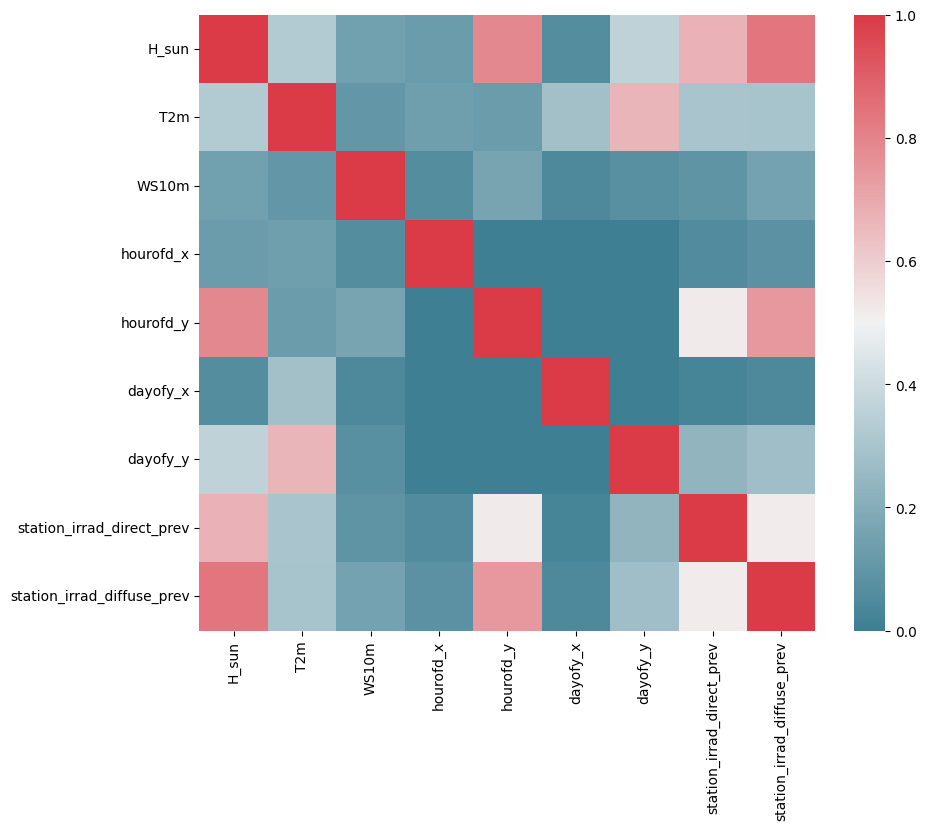

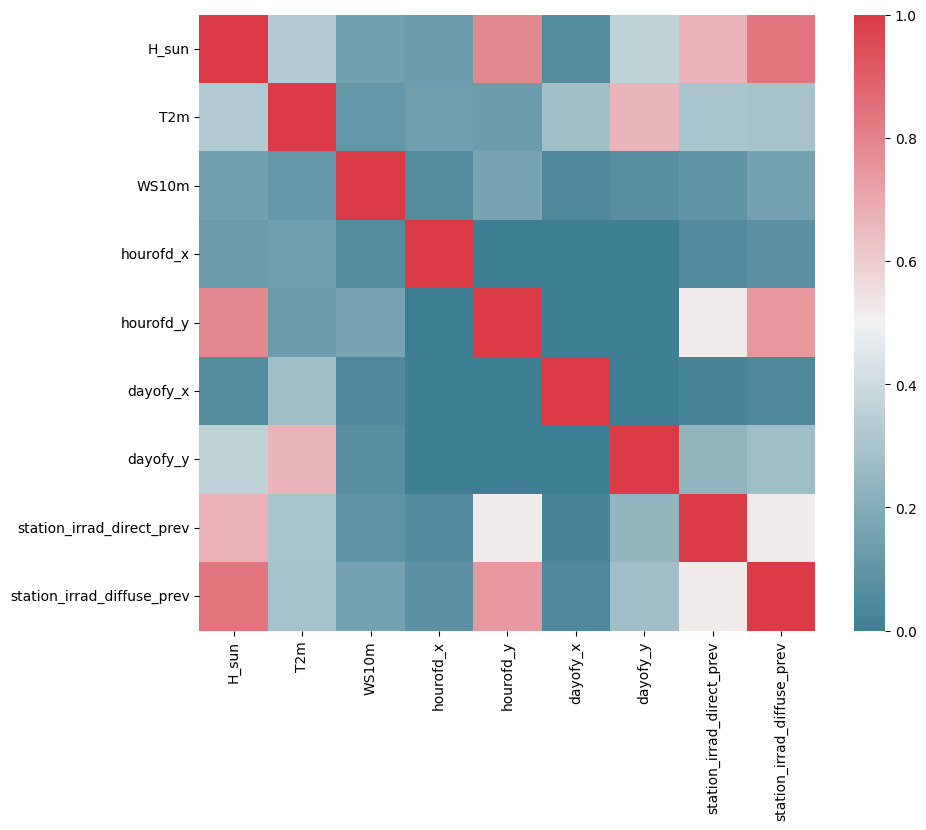

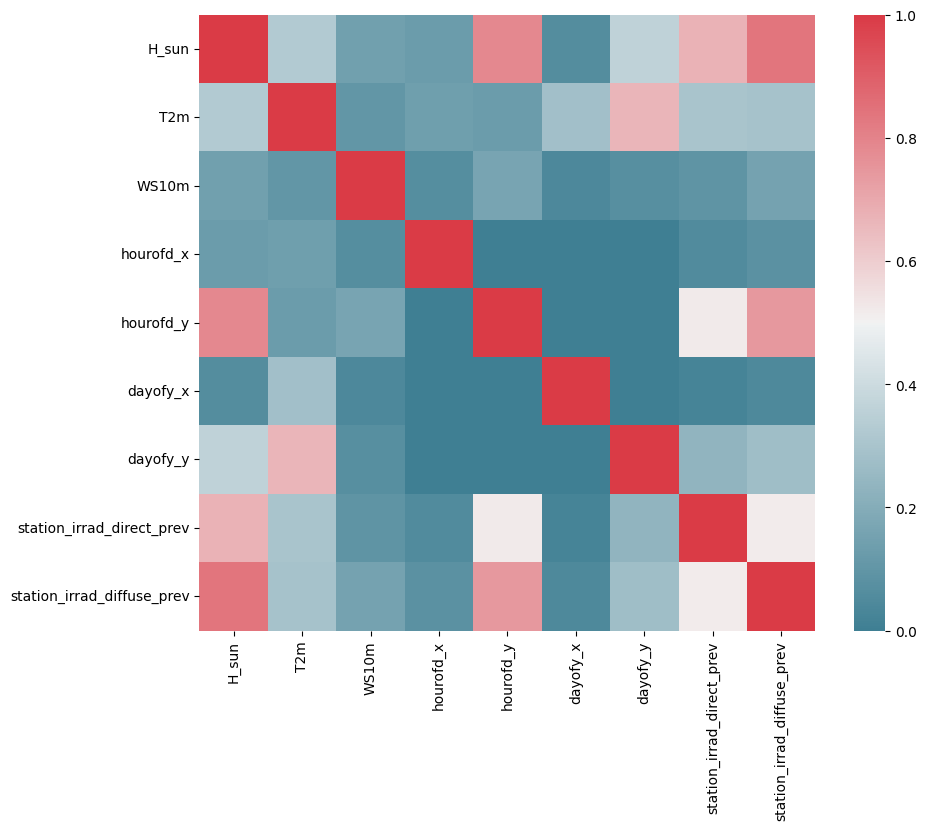

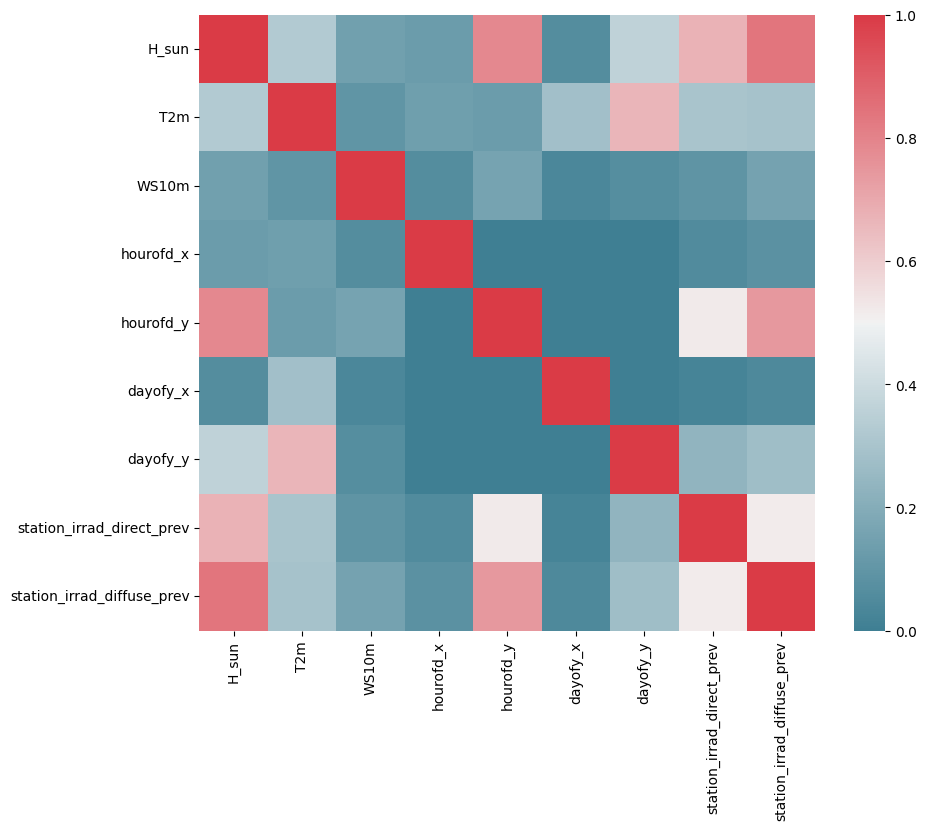

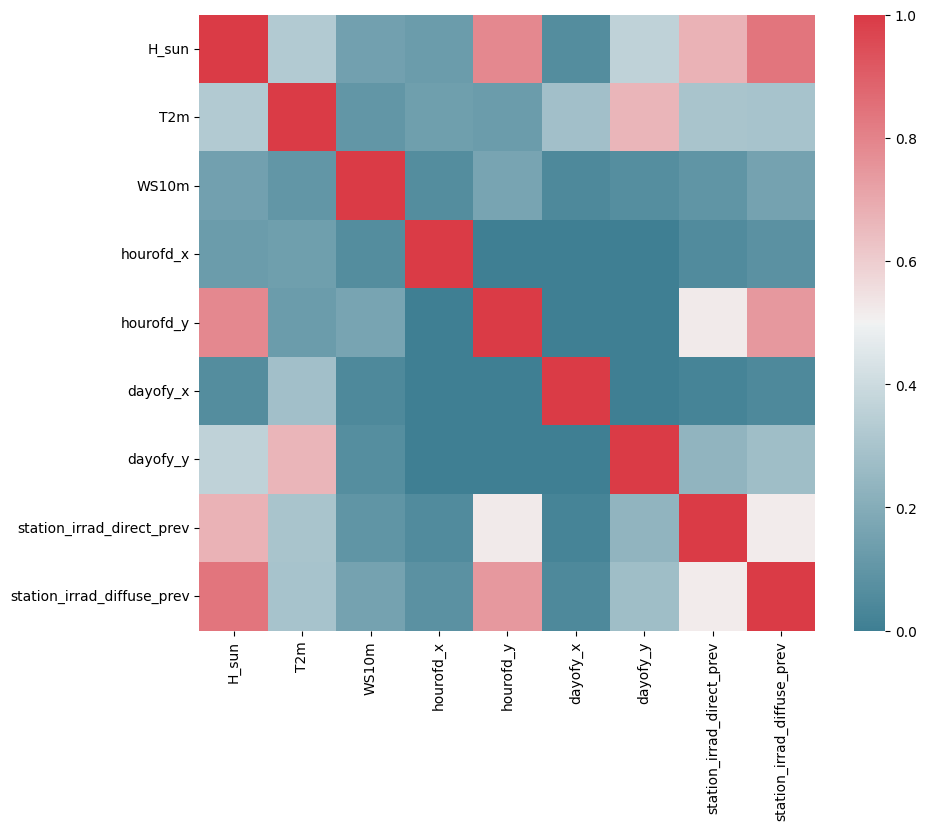

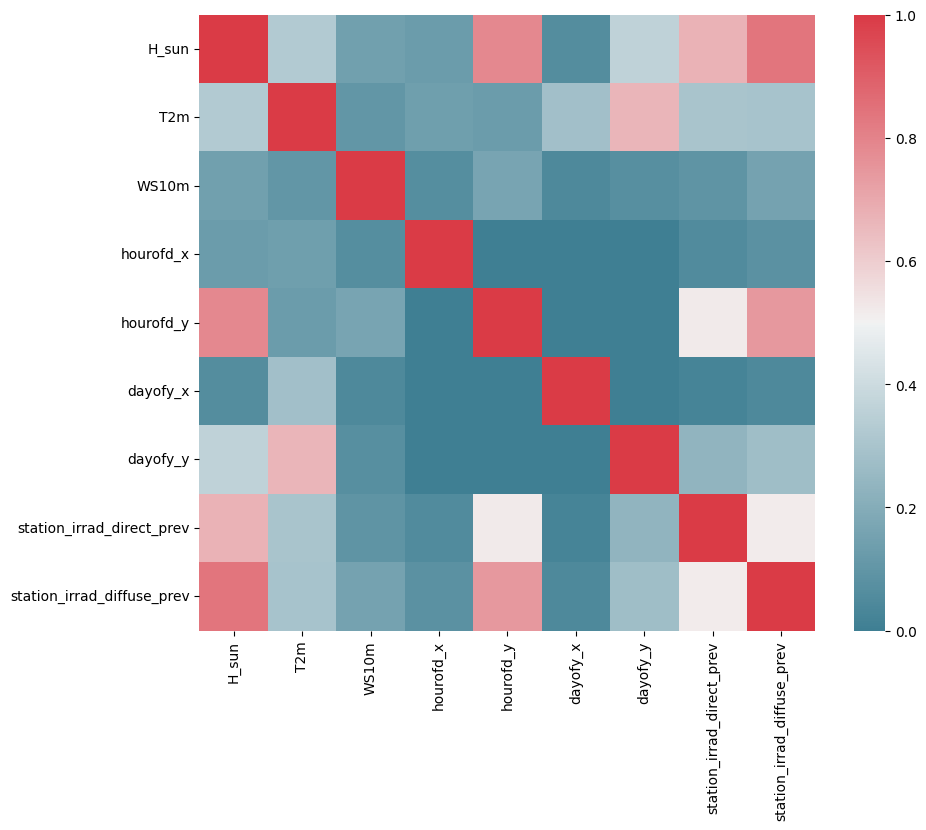

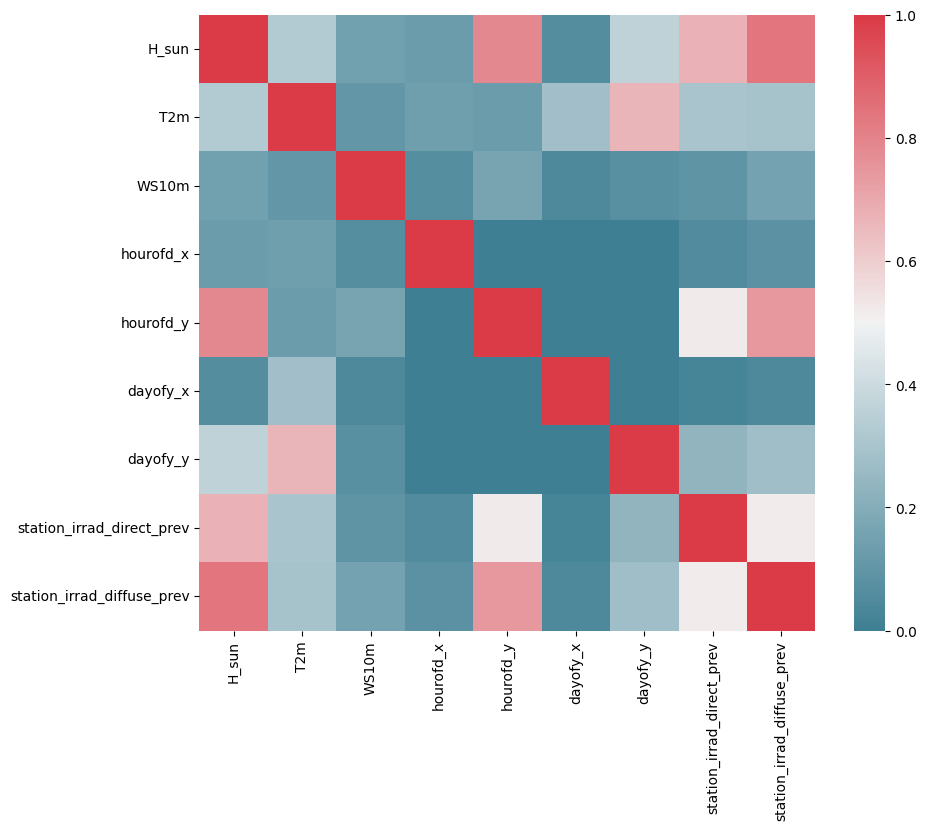

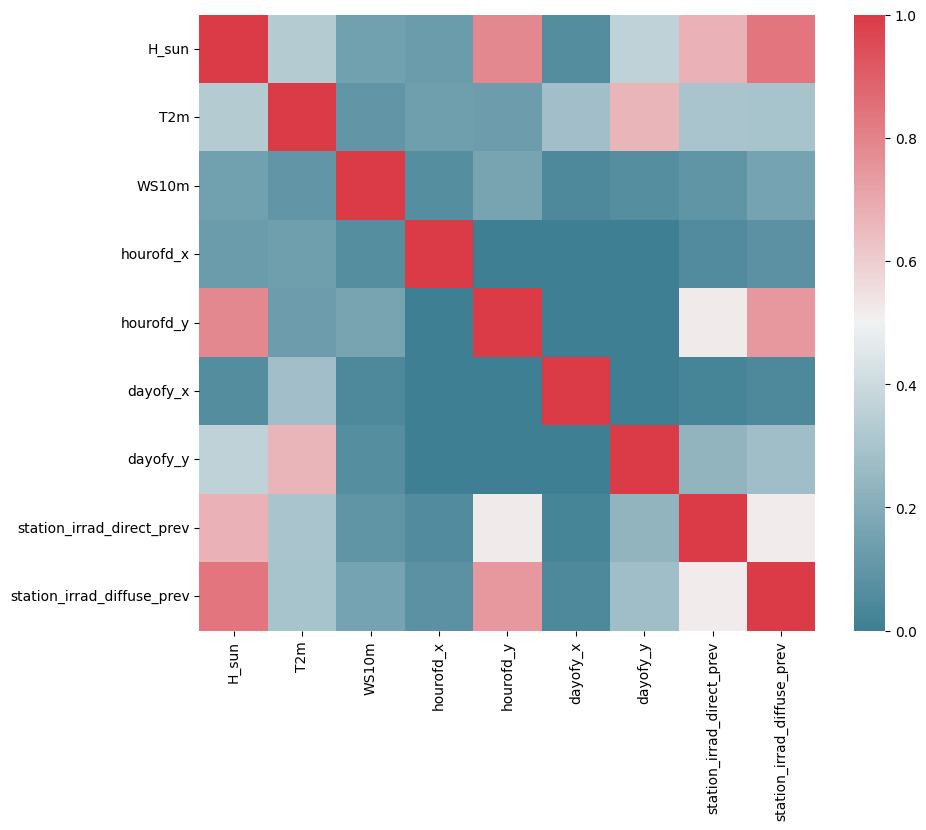

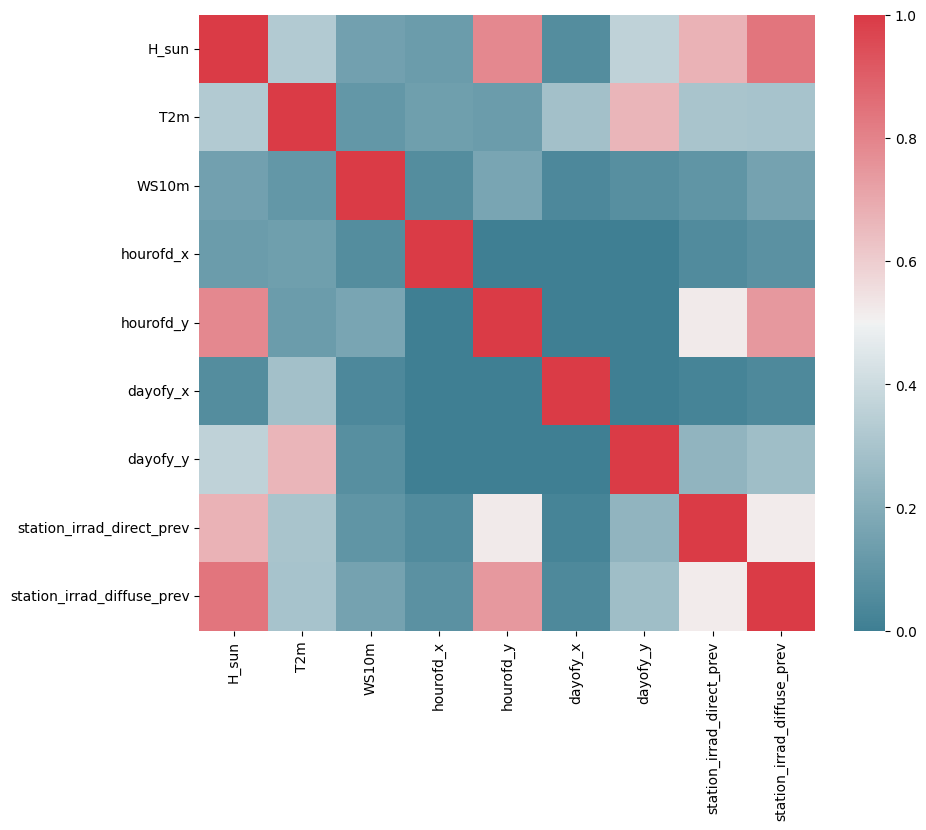

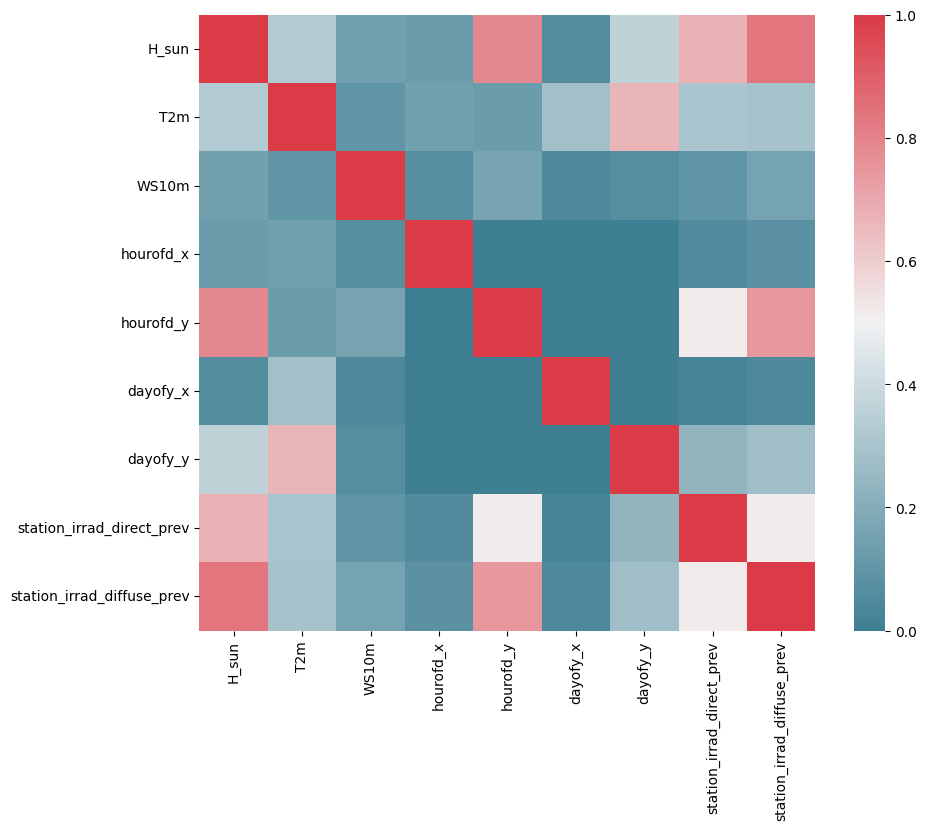

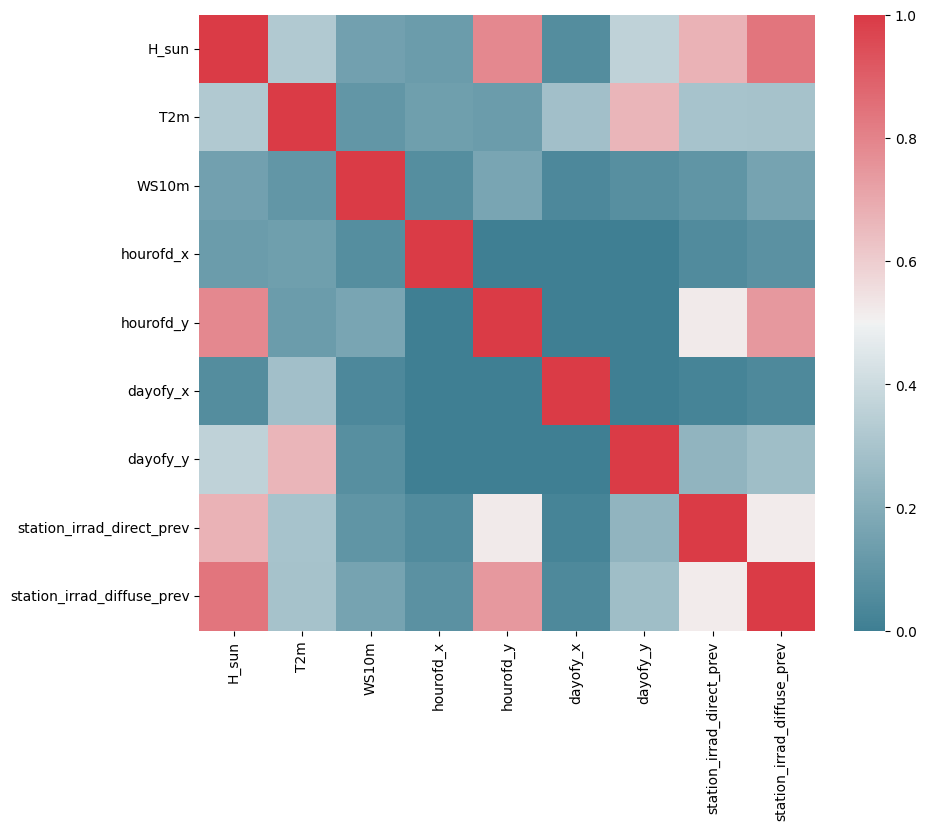

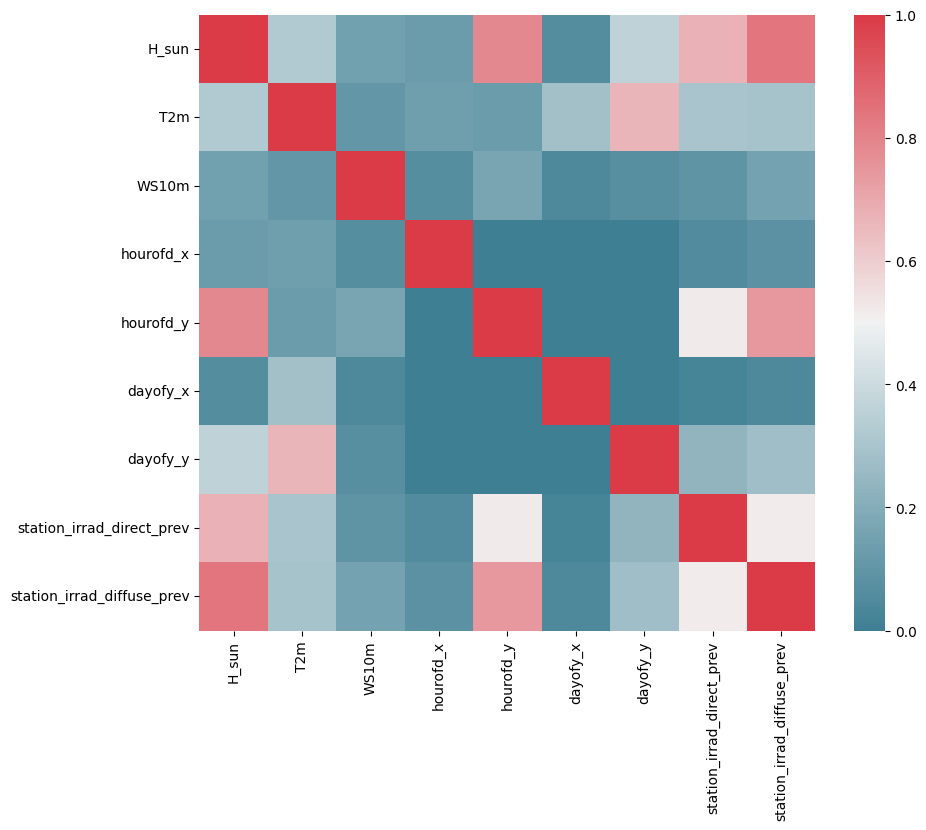

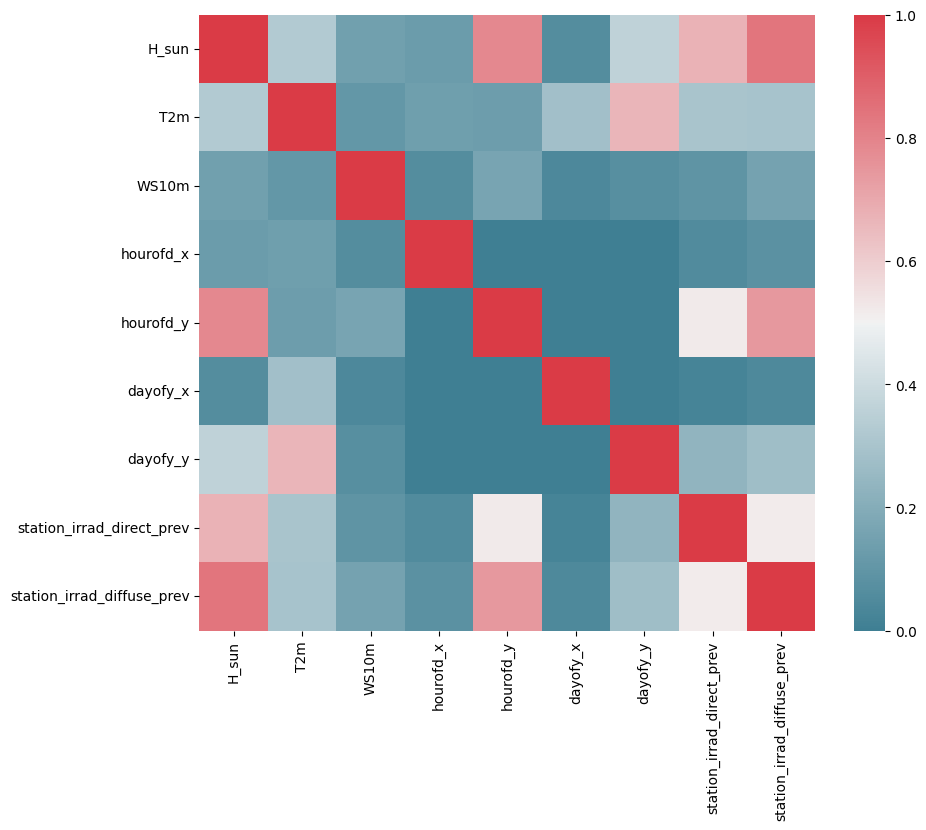

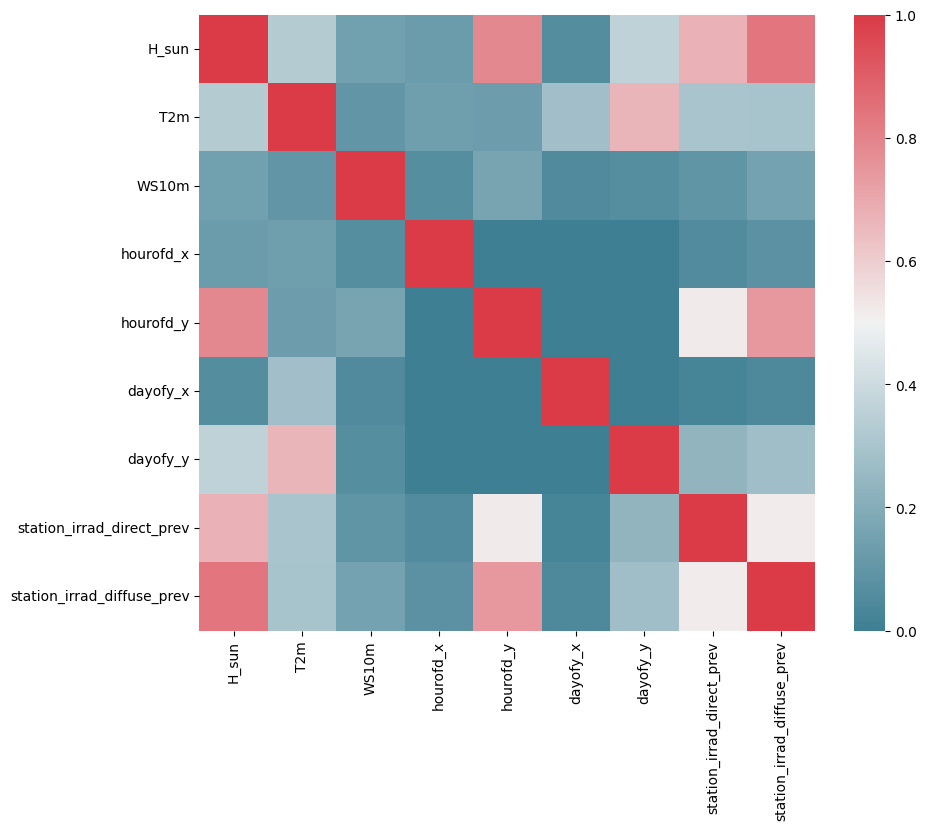

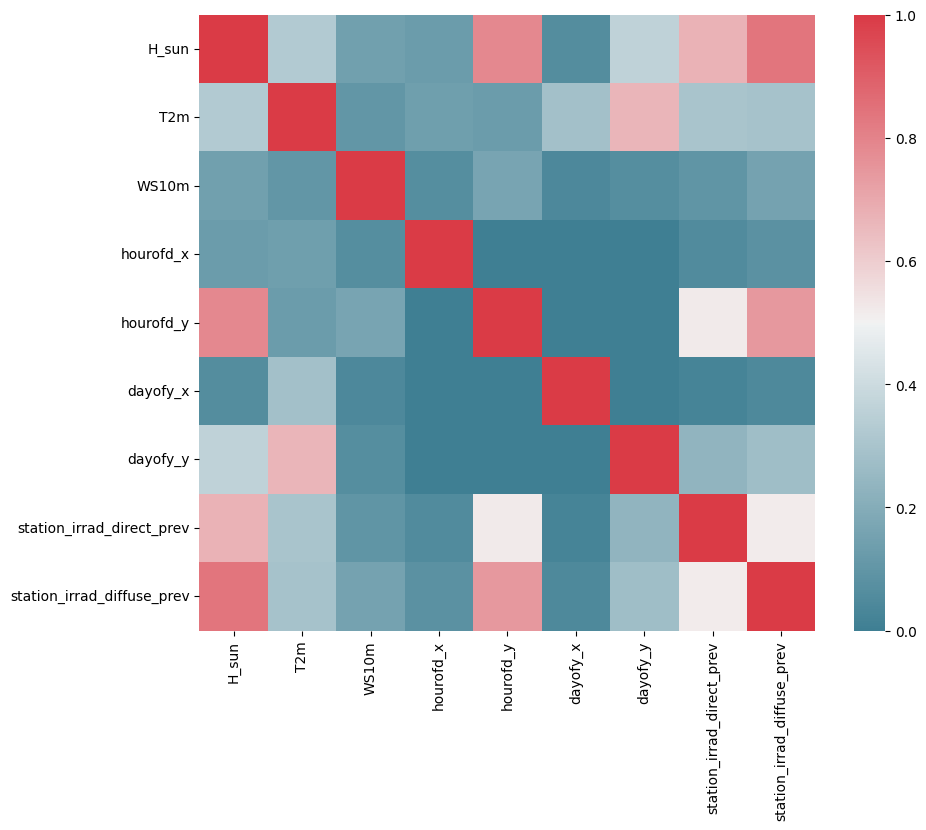

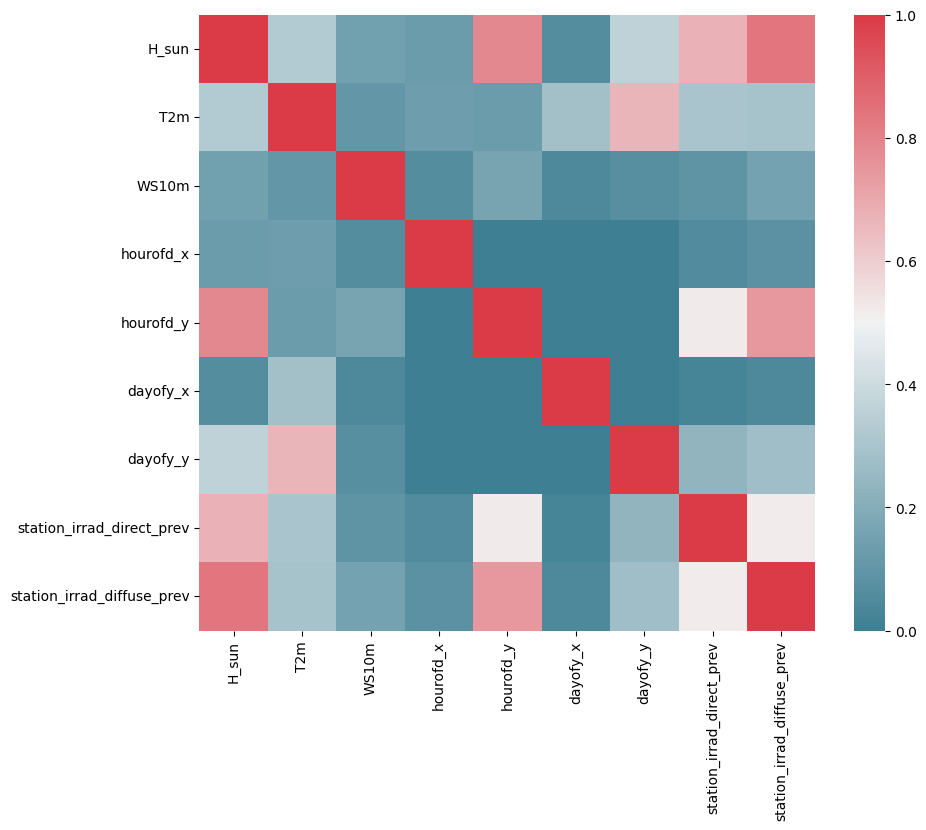

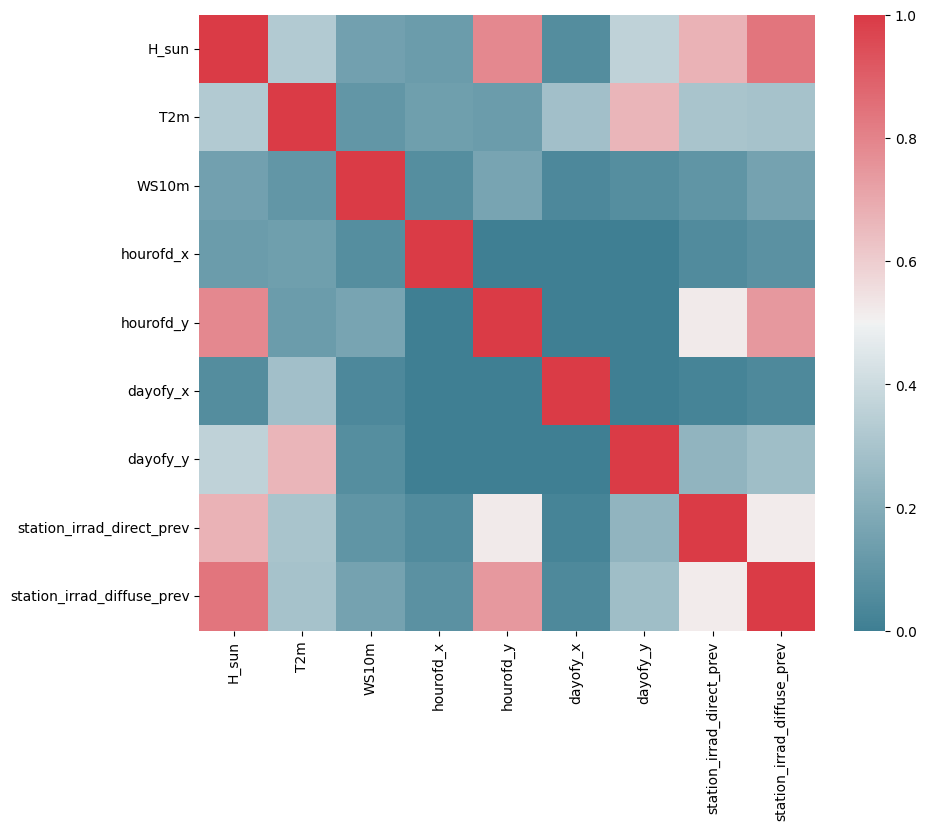

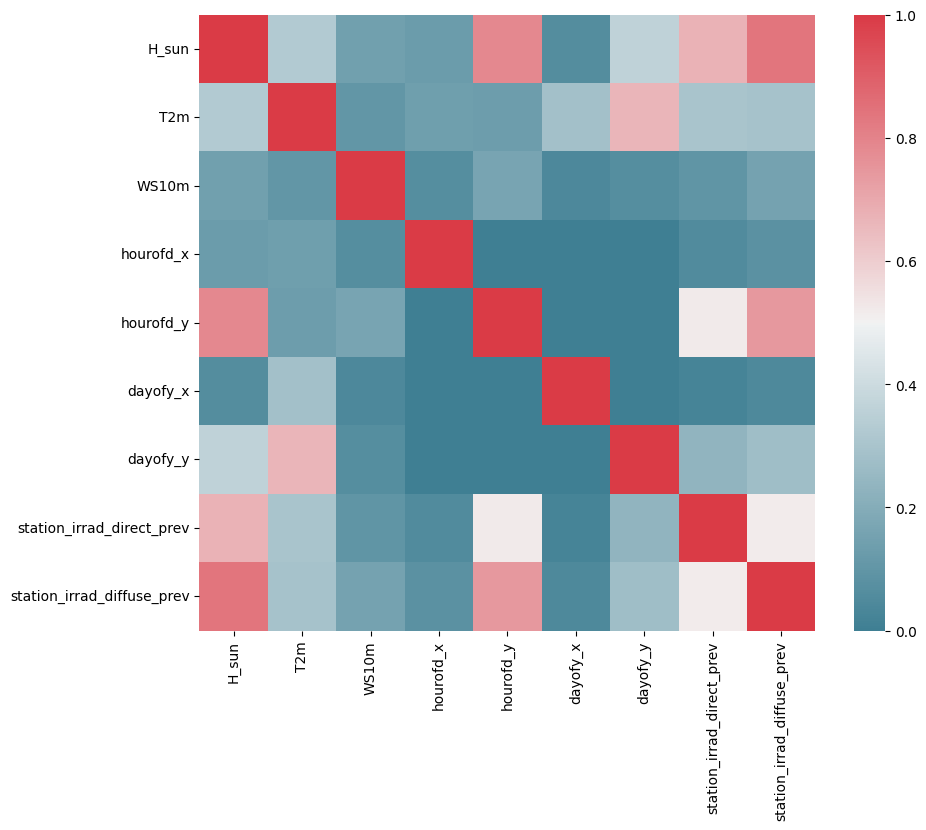

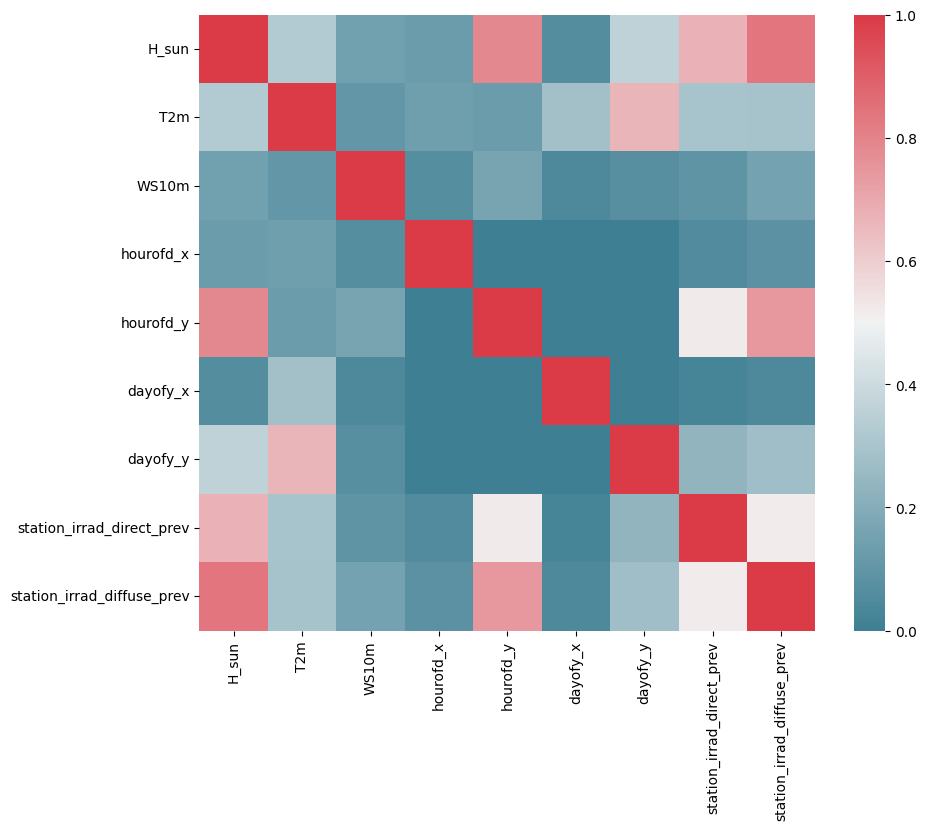

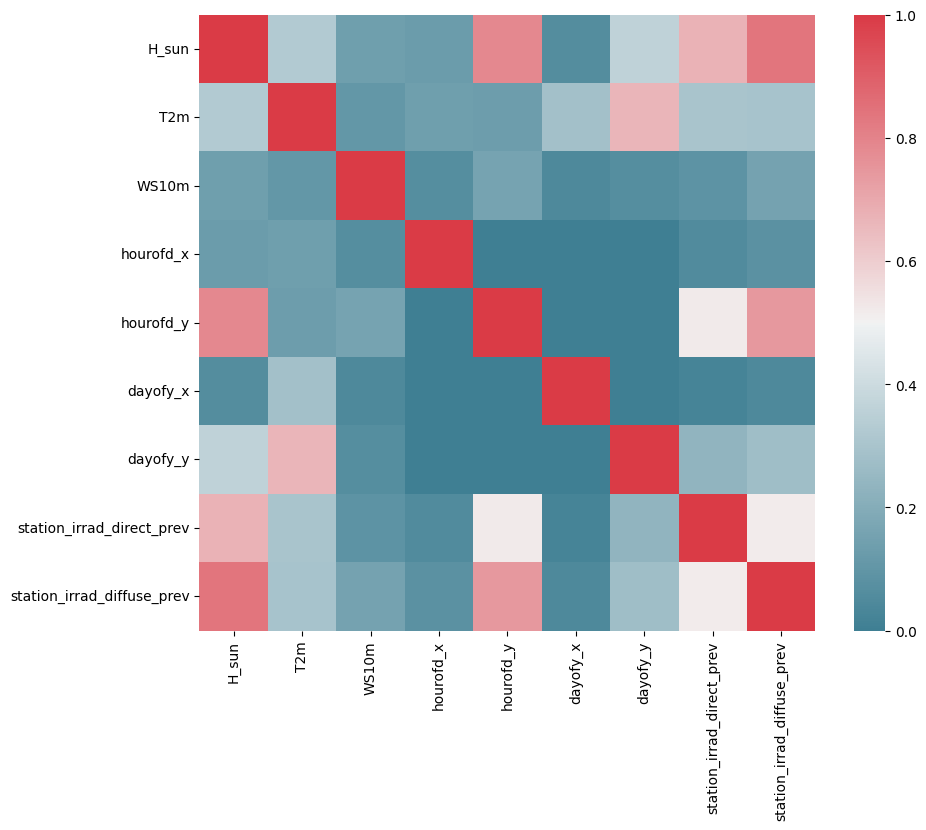

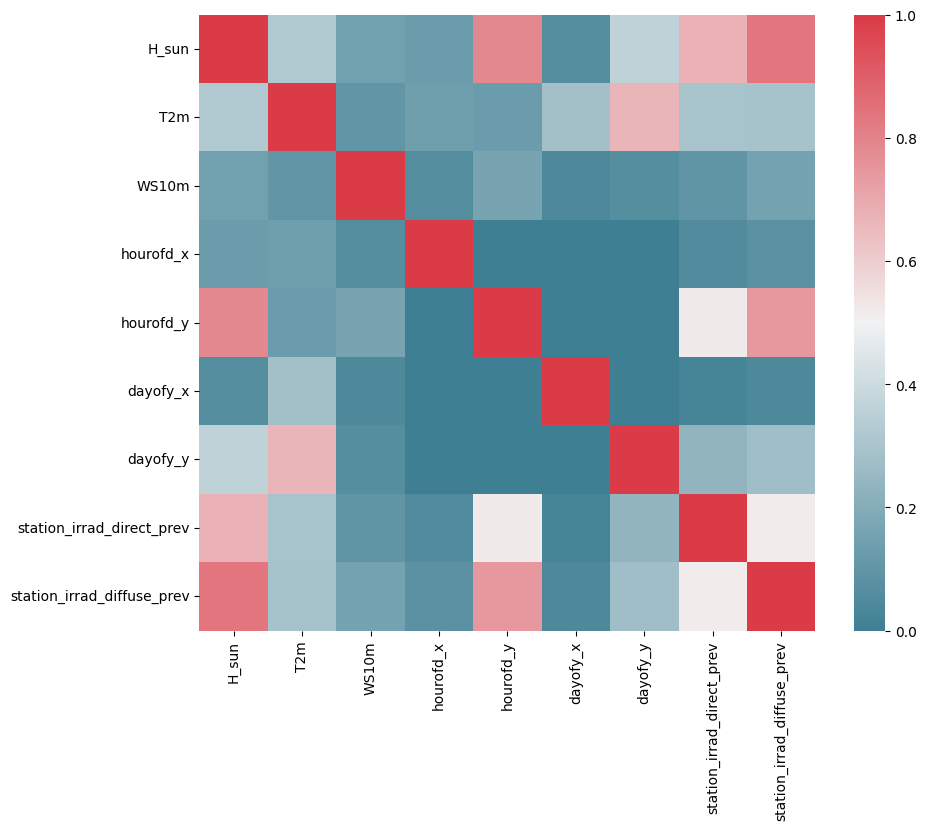

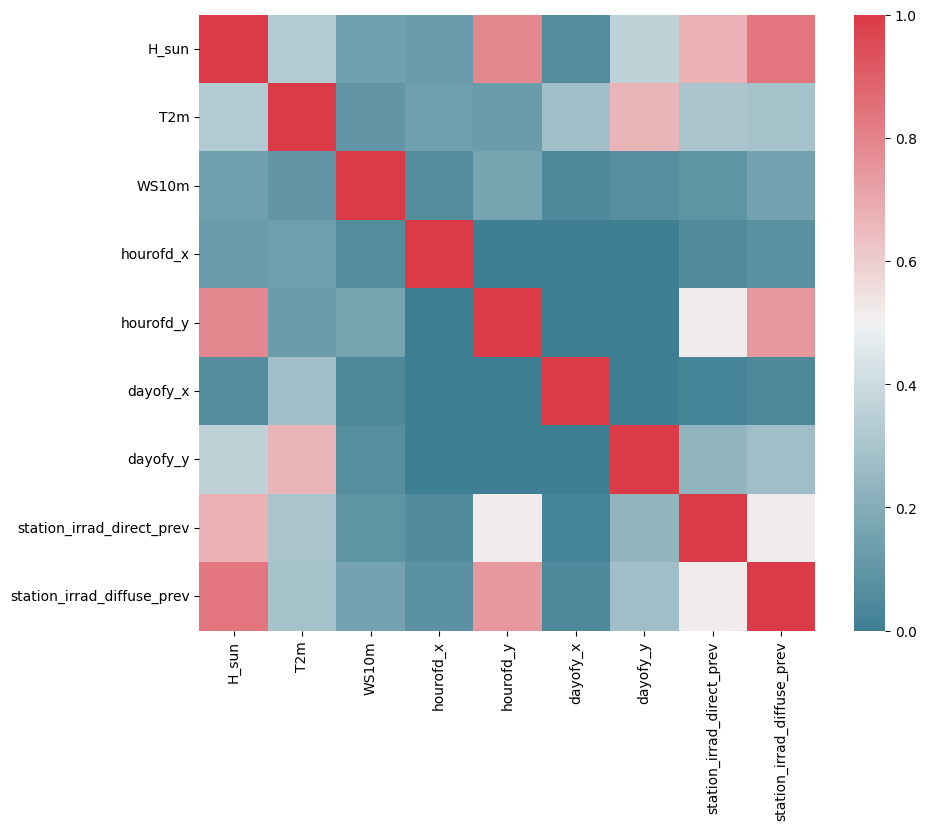

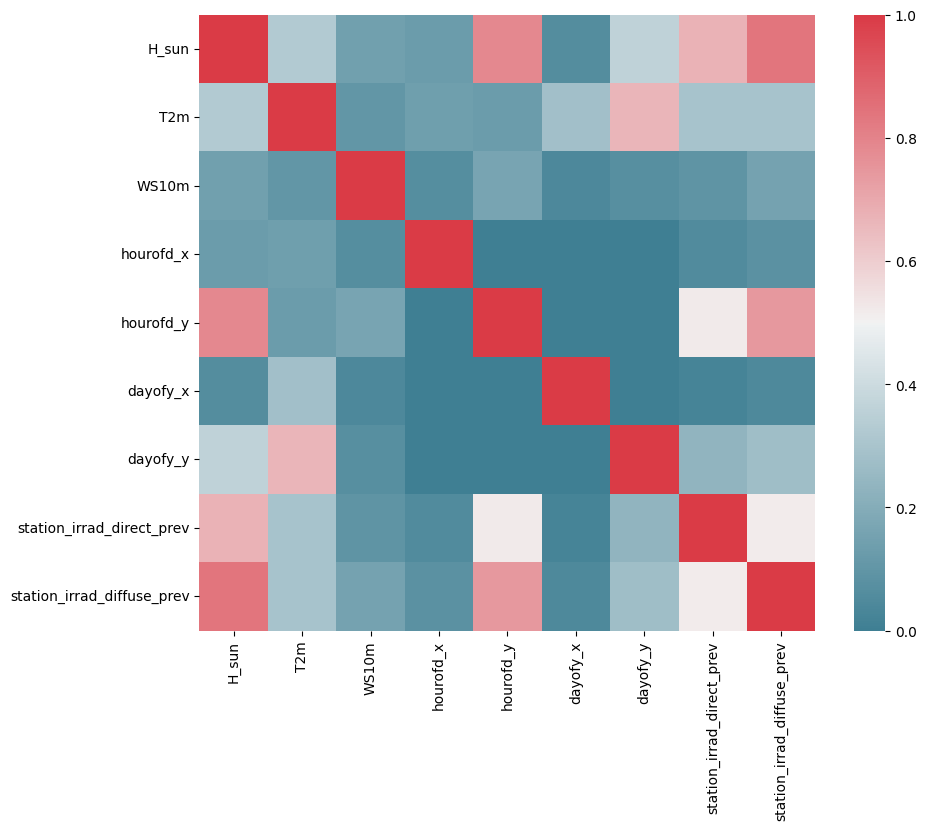

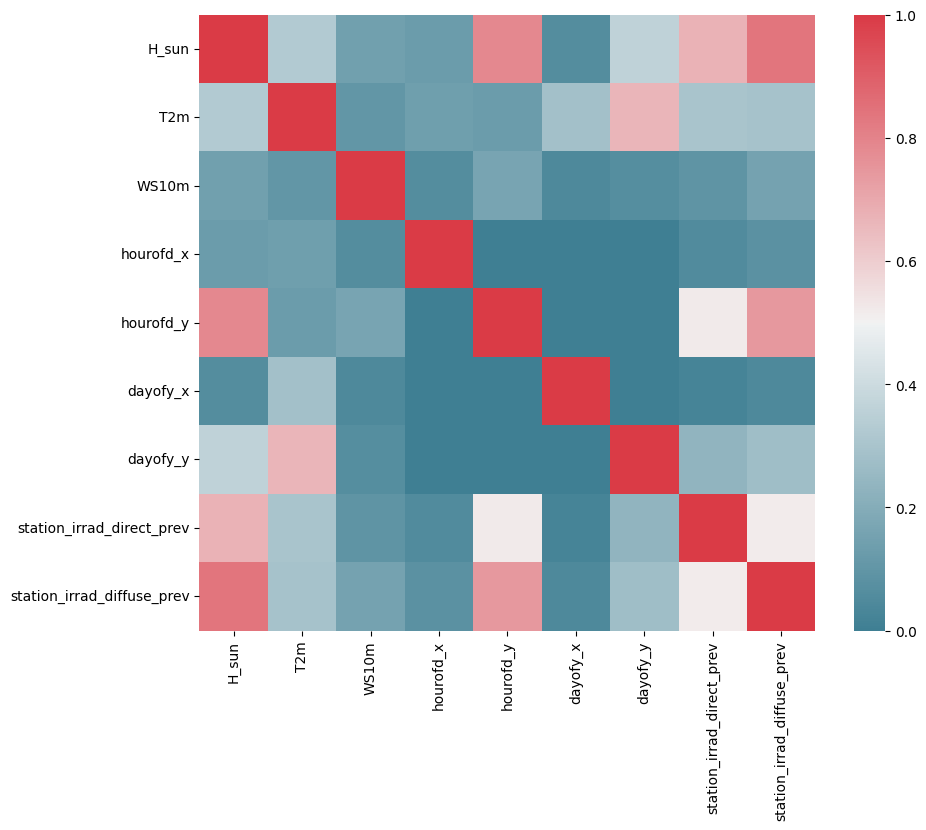

In [ ]:
# correlation map between features
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_av = np.zeros((len(non_ar_feat_names), len(non_ar_feat_names)))
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(10, 8))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    corr_av += np.abs(corr)
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
corr_av = corr_av/len(clients_subset)

msg = '[RES] observations:'
for row_ind, row in enumerate(corr_av.index):
    for col_ind, col in enumerate(corr_av.columns):
        if row_ind<col_ind:
            if np.abs(corr_av.iloc[row_ind, col_ind])>=0.75:
                msg += '\n' + row + ' and ' + col + ' are highly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
            elif np.abs(corr_av.iloc[row_ind, col_ind])>=0.5:
                msg += '\n' + row + ' and ' + col + ' are slightly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
print(msg)



In [ ]:
# correlation with the power
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_out = pd.DataFrame(columns = ['Client '+str(client_num) for client_num in clients_subset])
for client_num in clients_subset:    
    corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
corr_out['Average'] = corr_out.mean(numeric_only=True, axis=1)
print(corr_out)


msg = '\n[RES] observations:'
for feature in corr_out.index:
    corr_feat = corr_out.loc[feature, 'Average']
    if np.abs(corr_feat)<0.05:
        msg += '\ncorrelation of ' + feature + ' with the output is very low'
print(msg)

C:\Users\hecma\AppData\Local\Temp\ipykernel_14020\4014144171.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
C:\Users\hecma\AppData\Local\Temp\ipykernel_14020\4014144171.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
C:\U

                            Client 0  Client 1  Client 2  Client 3  Client 4  \
H_sun                       0.851936  0.843242  0.861193  0.861231  0.866916   
T2m                         0.249875  0.252349  0.259685  0.264513  0.270544   
WS10m                       0.088459  0.089108  0.099150  0.099877  0.097461   
hourofd_x                   0.208859  0.191572  0.164815  0.153020  0.178608   
hourofd_y                  -0.658045 -0.644266 -0.669276 -0.672114 -0.667491   
dayofy_x                    0.045473  0.043236  0.041546  0.040634  0.044711   
dayofy_y                   -0.261525 -0.259431 -0.254422 -0.255606 -0.277714   
station_irrad_direct_prev   0.735706  0.763000  0.800373  0.808468  0.776586   
station_irrad_diffuse_prev  0.686619  0.676676  0.704300  0.707826  0.704801   

                            Client 5  Client 6  Client 7  Client 8  Client 9  \
H_sun                       0.860604  0.869730  0.868693  0.864072  0.848555   
T2m                         0.264803  0

C:\Users\hecma\AppData\Local\Temp\ipykernel_14020\4014144171.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
C:\Users\hecma\AppData\Local\Temp\ipykernel_14020\4014144171.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
C:\U

remove features that are correlated with each other or have a low correlation with the output

['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'dayofy_y', 'station_irrad_direct_prev']


C:\Users\hecma\AppData\Local\Temp\ipykernel_14020\658881568.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(5, 5))


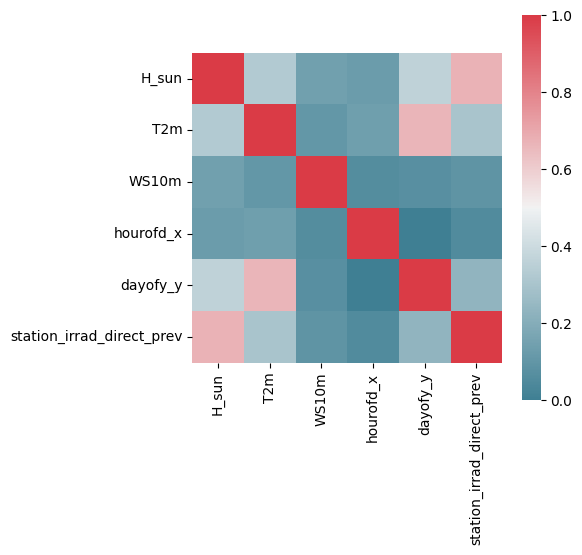

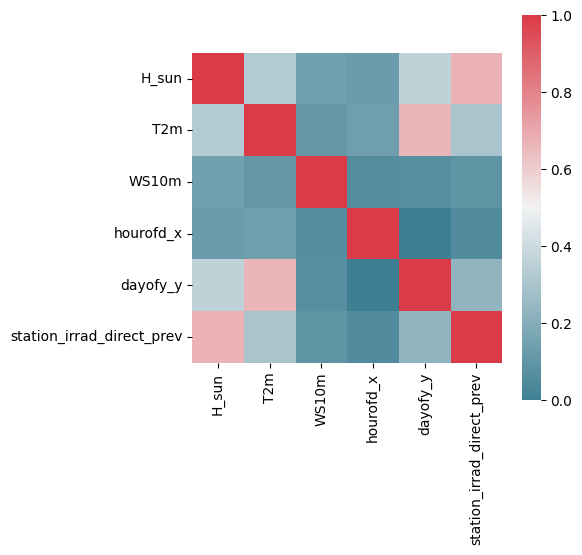

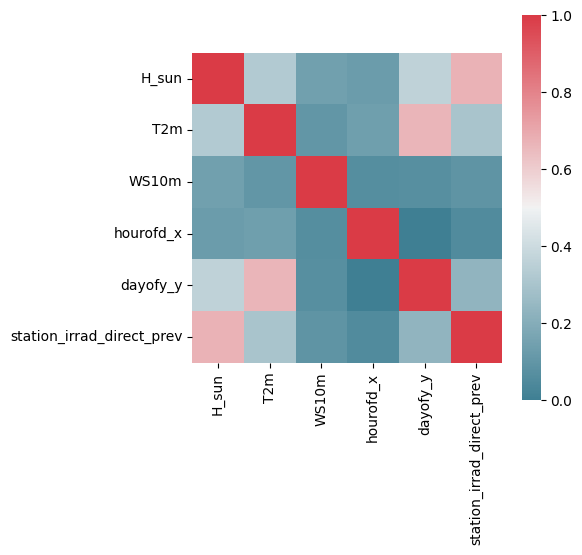

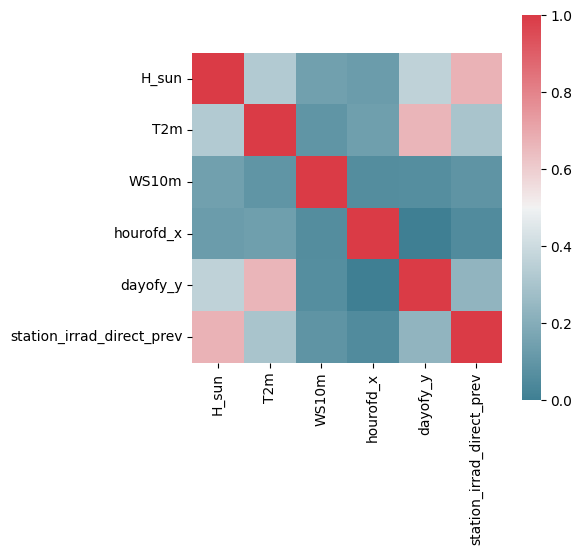

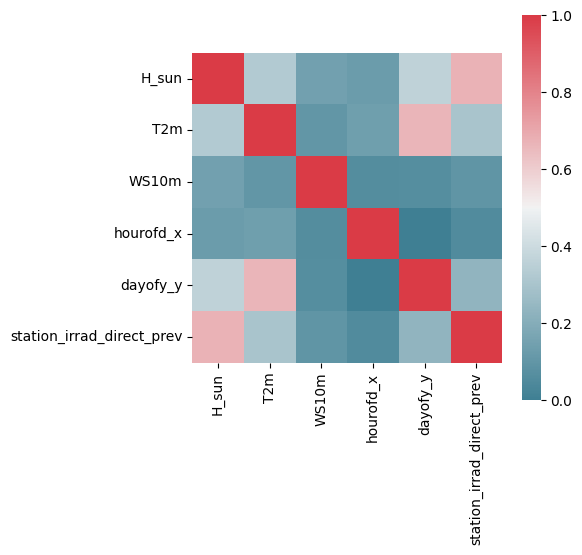

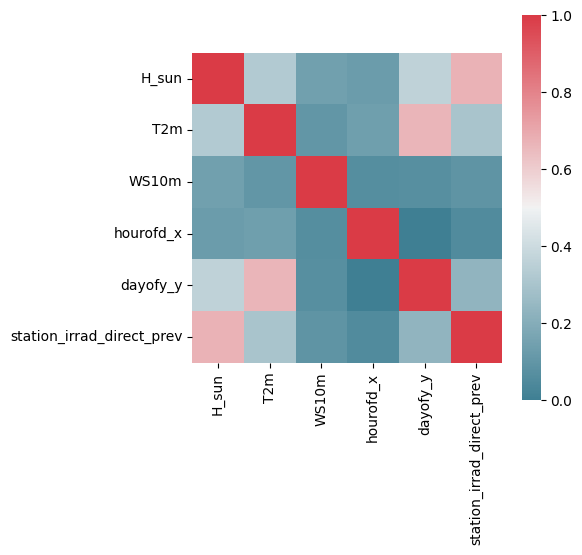

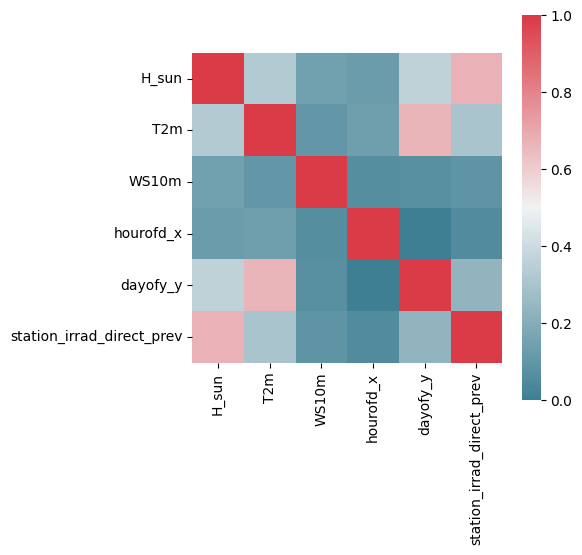

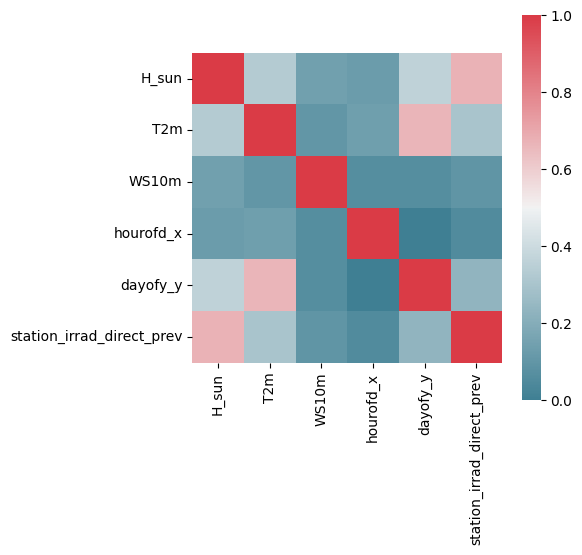

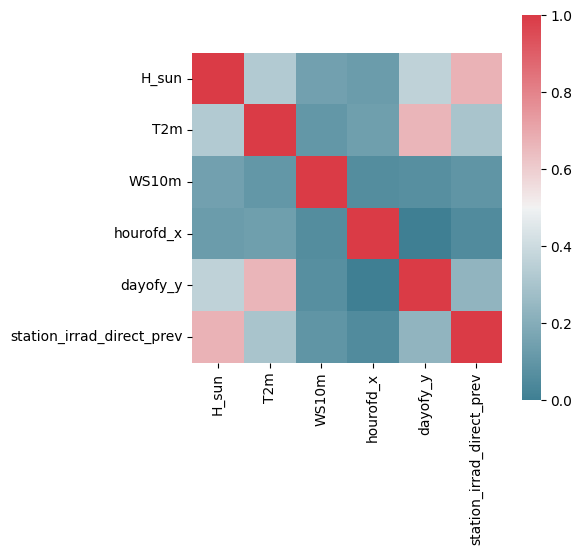

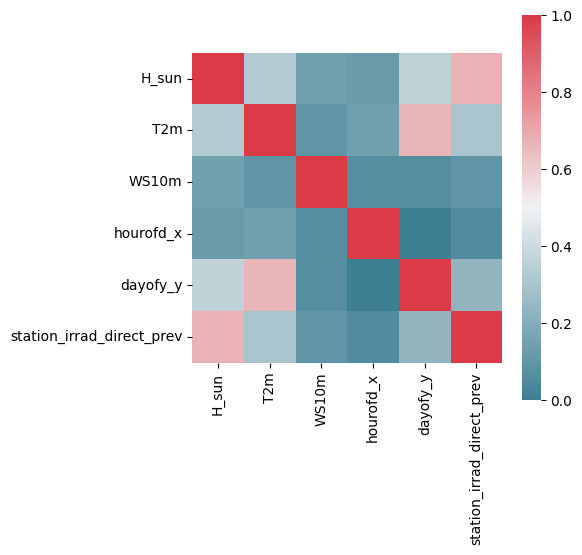

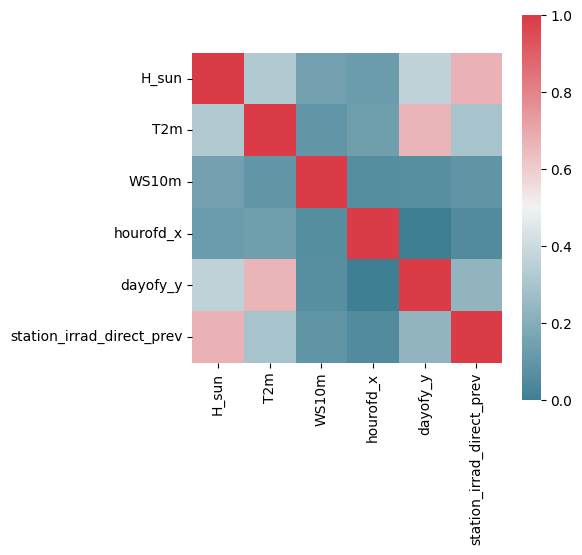

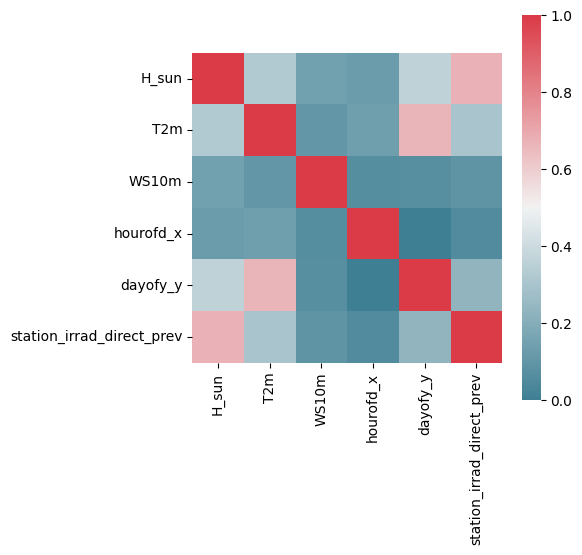

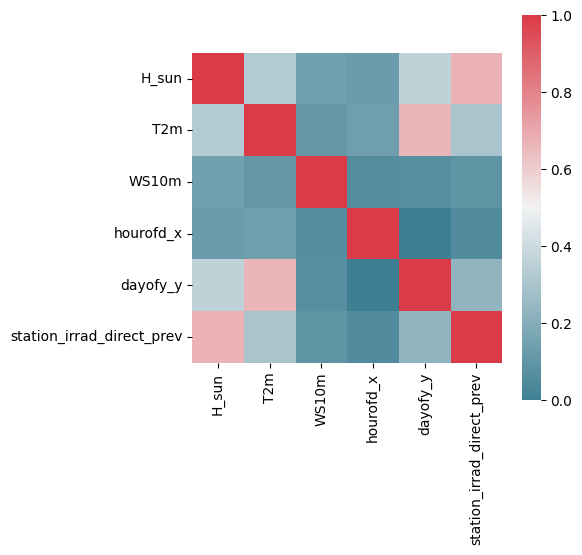

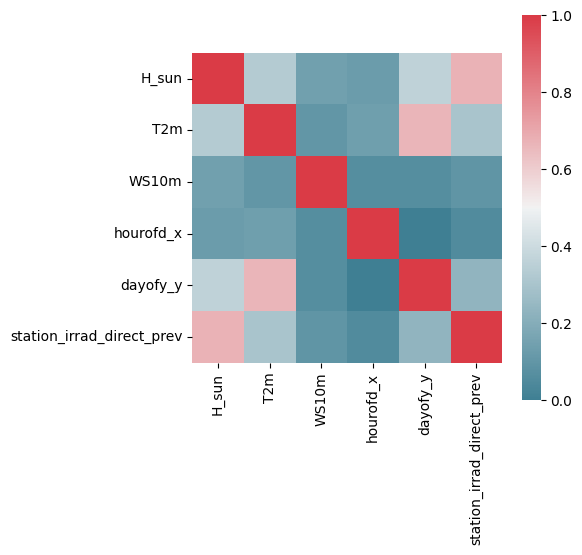

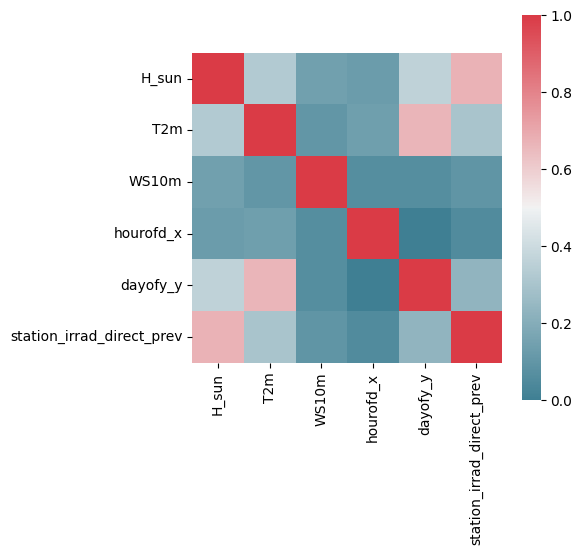

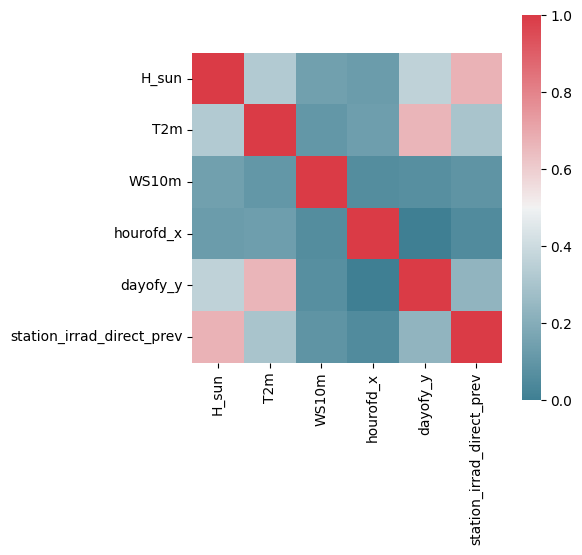

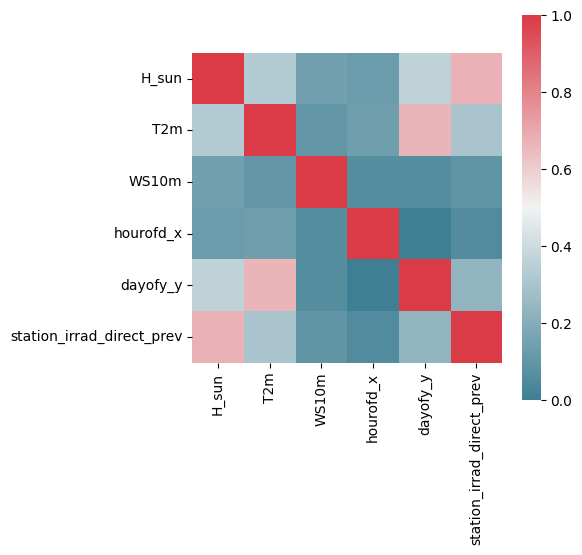

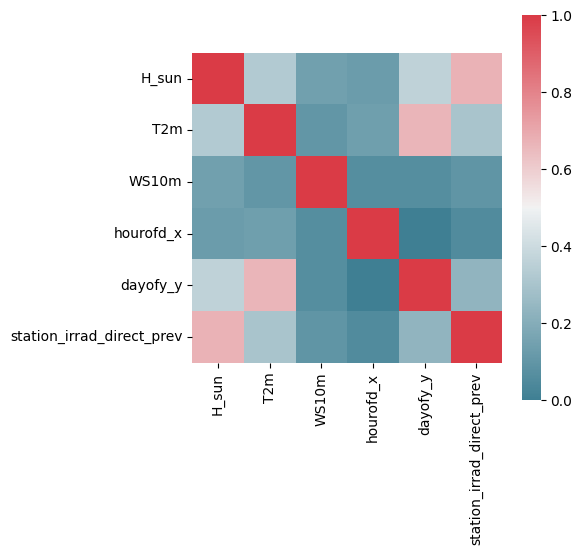

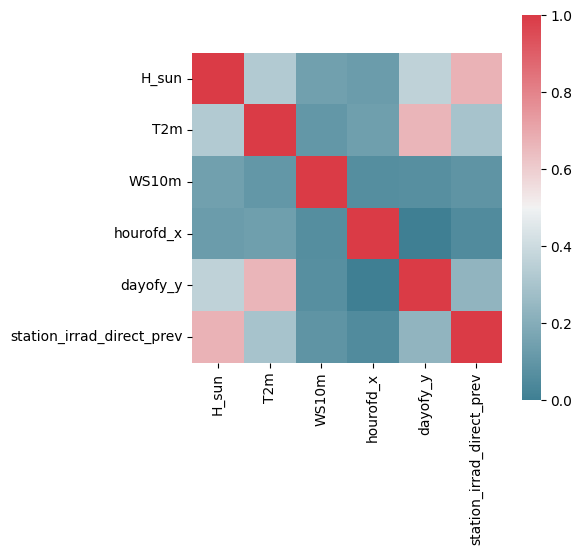

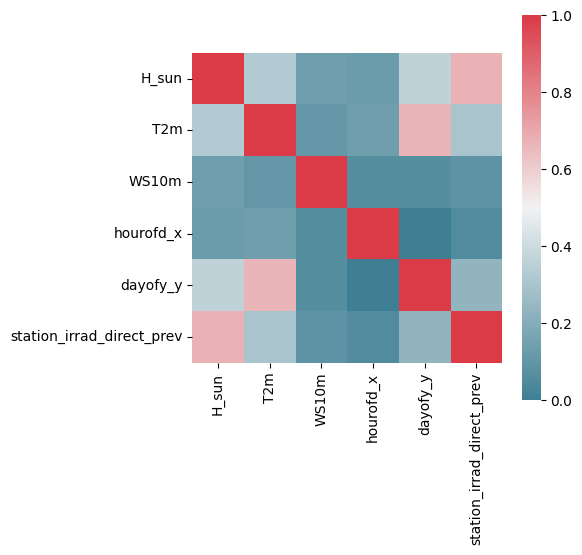

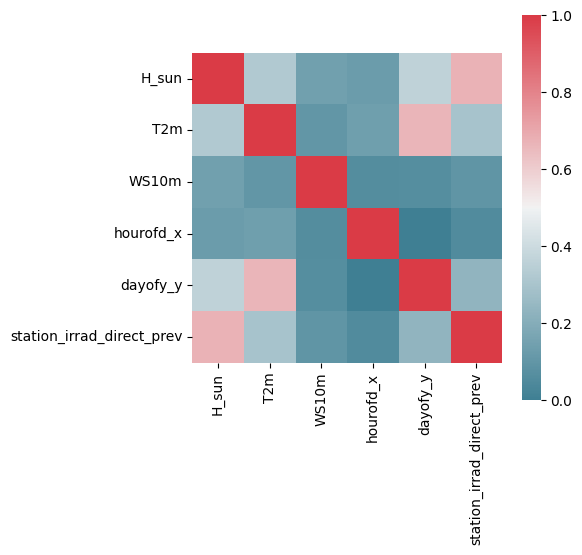

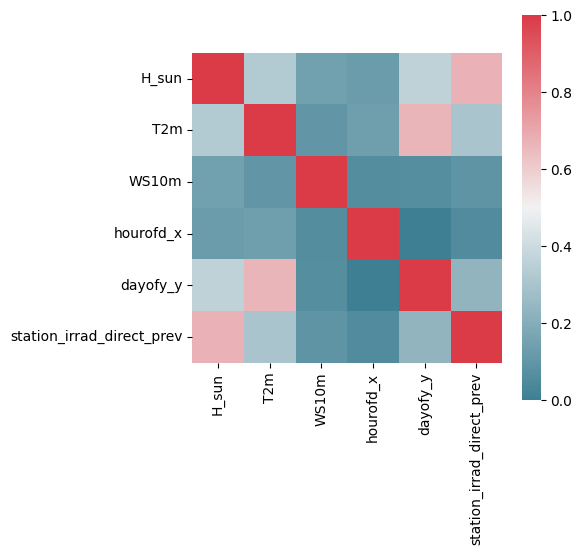

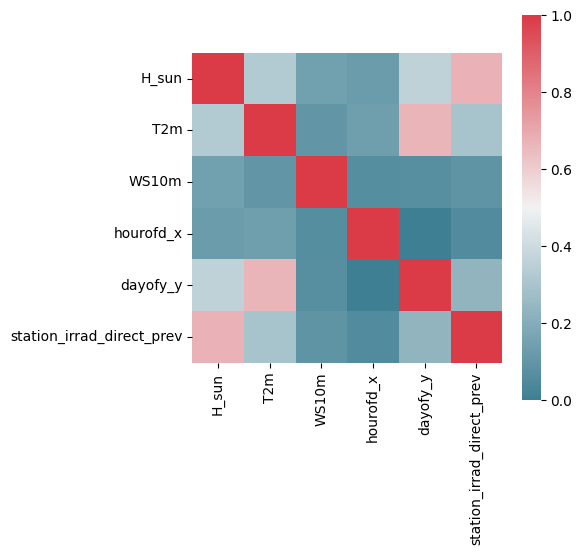

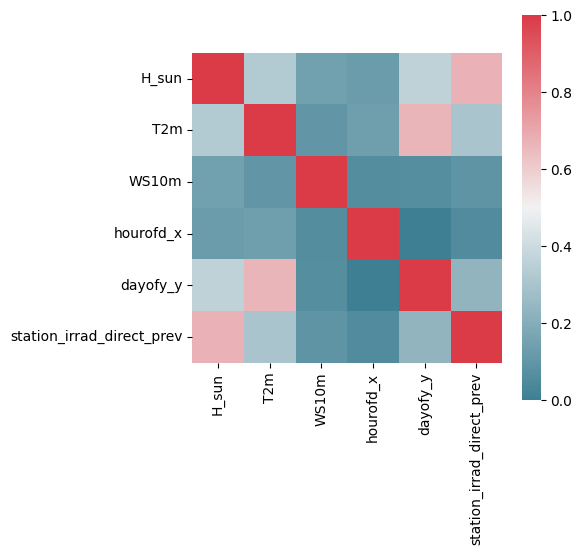

In [ ]:
non_ar_feat_remove = ['hourofd_y', 'station_irrad_diffuse_prev', 'dayofy_x']
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)
    for house in houses:
        if not house is None:
            house.feature_names.remove(feature_name)

print(env_dict['feature_names'])
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(5, 5))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)


# Selecting Features with RFECV
using a Ridge model with tuned penalty every time and Adj R2 scorer
selecting a small look back: weather effect is local

[INFO] searching among 246 features
[INFO] the following 24 features were selected:
H_sun lag 1 lag 2 lag 4 lag 7 lag 9 lag 22 lag 43 lag 44 lag 66 lag 68 lag 69 lag 96 lag 97 lag 114 lag 120 lag 121 lag 168 lag 169 lag 200 lag 201


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

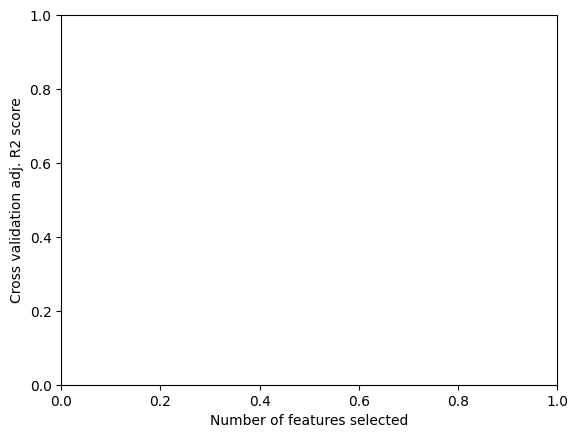

In [ ]:
from sklearn.feature_selection import RFECV
from model_training.search_models import RidgeWrapper
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from house_pv import _augment_lags, remove_constant_cols


def adj_r2_scorer(estimator, X, y):
    y = y.flatten()
    y_pred = estimator.predict(X).flatten()
    R2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1-(1-R2)*(n-1)/(n-p-1)

run_cell = True
if run_cell:
    # params
    cv = 2
    plot_fig = True
    days_look_back = 10
    keep_non_ar = False # force all non-ar features to remain
    min_features_to_select = 5

    # init
    selected_features = [None] * env_dict['num_clients']

    # all lags to try
    full_lags = np.arange(
        1, 
        min(24*days_look_back+1, 
            math.floor(env_dict['train_scenarios'][scenario_name_recons]['clients_data'][0][0].shape[0]/cv)-1)
        )
    full_lag_names = ['lag ' + str(x) for x in full_lags]

    # search
    for client_num, house in enumerate(houses):
        # augment lags
        house.data_power = _augment_lags(
                                house.data_power, 
                                lags=full_lags, 
                                step_ahead=1)
        house.feature_names += full_lag_names
        for x in non_ar_feat_remove:
            assert not x in house.feature_names

        # construct regression matrices
        data_tuple = house.construct_regression_matrices(
            m_train=env_dict['train_scenarios'][scenario_name_recons]['m_train'],
            train_years=env_dict['train_scenarios'][scenario_name_recons]['train_years'],
            valid_years=env_dict['train_scenarios'][scenario_name_recons]['valid_years'])

        # remove constant lags
        house.data_power, data_tuple, house.feature_names = remove_constant_cols(
                                data_power=house.data_power, 
                                data_tuple=data_tuple, 
                                feature_names=house.feature_names)
        print('[INFO] searching among {:2.0f} features'.format(len(house.feature_names)))
        
        # fit Ridge regression with Grid search over penalty
        ridge_wrapper = RidgeWrapper(alphas=np.logspace(-6,2,20)) 
        
        # fit RFECV
        X_train, y_train, X_valid, y_valid = data_tuple
        selector = RFECV(
                    estimator=ridge_wrapper, step=1, cv=cv, 
                    scoring=adj_r2_scorer, 
                    min_features_to_select=min_features_to_select) 
        selector = selector.fit(X_train, y_train.flatten())
        
        #Force every non-lag feature to be in the RFECV
        if keep_non_ar:
            for i, feature_name in enumerate(house.feature_names):
                if not feature_name.startswith('lag'):
                    selector.support_[i] = True
                    
        selected_features[client_num] = [house.feature_names[i] for i, x in enumerate(selector.support_) if x]
        print('[INFO] the following {:2.0f} features were selected:'.format(len(selected_features)))
        print(*selected_features[client_num])

        # Plot number of features VS. cross-validation scores
        if plot_fig:
            plt.figure()
            plt.xlabel("Number of features selected")
            plt.ylabel("Cross validation adj. R2 score")
            plt.plot(range(min_features_to_select,
                            len(selector.grid_scores_) + min_features_to_select),
                        selector.grid_scores_)
            plt.show()


    # save
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'wb')
    pickle.dump(
        {'selected_features':selected_features}, 
        file)
# load
else:
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'rb')
    res = pickle.load(file)
    print(res.keys())
    selected_features = res['selected_features']
file.close()



Check which hours in the previous days were important

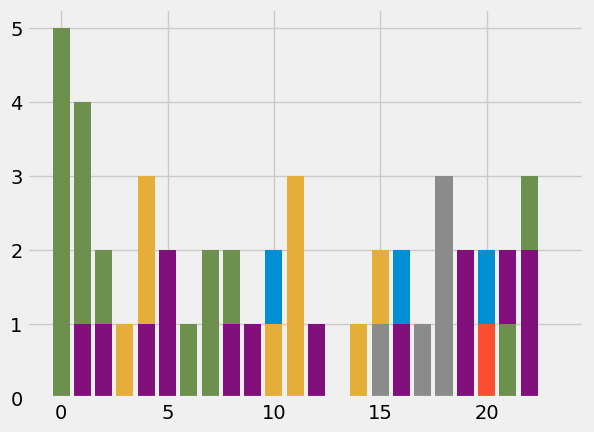

In [ ]:
for client_num in np.arange(env_dict['num_clients']):
    if not selected_features[client_num] is None:
        lag_nums = [int(x.split()[-1]) for x in selected_features[client_num] if x.startswith('lag')]
        lag_nums_mod = [x%24 for x in lag_nums]
        counts = [lag_nums_mod.count(x) for x in np.arange(24)]

        plt.bar(np.arange(24), counts)

Identify important features

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

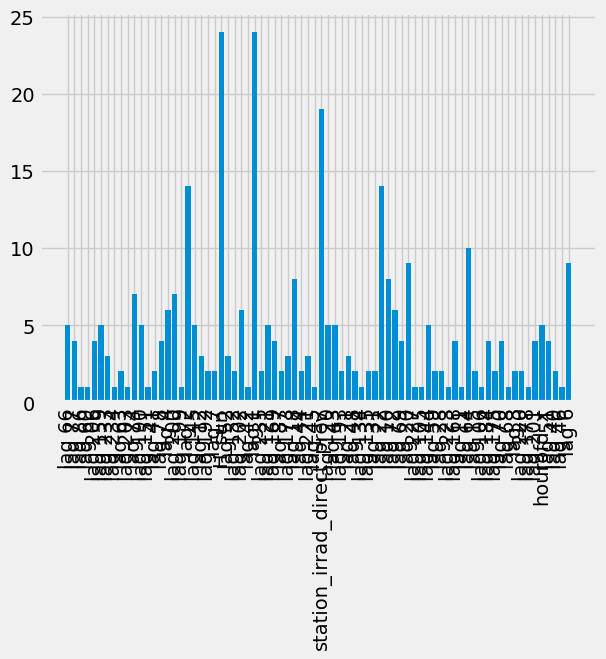

In [ ]:
# analyze regressors
all_counts = []
for client_num in np.arange(env_dict['num_clients']):
    if not selected_features[client_num] is None:
        all_counts.extend([x for x in selected_features[client_num]])
counts = [all_counts.count(x) for x in set(all_counts)]
plt.bar(list(set(all_counts)), counts)
plt.xticks(rotation=90)


### Feature Selection using PACF

(3050, 6)
Train R2 scores:  0.765972171770514 0.7649971156976312 0.758156431384381 0.7564714570368858 0.7594963022335834
Test  R2 scores:  0.739690726794231 0.7426972208933601 0.7704648915967574 0.7759735948954569 0.7657452549956876
Mean absolute error: train 10.0148, test 9.6176
Mean squared error:  train 188.5495, test 173.2997
Explained Variance Score (best=1): train 0.7565, test 0.7760
Coefficient of determination (R2): train 0.7565, test 0.7760
Adjusted coeff. of determination:  train 0.7559, test 0.7754
AIC: train -14.08, test -11.14
(3050, 6)
Train R2 scores:  0.7602026320382157 0.7516940604705882 0.7672800950542567 0.7625234656274203 0.7633274828125108
Test  R2 scores:  0.7621798136108853 0.7966335886807854 0.734269629440393 0.7538001420226593 0.7489834008445171
Mean absolute error: train 10.1074, test 9.2341
Mean squared error:  train 191.7693, test 159.2862
Explained Variance Score (best=1): train 0.7517, test 0.7967
Coefficient of determination (R2): train 0.7517, test 0.796

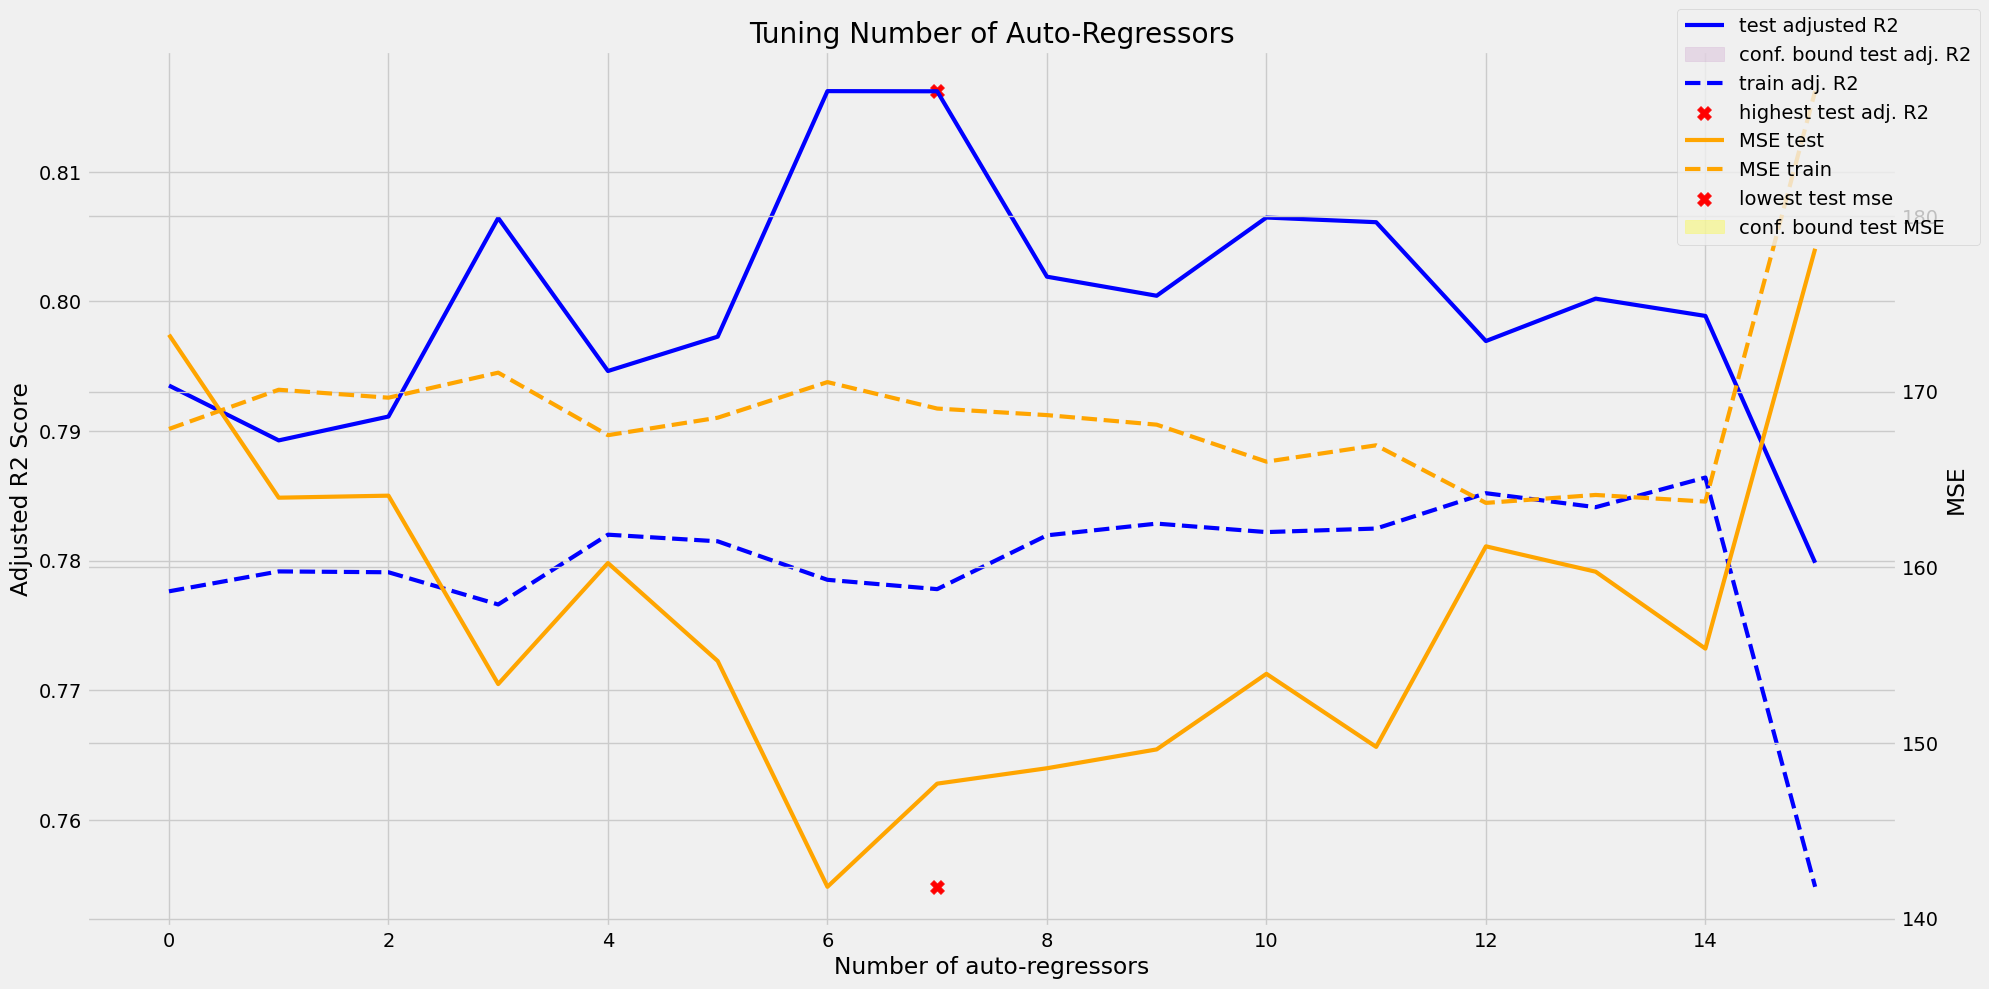

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			7				0.8162			3.2641		141.8130
min MSE:			7				0.8162			3.2641		141.8130
first in range:			4				0.8064			-2.8924		153.3561
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 21
[RES] lags by lowest adj r2:  1 2 3 21 20 22 18
(140015, 256)
(3050, 6)
Train R2 scores:  0.74795906269244 0.7527758454440158 0.7552194056374709 0.7515640963640092 0.7541648481567977
Test  R2 scores:  0.7687403107509262 0.7491905143348132 0.7381224631930312 0.7529510150008072 0.7415567429540788
Mean absolute error: train 17.9868, test 17.3610
Mean squared error:  train 572.7281, test 532.8043
Explained Variance Score (best=1): train 0.7480, test 0.7688
Coefficient of determination (R2): train 0.7480, test 0.7687
Adjusted c

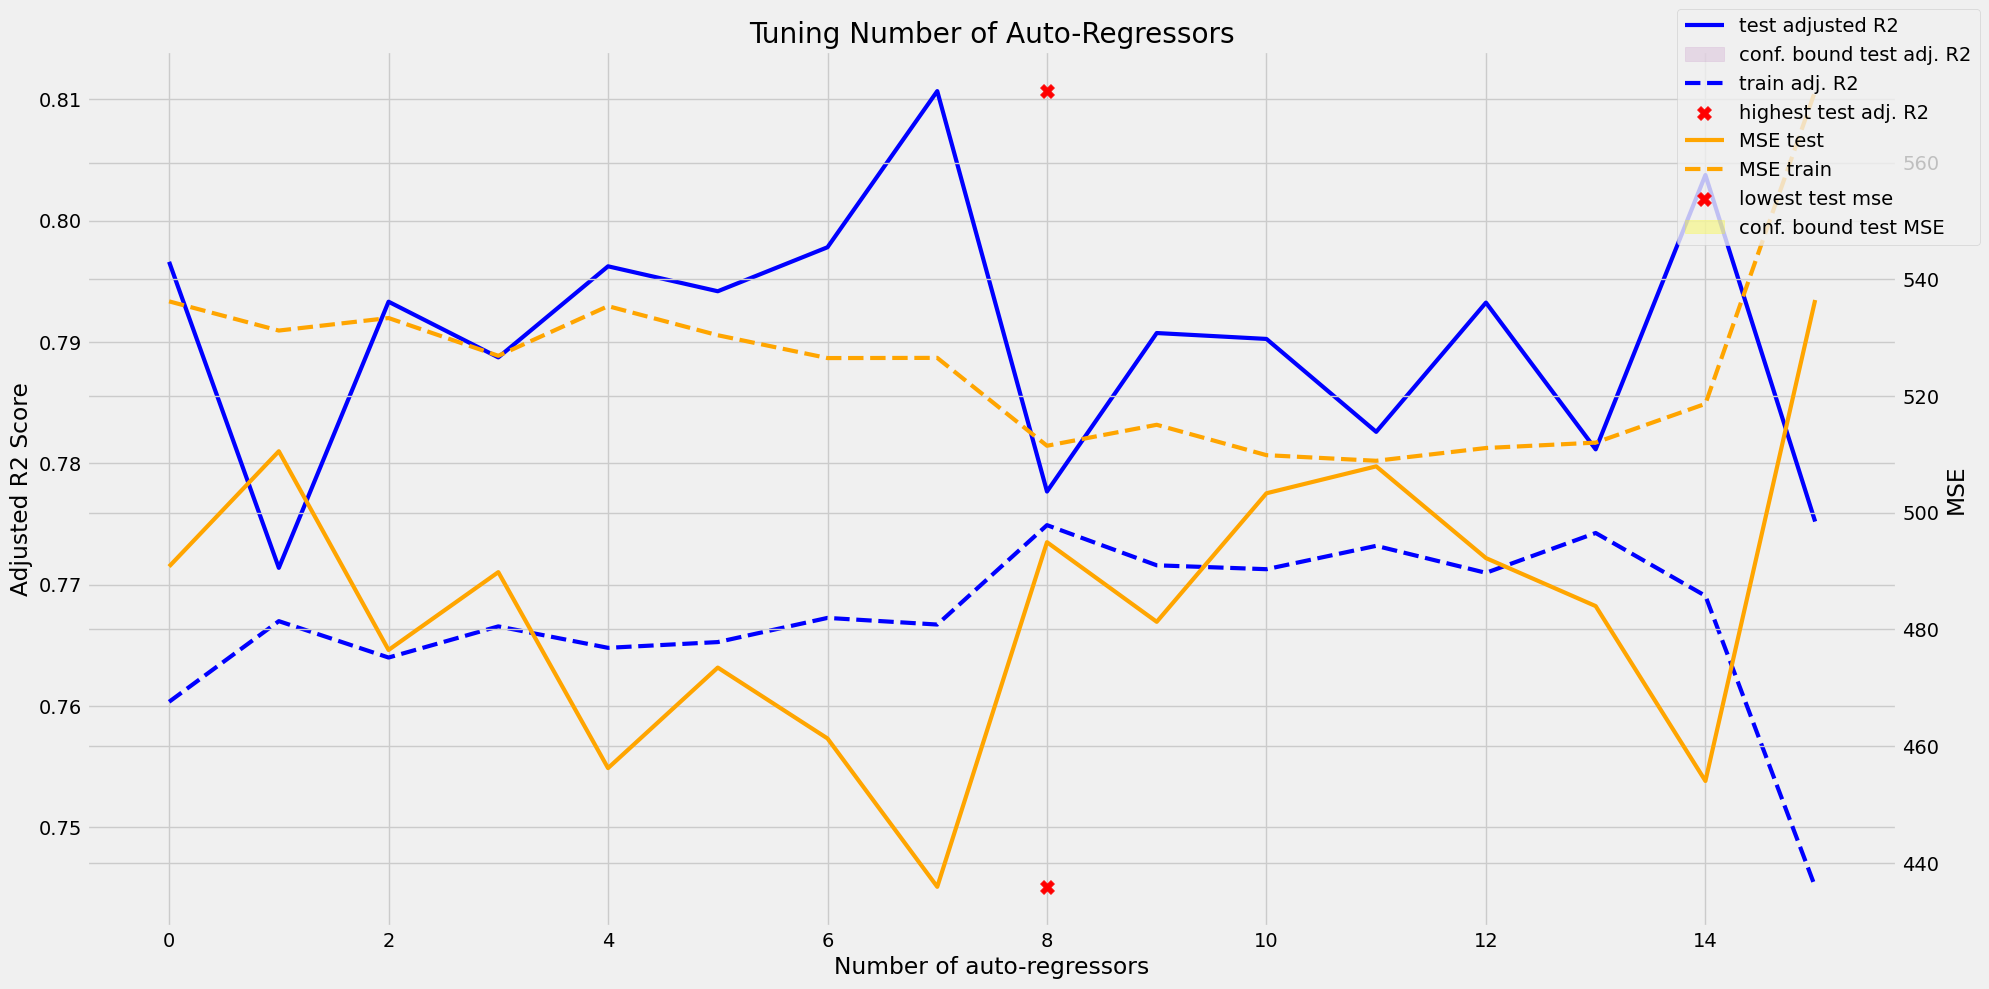

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			8				0.8107			3.0183		435.8911
min MSE:			8				0.8107			3.0183		435.8911
first in range:			3				0.7933			-7.1597		476.4718
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 23
[RES] lags by lowest adj r2:  1 2 23 25 3 21 19 20
(140015, 256)
(3050, 6)
Train R2 scores:  0.8018090576223019 0.8020684682229354 0.8045706351619062 0.8023917415950405 0.8041117273893255
Test  R2 scores:  0.806003909932075 0.8052222448299893 0.7956179772231812 0.8042210710912638 0.797406455150623
Mean absolute error: train 14.1943, test 14.6287
Mean squared error:  train 398.2630, test 408.1311
Explained Variance Score (best=1): train 0.8018, test 0.8060
Coefficient of determination (R2): train 0.8018, test 0.8060
Adjusted 

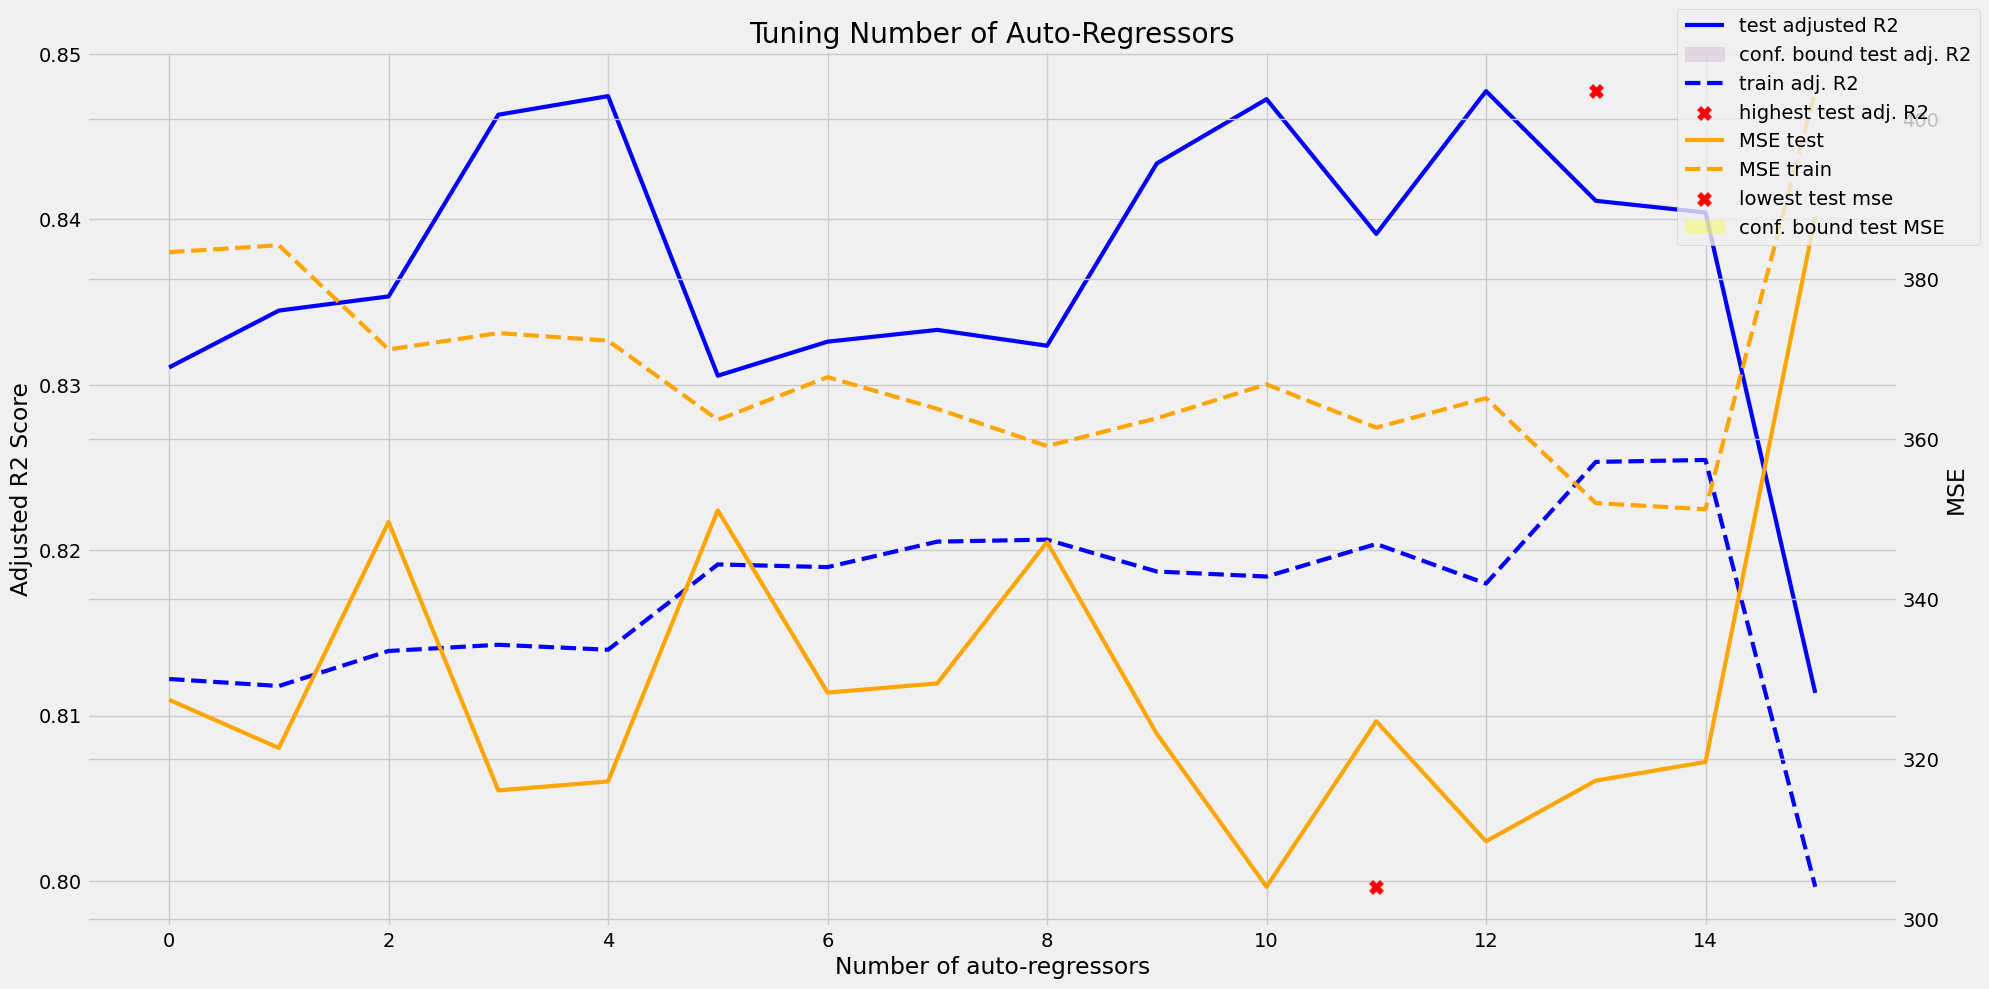

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			13				0.8478			13.7016		309.7347
min MSE:			11				0.8473			9.7387		304.0466
first in range:			1				0.8310			-10.4095		327.4296
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 21 19 18 22 23 25 4 17 45
(140015, 256)
(3050, 6)
Train R2 scores:  0.7885326809719896 0.7795780198899153 0.7763361829742387 0.7819800283938869 0.7837687146878307
Test  R2 scores:  0.7548511230556687 0.7906716034049726 0.8025164137192491 0.7810522755304851 0.7738326865665868
Mean absolute error: train 13.4496, test 12.9154
Mean squared error:  train 317.8354, test 293.1303
Explained Variance Score (best=1): train 0.7763, test 0.8027
Coefficient of determination (R2): train 0.7763, test 0

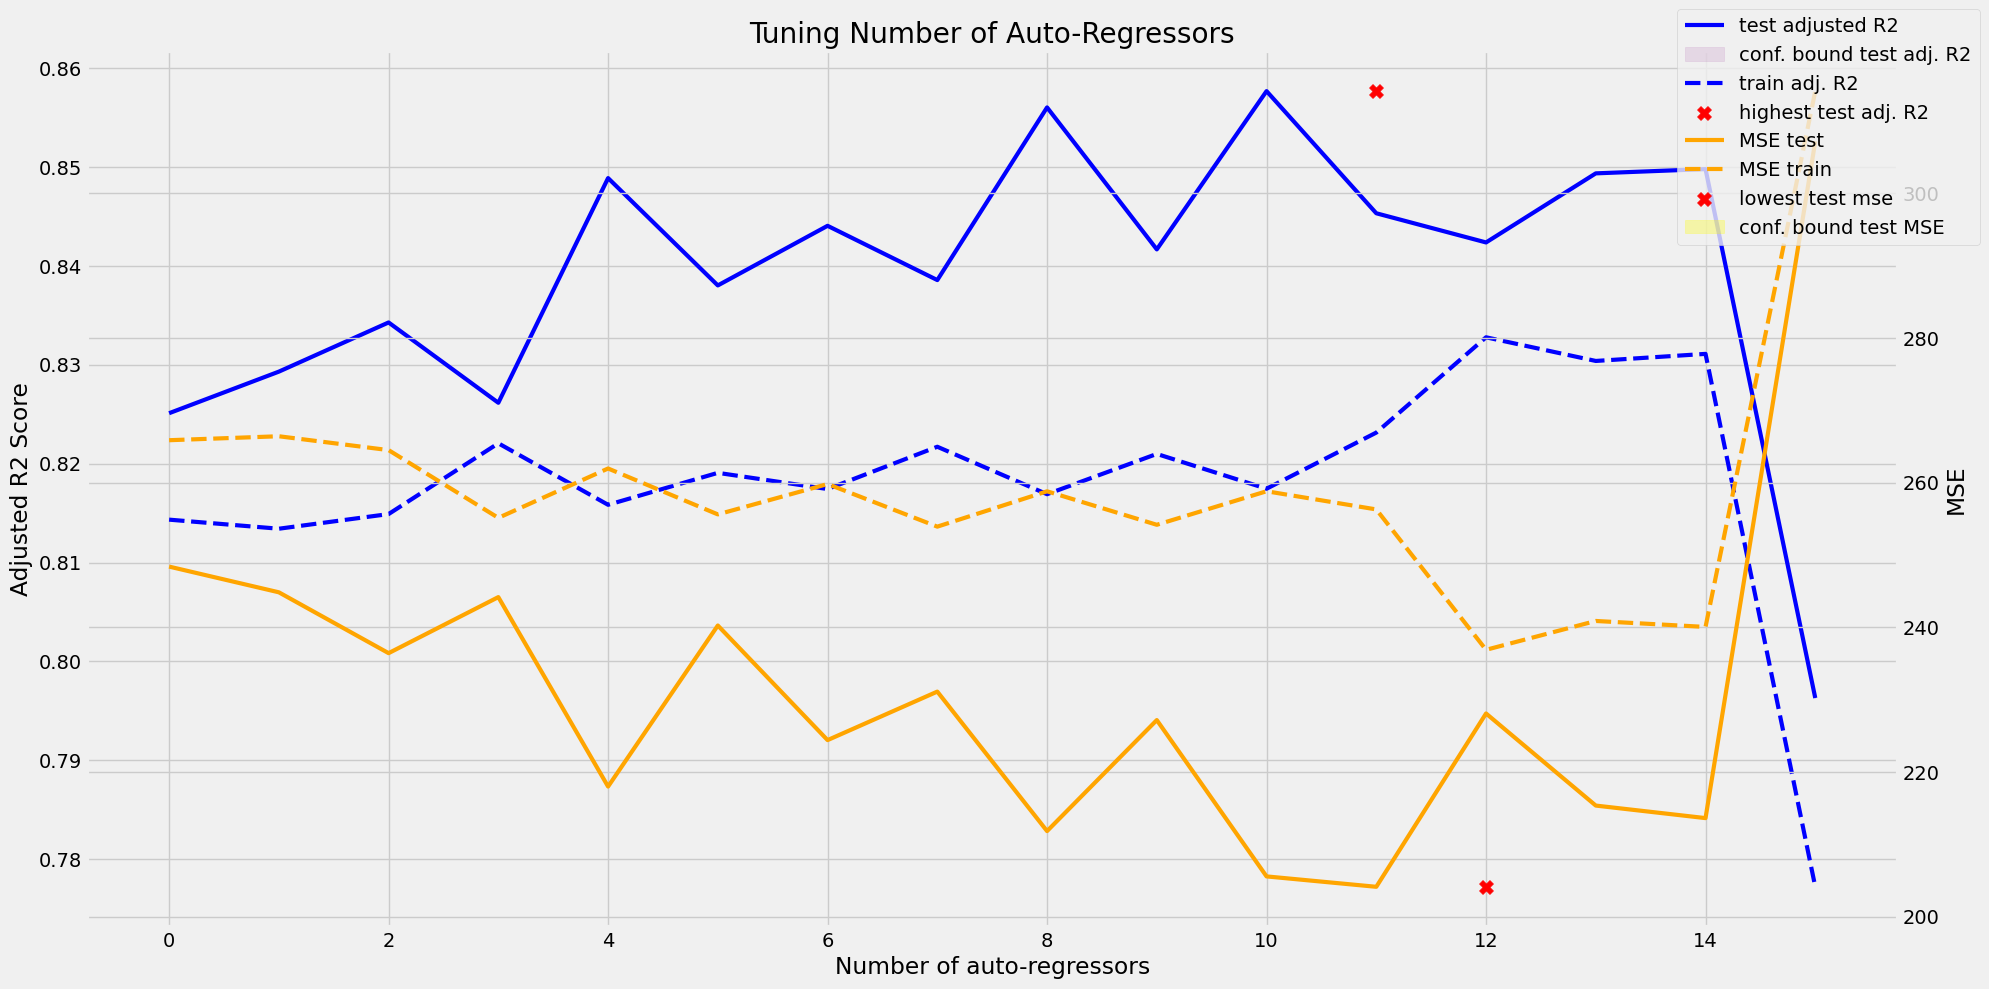

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			11				0.8577			10.5217		205.5510
min MSE:			12				0.8453			12.5357		204.1139
first in range:			5				0.8489			-1.5957		217.9724
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20 19
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 23 4
(140015, 256)
(3050, 6)
Train R2 scores:  0.7724557874937086 0.762770092219571 0.7663099787857139 0.7789895087147961 0.7667242613633345
Test  R2 scores:  0.75564091704824 0.793333626747428 0.7807051607994137 0.7285890879779083 0.7767091579787136
Mean absolute error: train 9.7327, test 9.3472
Mean squared error:  train 176.0817, test 164.6592
Explained Variance Score (best=1): train 0.7628, test 0.7936
Coefficient of determination (R2): train 0.7628, test 0.7

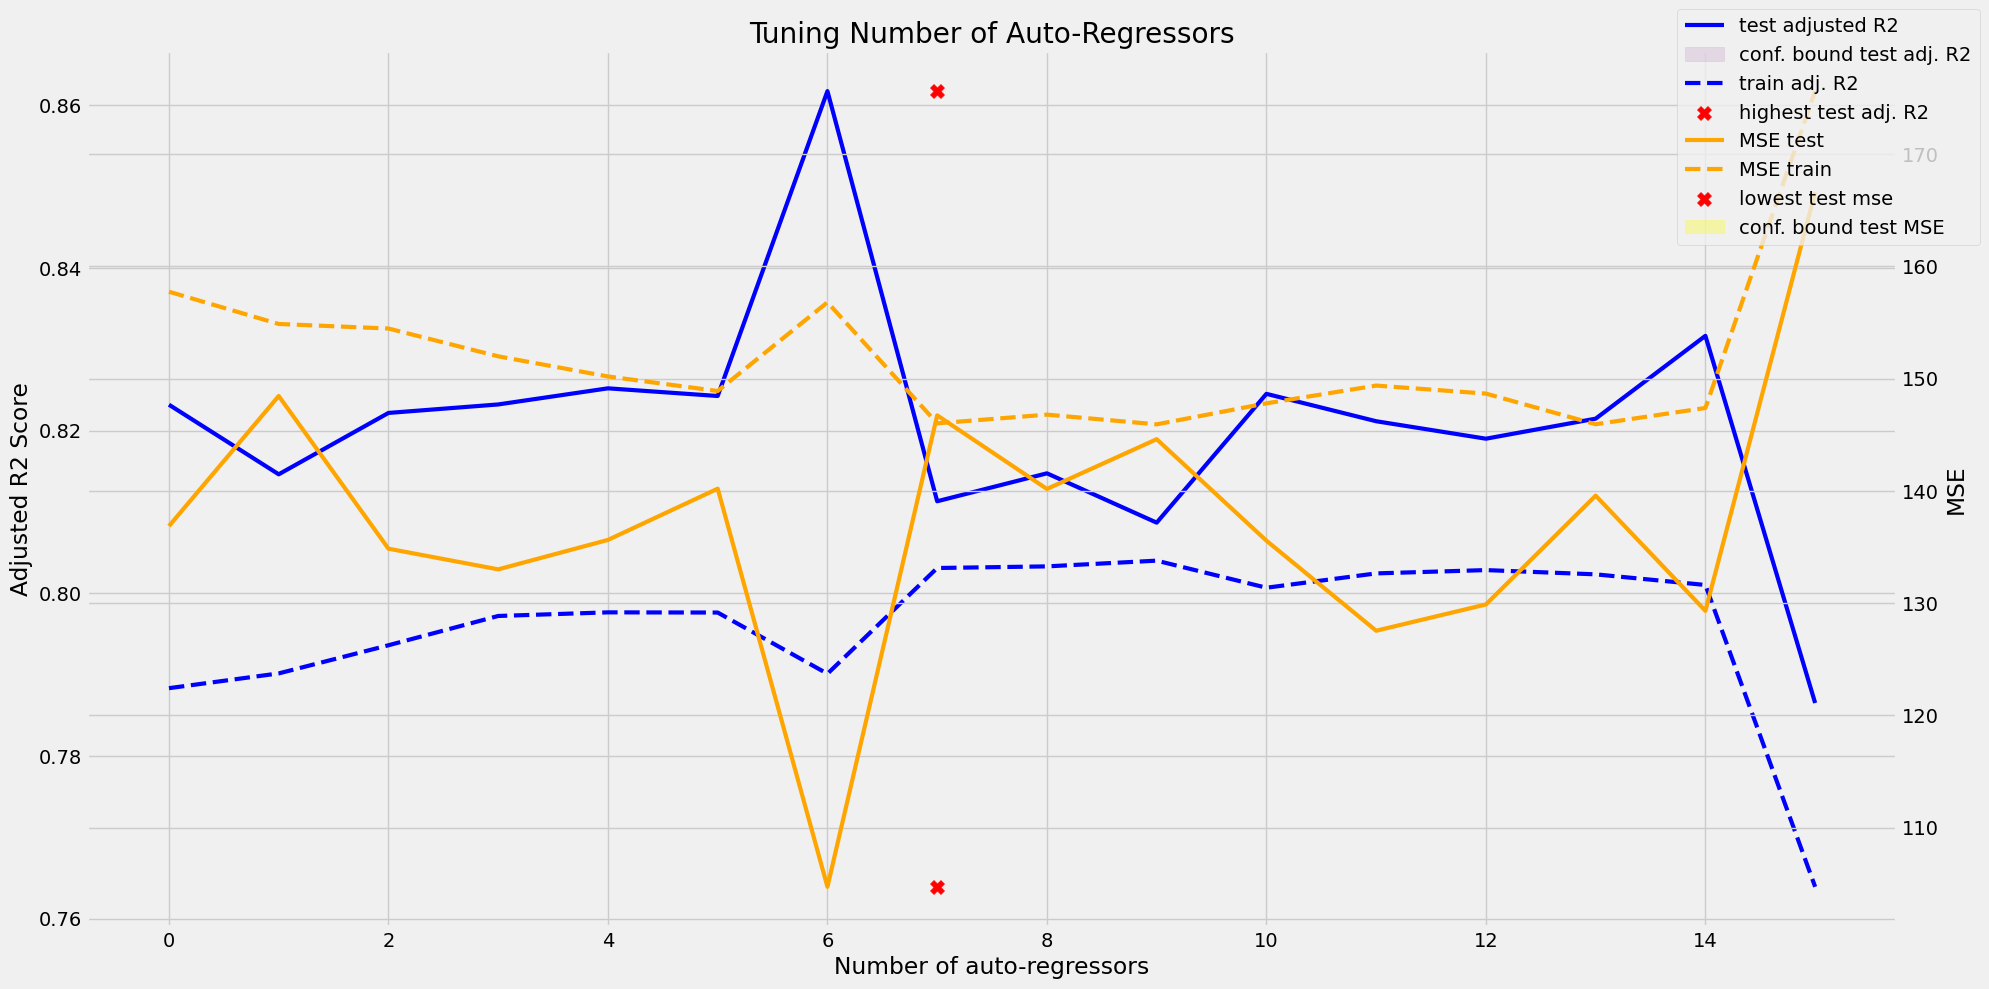

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			7				0.8618			3.8704		104.7232
min MSE:			7				0.8618			3.8704		104.7232
first in range:			7				0.8618			3.8704		104.7232
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 21 20 19 22
[RES] lags by lowest adj r2:  1 2 3 21 20 19 22
(140015, 256)
(3050, 6)
Train R2 scores:  0.7562009930362199 0.767610020953449 0.7594037941227629 0.7726907654457714 0.7669639465902293
Test  R2 scores:  0.7951571013814331 0.752224988429756 0.7830085587817996 0.7295108618171964 0.7528576134378977
Mean absolute error: train 12.6238, test 12.0354
Mean squared error:  train 272.0411, test 243.4236
Explained Variance Score (best=1): train 0.7562, test 0.7953
Coefficient of determination (R2): train 0.7562, test 0.7952
Ad

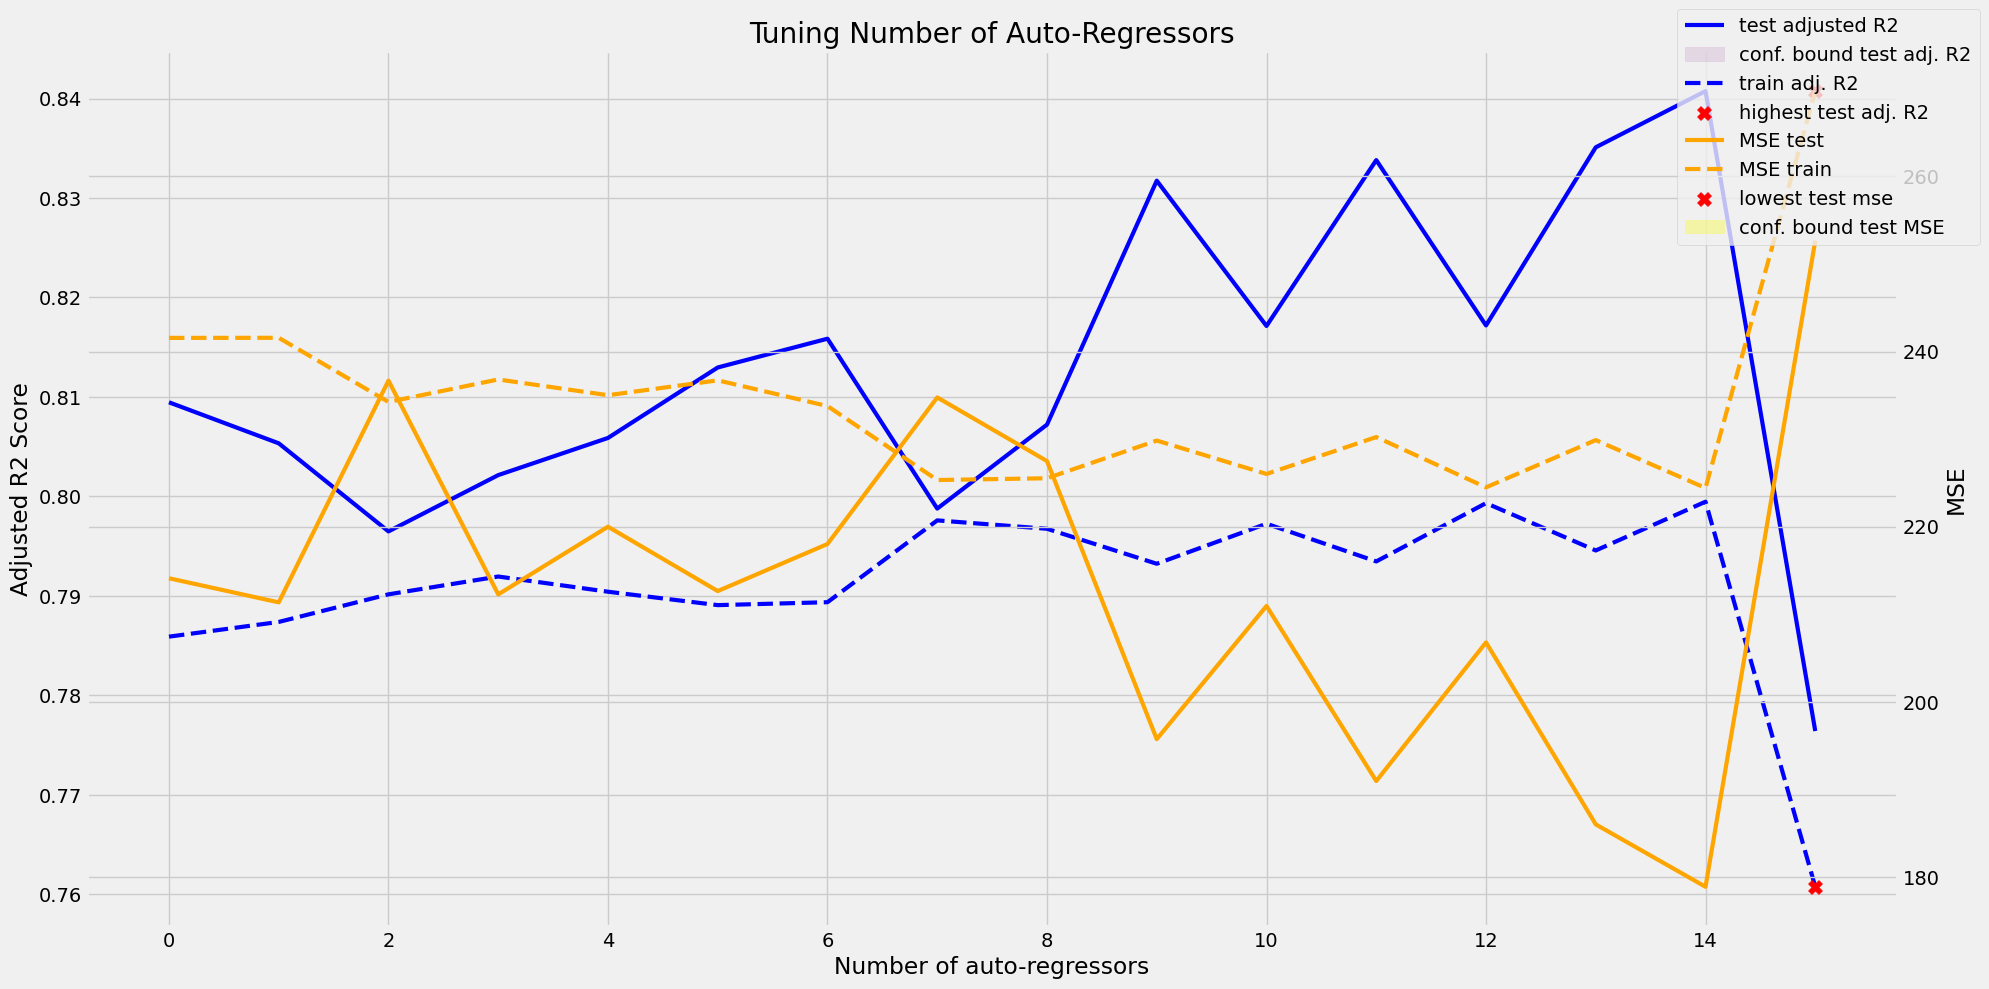

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			15				0.8407			18.7996		178.8832
min MSE:			15				0.8407			18.7996		178.8832
first in range:			10				0.8317			8.6194		195.7462
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20 19 21 18 22 23 25
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 23 25 4 17 47 49 10
(140015, 256)
(3050, 6)
Train R2 scores:  0.7522676803229038 0.7462882950151893 0.746947814662918 0.7487983876945056 0.7461496744003703
Test  R2 scores:  0.7285247387093954 0.7527731207054698 0.7505132912099269 0.74258776086373 0.7543362056719611
Mean absolute error: train 12.3144, test 11.7905
Mean squared error:  train 248.9082, test 231.1844
Explained Variance Score (best=1): train 0.7461, test 0.7545
Coefficient of determinatio

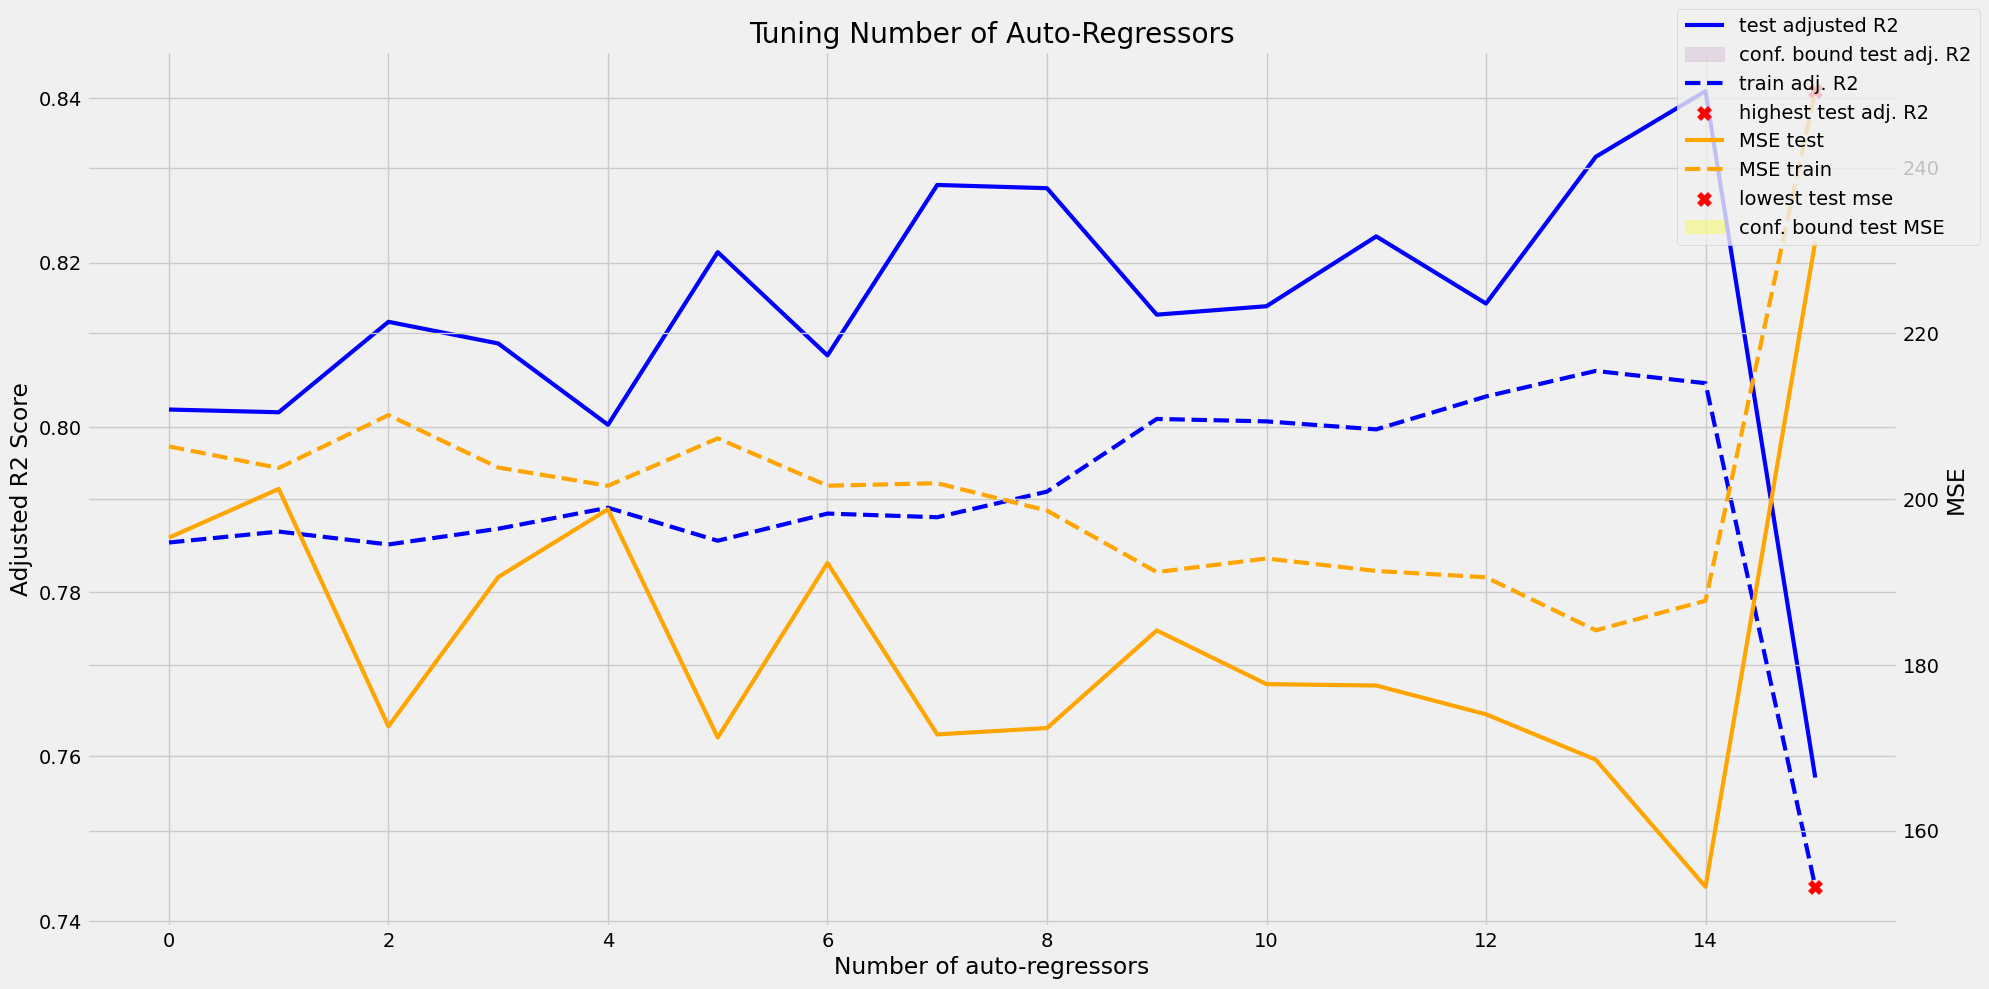

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			15				0.8408			19.1093		153.2190
min MSE:			15				0.8408			19.1093		153.2190
first in range:			15				0.8408			19.1093		153.2190
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 19 20 18 21 22 23 25 4 17 47 10 49
[RES] lags by lowest adj r2:  1 2 3 19 20 18 21 22 23 25 4 17 47 10 49
(140015, 256)
(3050, 6)
Train R2 scores:  0.760345908992775 0.7661720916976389 0.763474798945763 0.7663451074104519 0.762449587447815
Test  R2 scores:  0.7763333114704267 0.7521675049229007 0.763841438198762 0.7520439114376122 0.7675564652449787
Mean absolute error: train 9.3634, test 8.9782
Mean squared error:  train 165.4535, test 151.1477
Explained Variance Score (best=1): train 0.7603, test 0.7764
Coefficient of 

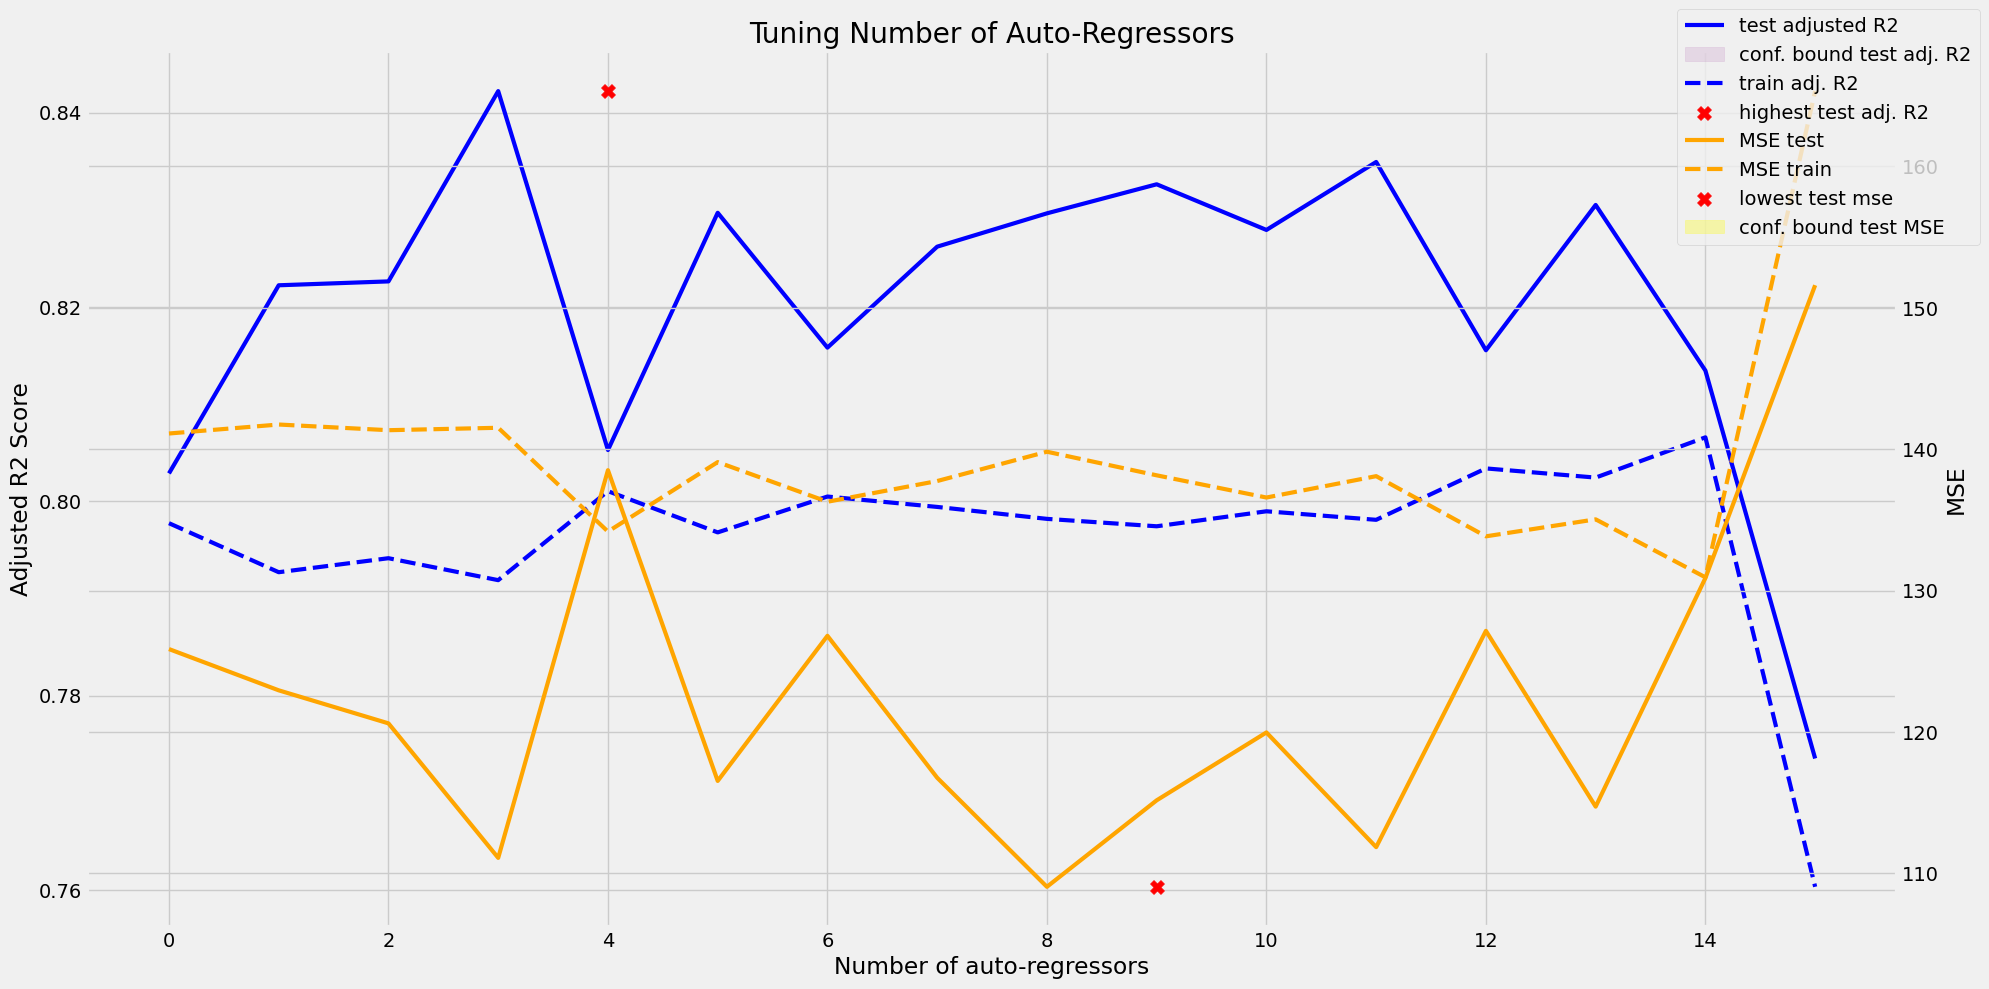

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			4				0.8422			-2.2477		111.0934
min MSE:			9				0.8296			7.7895		109.0469
first in range:			4				0.8422			-2.2477		111.0934
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 21
[RES] lags by lowest adj r2:  1 2 3 21
(140015, 256)
(3050, 6)
Train R2 scores:  0.7868147021144277 0.7826621327963716 0.7781762174587212 0.780414184531591 0.785746764500474
Test  R2 scores:  0.7632426675844354 0.7816915083798195 0.7984302646021278 0.7912451102818401 0.7691715996593018
Mean absolute error: train 15.8211, test 15.5656
Mean squared error:  train 437.9034, test 412.2160
Explained Variance Score (best=1): train 0.7782, test 0.7987
Coefficient of determination (R2): train 0.7782, test 0.7984
Adjusted coeff. of

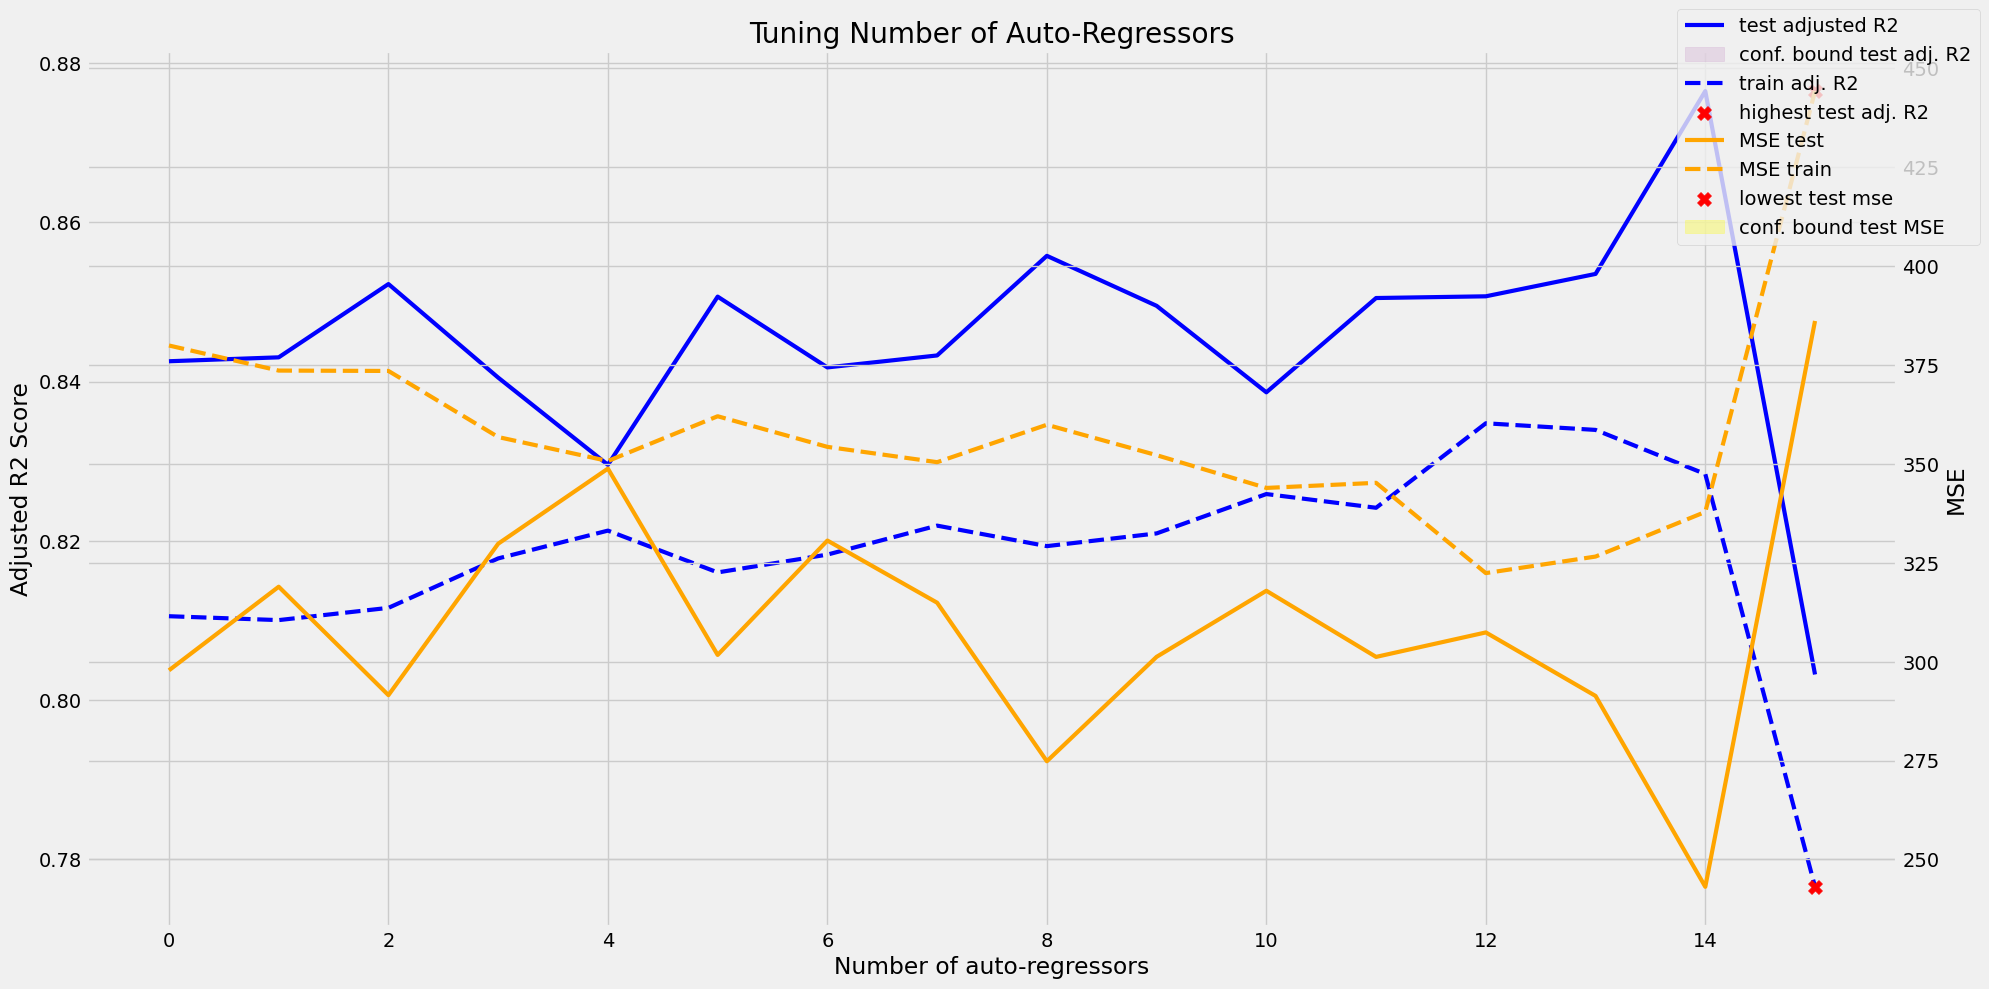

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			15				0.8765			18.1862		243.0966
min MSE:			15				0.8765			18.1862		243.0966
first in range:			15				0.8765			18.1862		243.0966
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20 19 21 18 22 17 23 25 4 10 9 45
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 23 25 4 10 9 45
(140015, 256)
(3050, 6)
Train R2 scores:  0.8121813207957673 0.818815322374802 0.8194977500139251 0.8117906975628983 0.81585450237387
Test  R2 scores:  0.8264594365997598 0.8027729846367985 0.7992200847881985 0.8296465186992343 0.8141785297530949
Mean absolute error: train 11.1186, test 10.4754
Mean squared error:  train 264.2095, test 239.3365
Explained Variance Score (best=1): train 0.8118, test 0.8299
Coefficient of

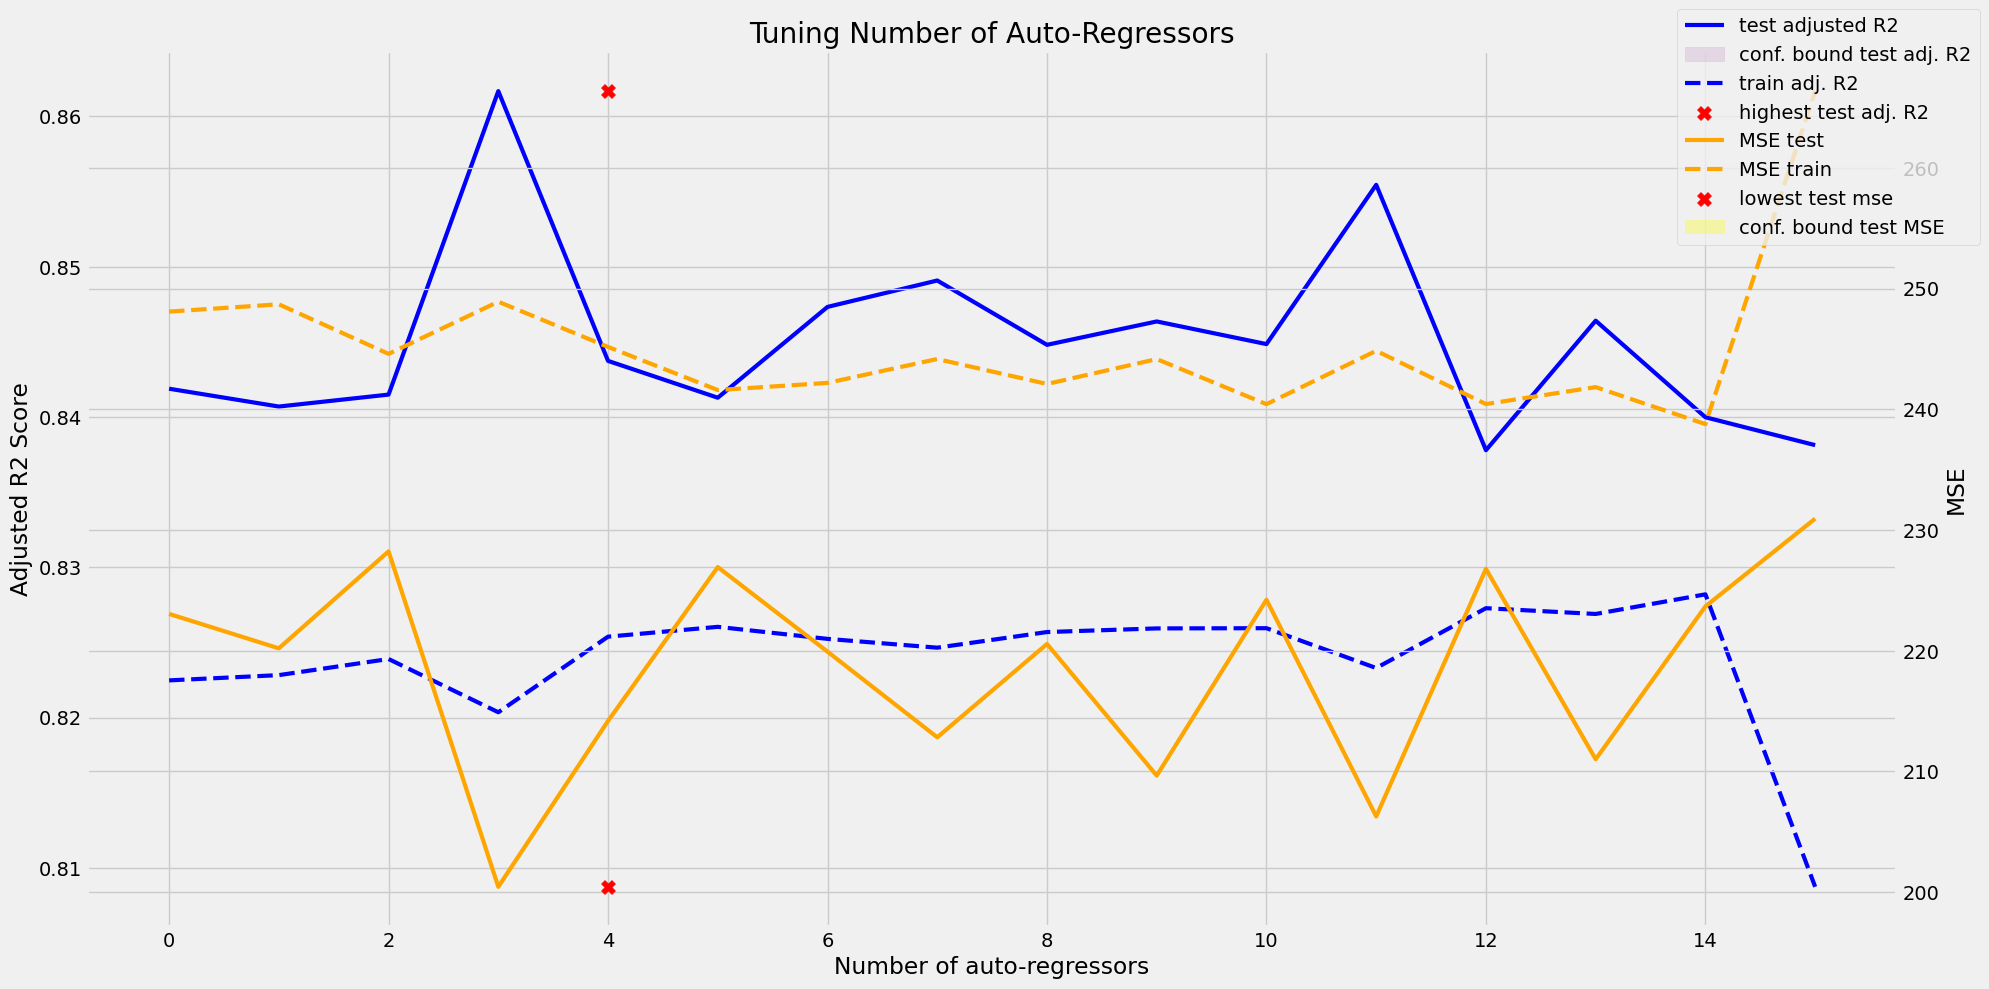

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			4				0.8617			-3.4280		200.4449
min MSE:			4				0.8617			-3.4280		200.4449
first in range:			2				0.8407			-7.6160		220.1992
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2
[RES] lags by lowest adj r2:  1 2 3 20
(140015, 256)
(3050, 6)
Train R2 scores:  0.7825958260944597 0.7845329887044429 0.7795545638748796 0.7870362728542769 0.7916649952730391
Test  R2 scores:  0.7928301734754808 0.7858381411892575 0.8040865632693447 0.7752140053220378 0.7552613952434667
Mean absolute error: train 7.3808, test 7.1139
Mean squared error:  train 106.4557, test 99.3933
Explained Variance Score (best=1): train 0.7796, test 0.8046
Coefficient of determination (R2): train 0.7796, test 0.8041
Adjusted coeff. of dete

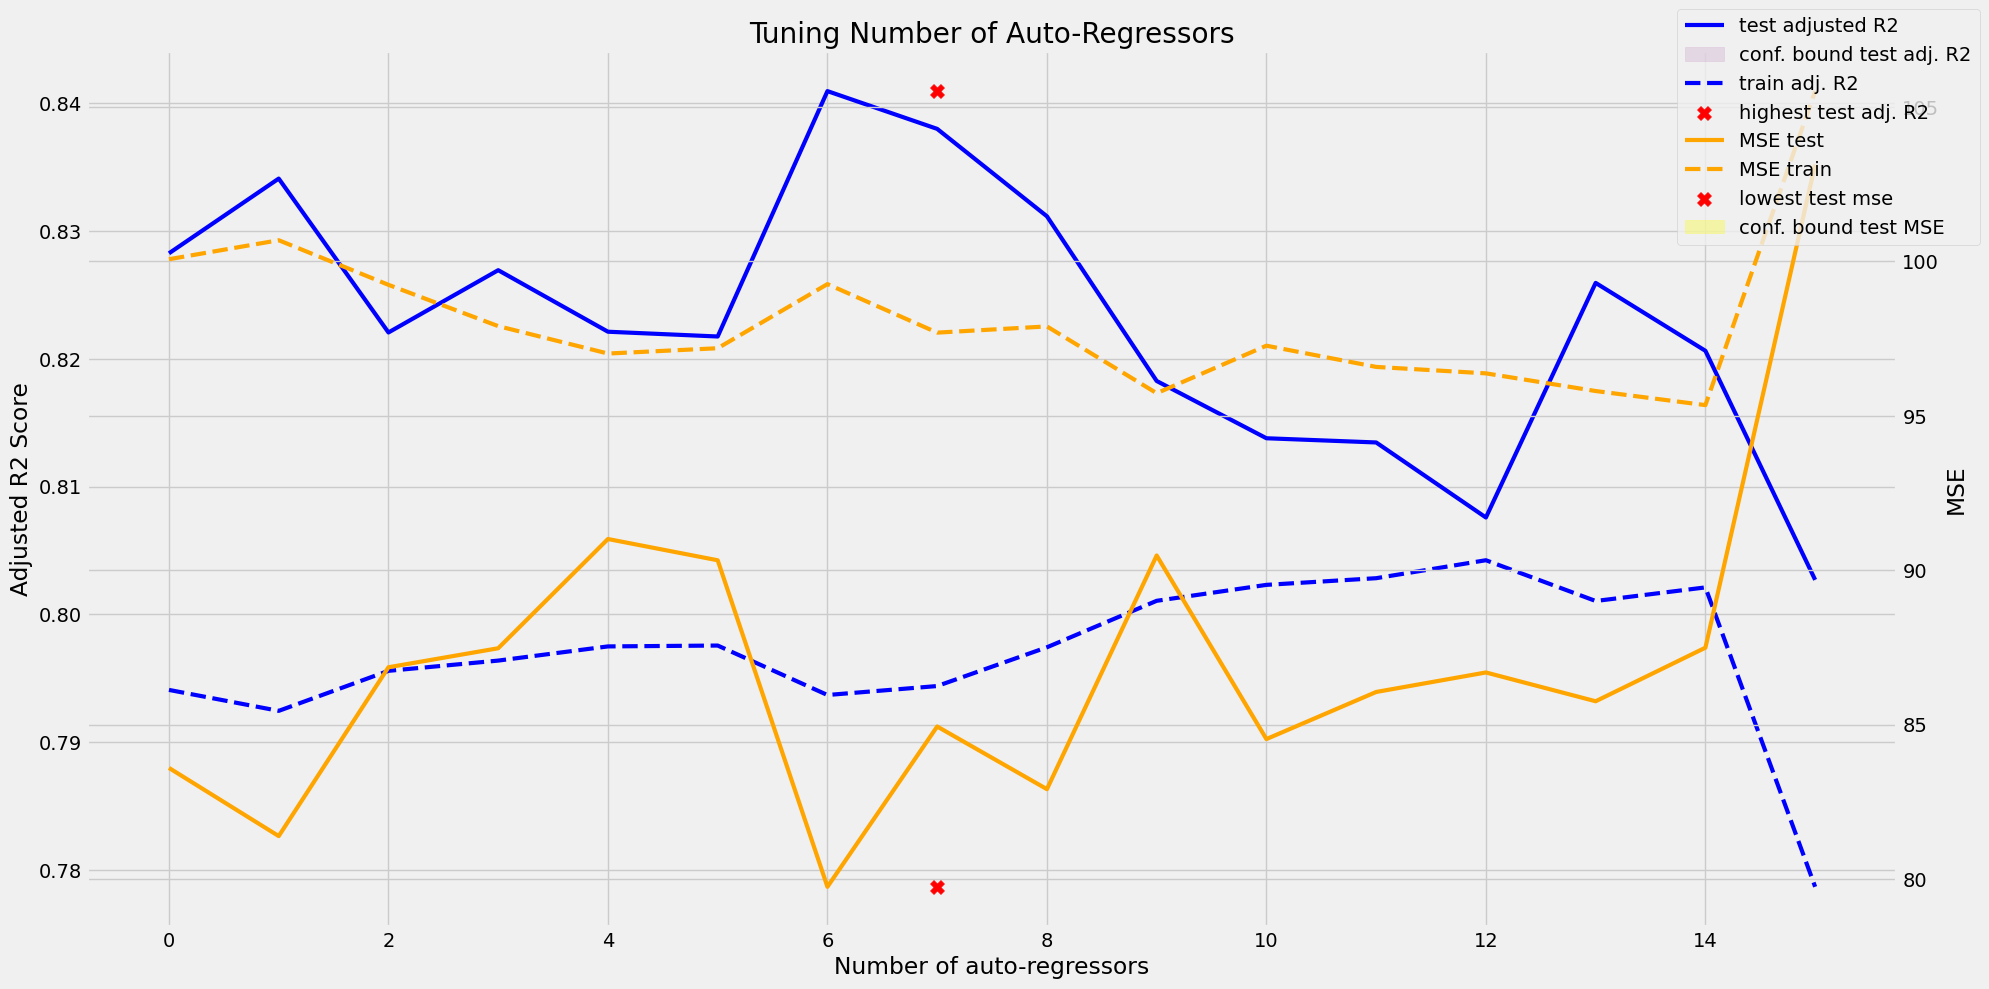

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			7				0.8409			4.4155		79.7431
min MSE:			7				0.8409			4.4155		79.7431
first in range:			1				0.8282			-7.6789		83.5937
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 21 19 18
(140015, 256)
(3050, 6)
Train R2 scores:  0.7442845679726856 0.7353230720796151 0.7432038118561193 0.7309681907745087 0.731327859659143
Test  R2 scores:  0.7060171935635231 0.7423331016389302 0.7092337704688718 0.759955121101345 0.7569651957744612
Mean absolute error: train 8.4424, test 7.8367
Mean squared error:  train 130.1025, test 115.3800
Explained Variance Score (best=1): train 0.7310, test 0.7618
Coefficient of determination (R2): train 0.7310, test 0.7600
Adjusted coeff. of det

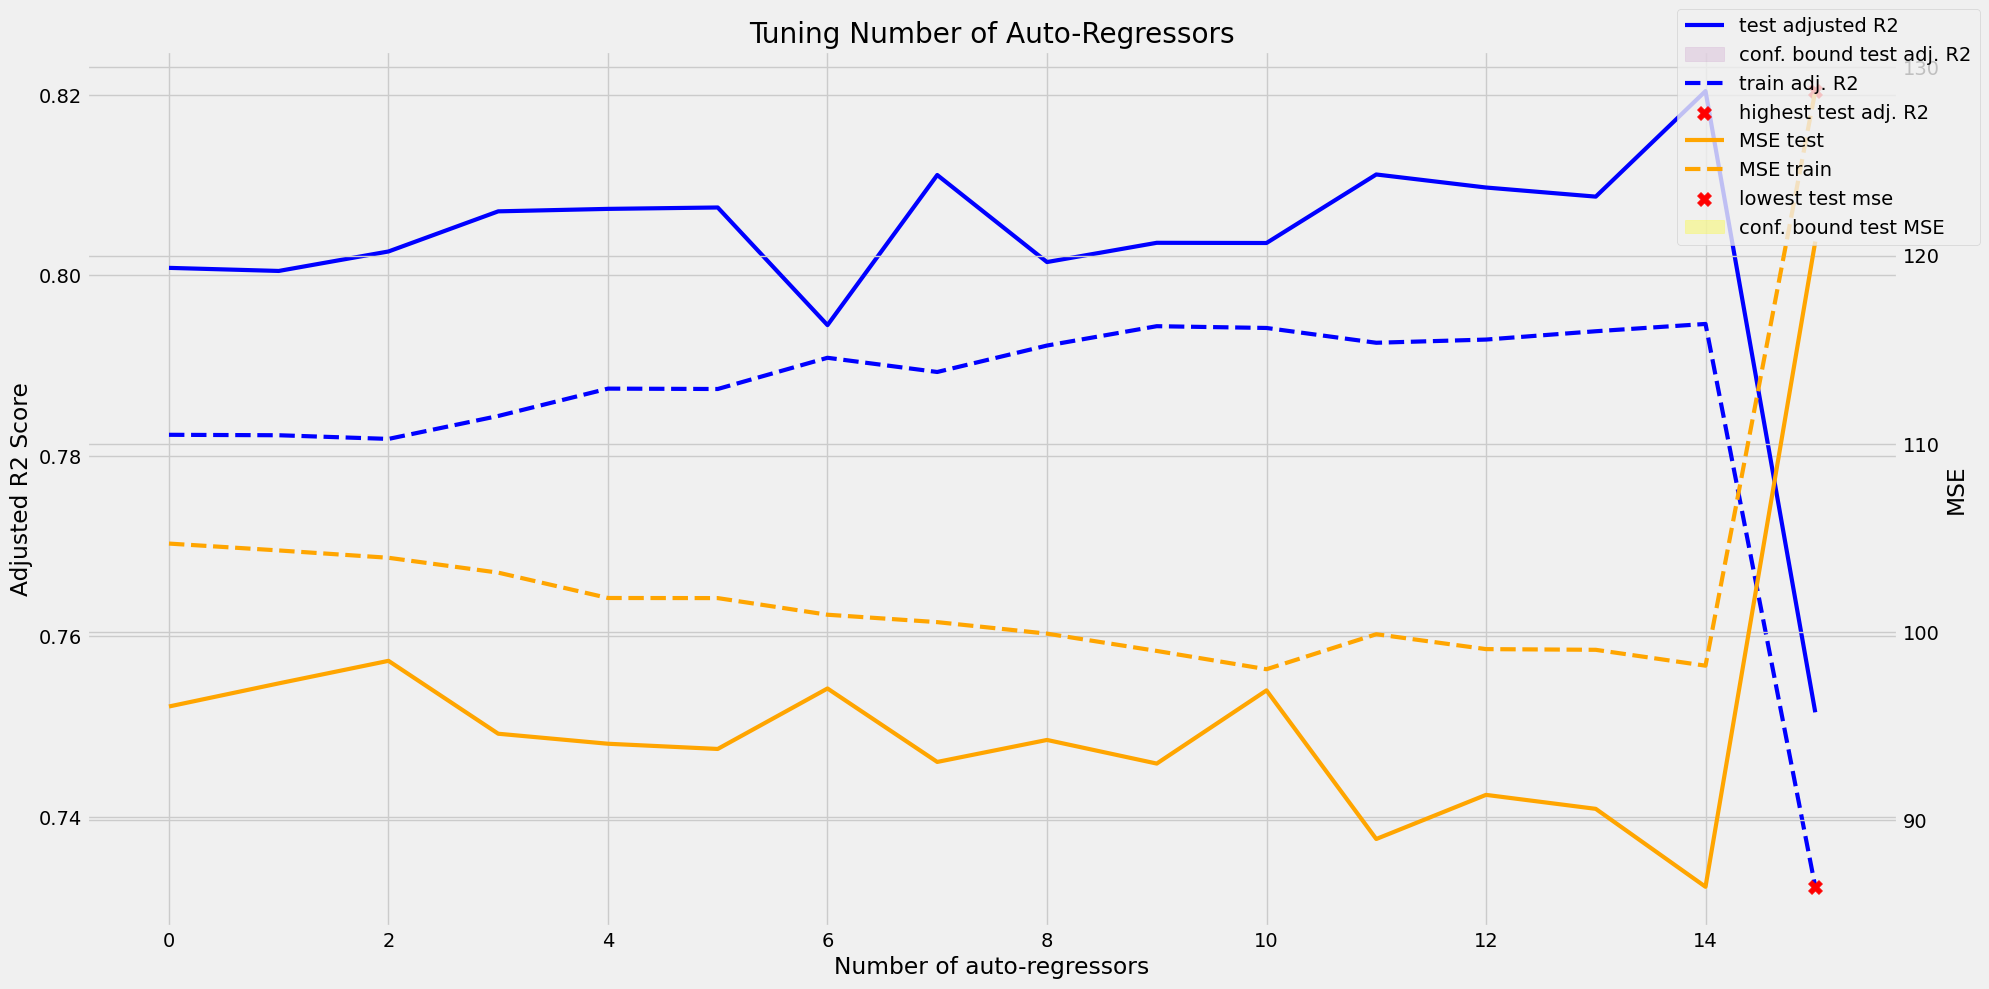

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			15				0.8204			20.2536		86.4669
min MSE:			15				0.8204			20.2536		86.4669
first in range:			4				0.8071			-1.9262		94.5974
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 22
[RES] lags by lowest adj r2:  1 2 3 22 19 18 21 20 23 25 17 4 47 46 11
(140015, 256)
(3050, 6)
Train R2 scores:  0.7459099751043852 0.7416906930341707 0.7524382145224965 0.7504302091160707 0.7528650928044254
Test  R2 scores:  0.7586930068315512 0.773038987108785 0.7320269785196014 0.739959142664133 0.7308419464448258
Mean absolute error: train 10.7221, test 10.4007
Mean squared error:  train 206.6875, test 192.4890
Explained Variance Score (best=1): train 0.7417, test 0.7741
Coefficient of determination (R2): train 0.7417

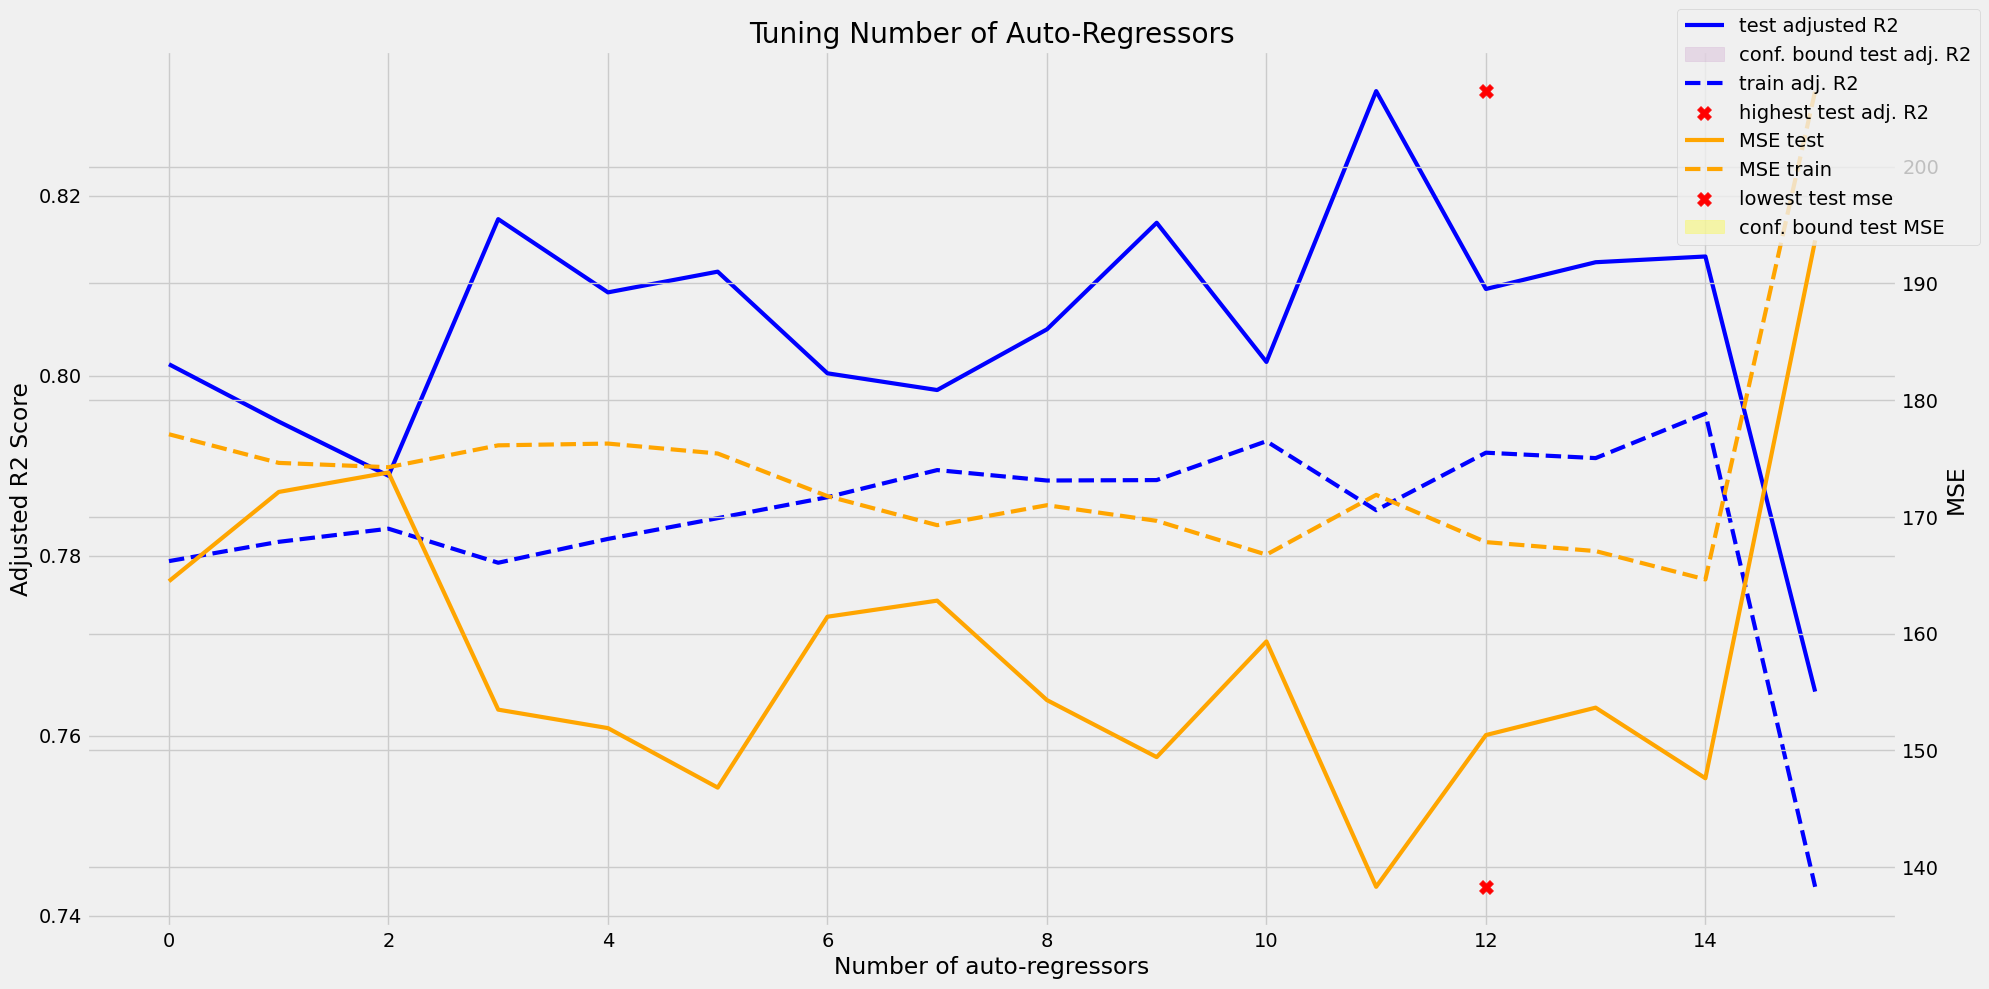

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			12				0.8316			13.3142		138.3027
min MSE:			12				0.8316			13.3142		138.3027
first in range:			5				0.8092			-0.8733		151.8965
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 19 18
[RES] lags by lowest adj r2:  1 2 3 19 18 20 22 23 21 25 17 4
(140015, 256)
(3050, 6)
Train R2 scores:  0.7668577633163156 0.7602368802595838 0.7558571848478628 0.7713326414160289 0.7620543539771962
Test  R2 scores:  0.7489816153833708 0.7742039202111786 0.7917155633687492 0.7253262280637913 0.7665685960194747
Mean absolute error: train 5.7800, test 5.4187
Mean squared error:  train 55.0947, test 47.1259
Explained Variance Score (best=1): train 0.7559, test 0.7922
Coefficient of determination (R2): train 0.7559, tes

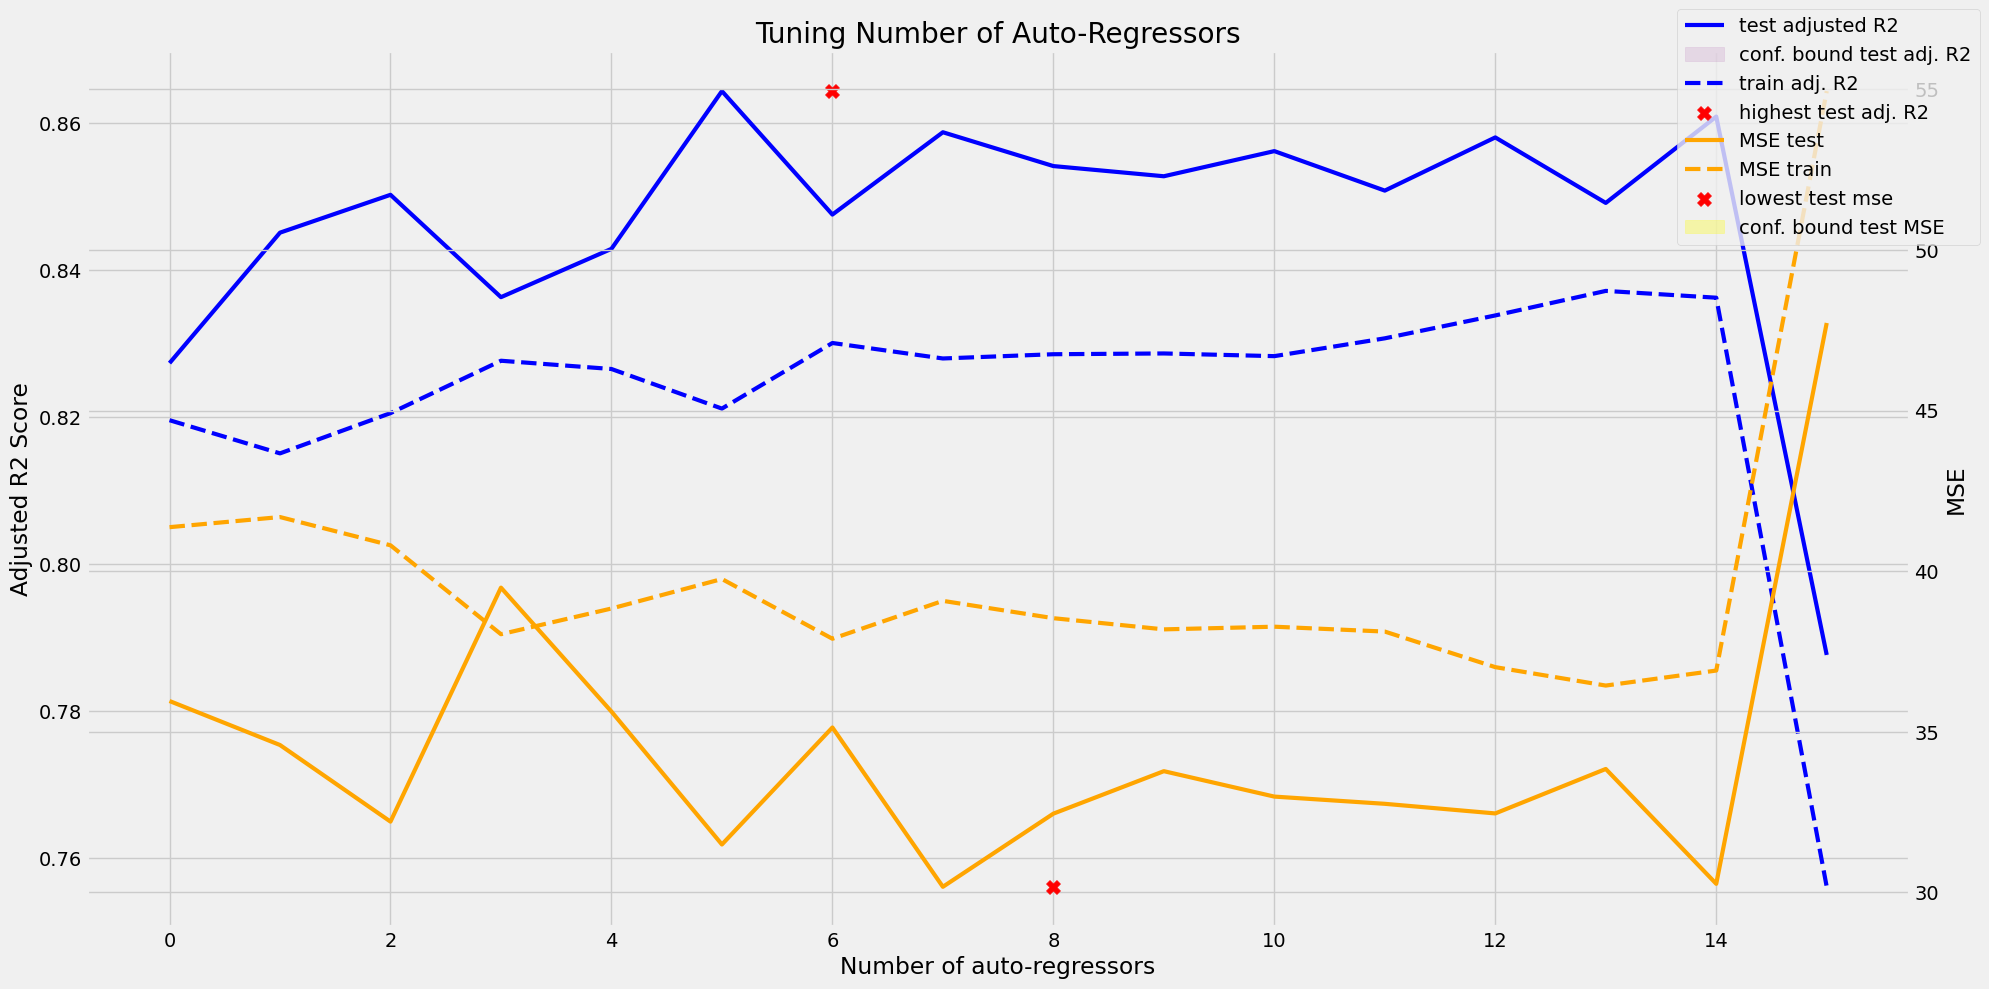

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			6				0.8644			4.2738		31.4892
min MSE:			8				0.8588			8.3593		30.1716
first in range:			3				0.8503			-1.7709		32.2013
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3
[RES] lags by lowest adj r2:  1 2 3 20 21 19
(140015, 256)
(3050, 6)
Train R2 scores:  0.7575941868404097 0.764894981865107 0.7541008944936157 0.7602698745700616 0.7650783220424823
Test  R2 scores:  0.7684554223480238 0.7402344808120258 0.7858006467900025 0.7587358839753243 0.7409526662652828
Mean absolute error: train 10.8917, test 10.3378
Mean squared error:  train 233.2950, test 191.6992
Explained Variance Score (best=1): train 0.7541, test 0.7862
Coefficient of determination (R2): train 0.7541, test 0.7858
Adjusted coeff. of

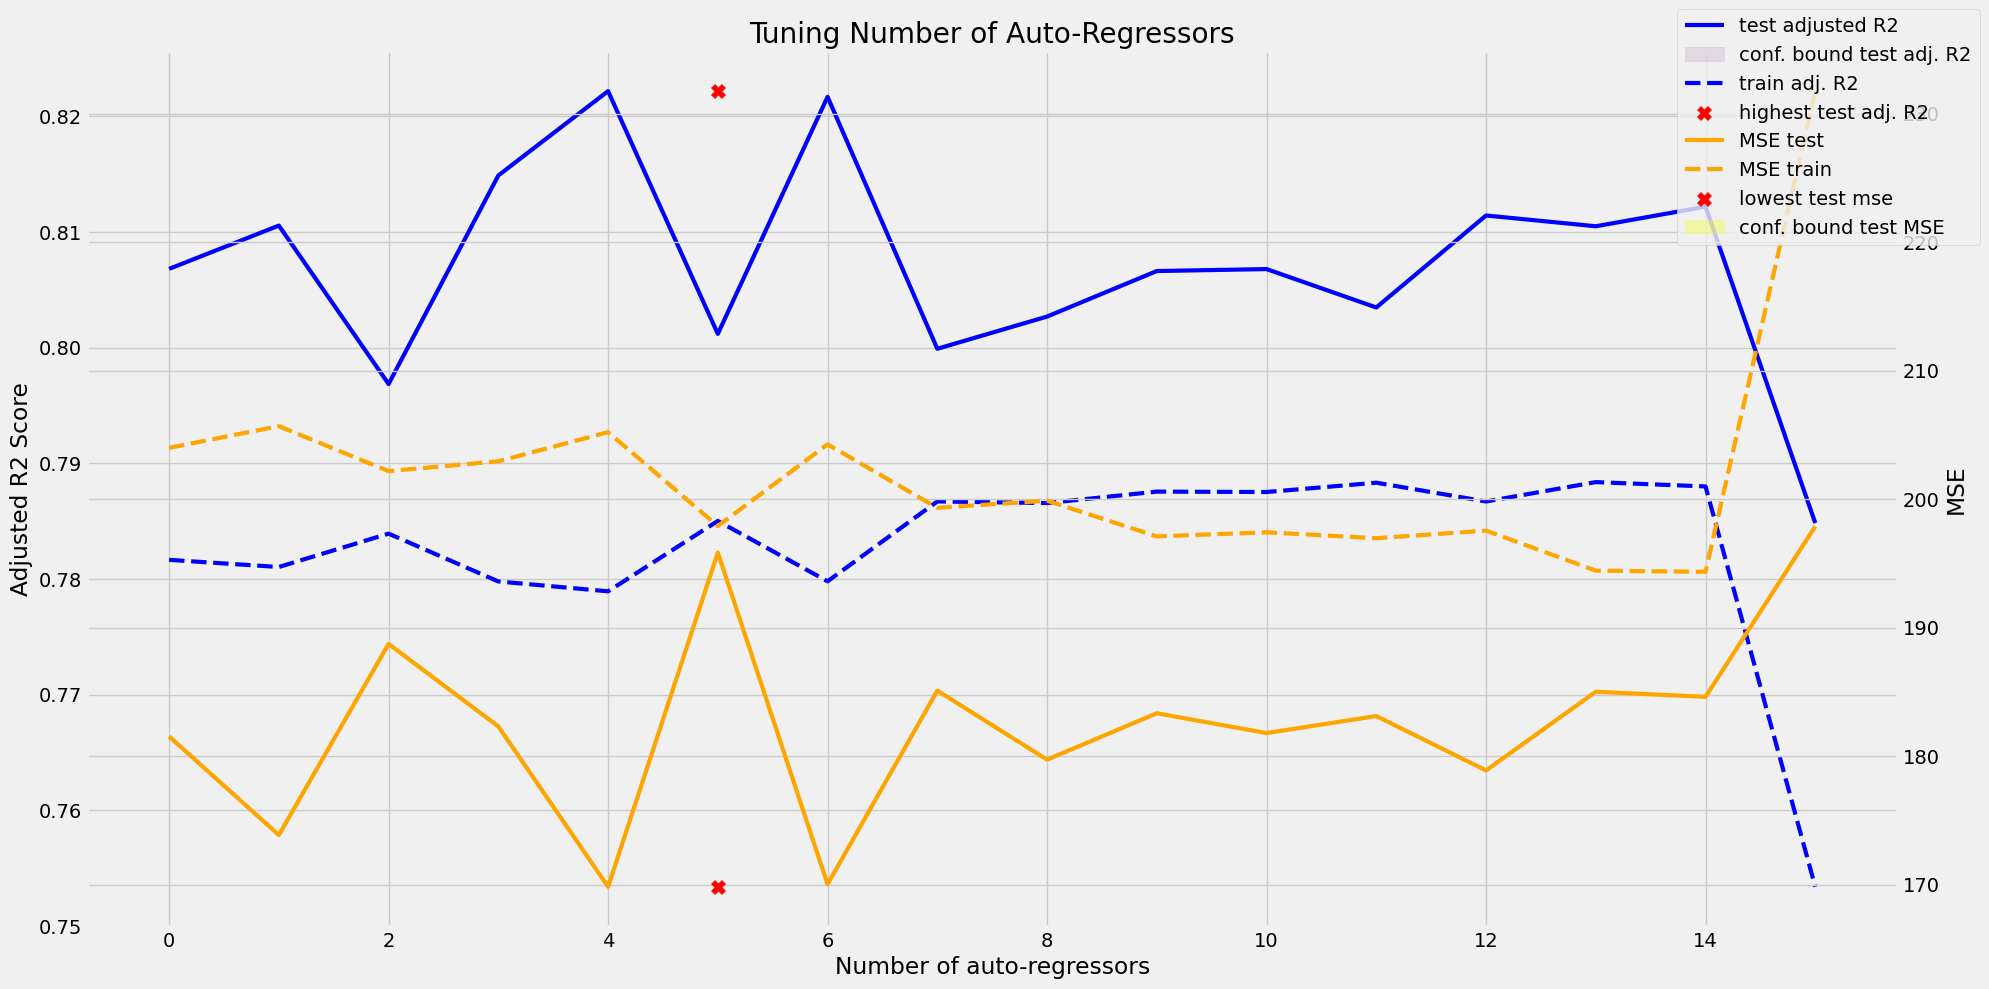

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			5				0.8222			-1.0964		169.8246
min MSE:			5				0.8222			-1.0964		169.8246
first in range:			1				0.8068			-9.2298		181.5294
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 21
(140015, 256)
(3050, 6)
Train R2 scores:  0.74892407146474 0.7503443790240399 0.7565177675441797 0.7447721573641142 0.7494321019848111
Test  R2 scores:  0.752214486634858 0.745640753608645 0.7206009897169716 0.7690650790658873 0.7508205779347712
Mean absolute error: train 9.2430, test 8.9052
Mean squared error:  train 158.0835, test 143.6903
Explained Variance Score (best=1): train 0.7448, test 0.7691
Coefficient of determination (R2): train 0.7448, test 0.7691
Adjusted coeff. of determ

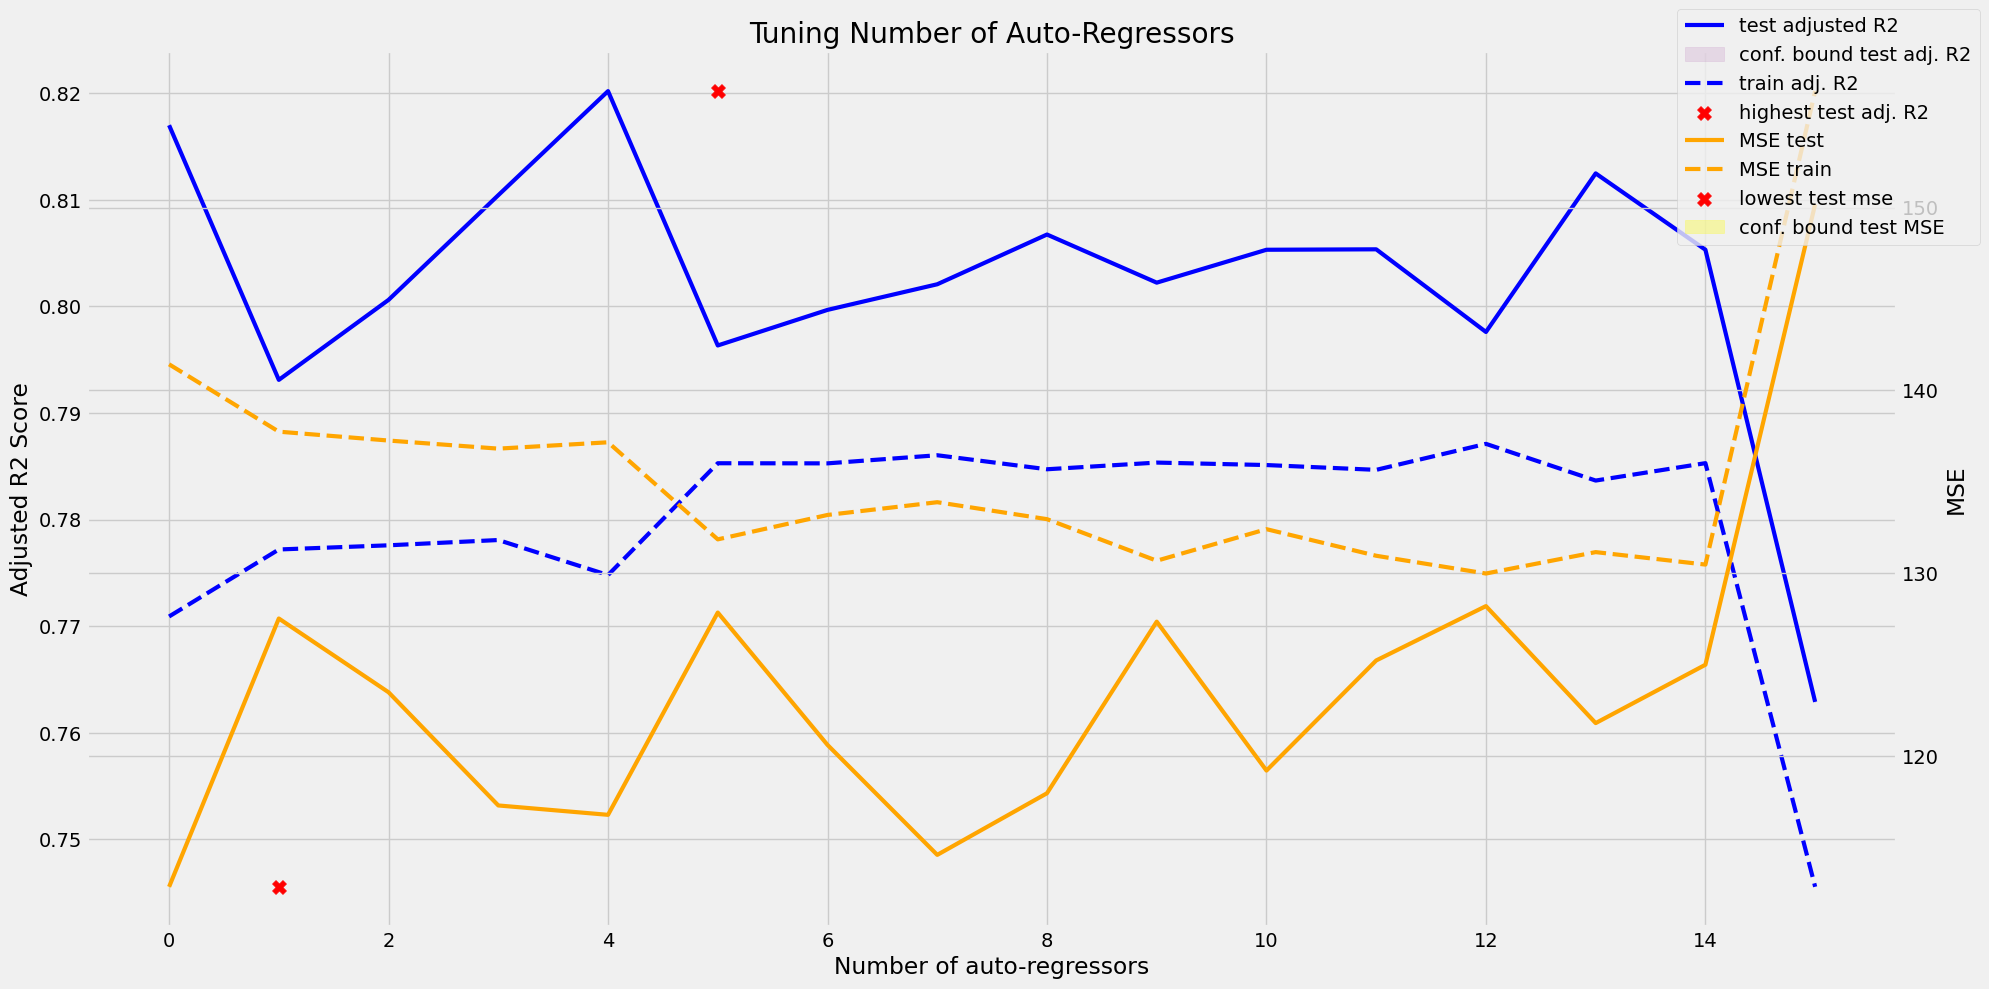

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			5				0.8202			-0.3474		116.7726
min MSE:			1				0.8170			-8.2788		112.8351
first in range:			1				0.8170			-8.2788		112.8351
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 22 21
(140015, 256)
(3050, 6)
Train R2 scores:  0.7594353287370432 0.7622827000597079 0.7557223018799714 0.7535957502058359 0.7575548978436619
Test  R2 scores:  0.7489779231014033 0.7370261934119874 0.764227365429077 0.7718979886531951 0.7568293405207329
Mean absolute error: train 6.4315, test 6.3510
Mean squared error:  train 77.3176, test 74.3413
Explained Variance Score (best=1): train 0.7536, test 0.7720
Coefficient of determination (R2): train 0.7536, test 0.7719
Adjusted coeff. of deter

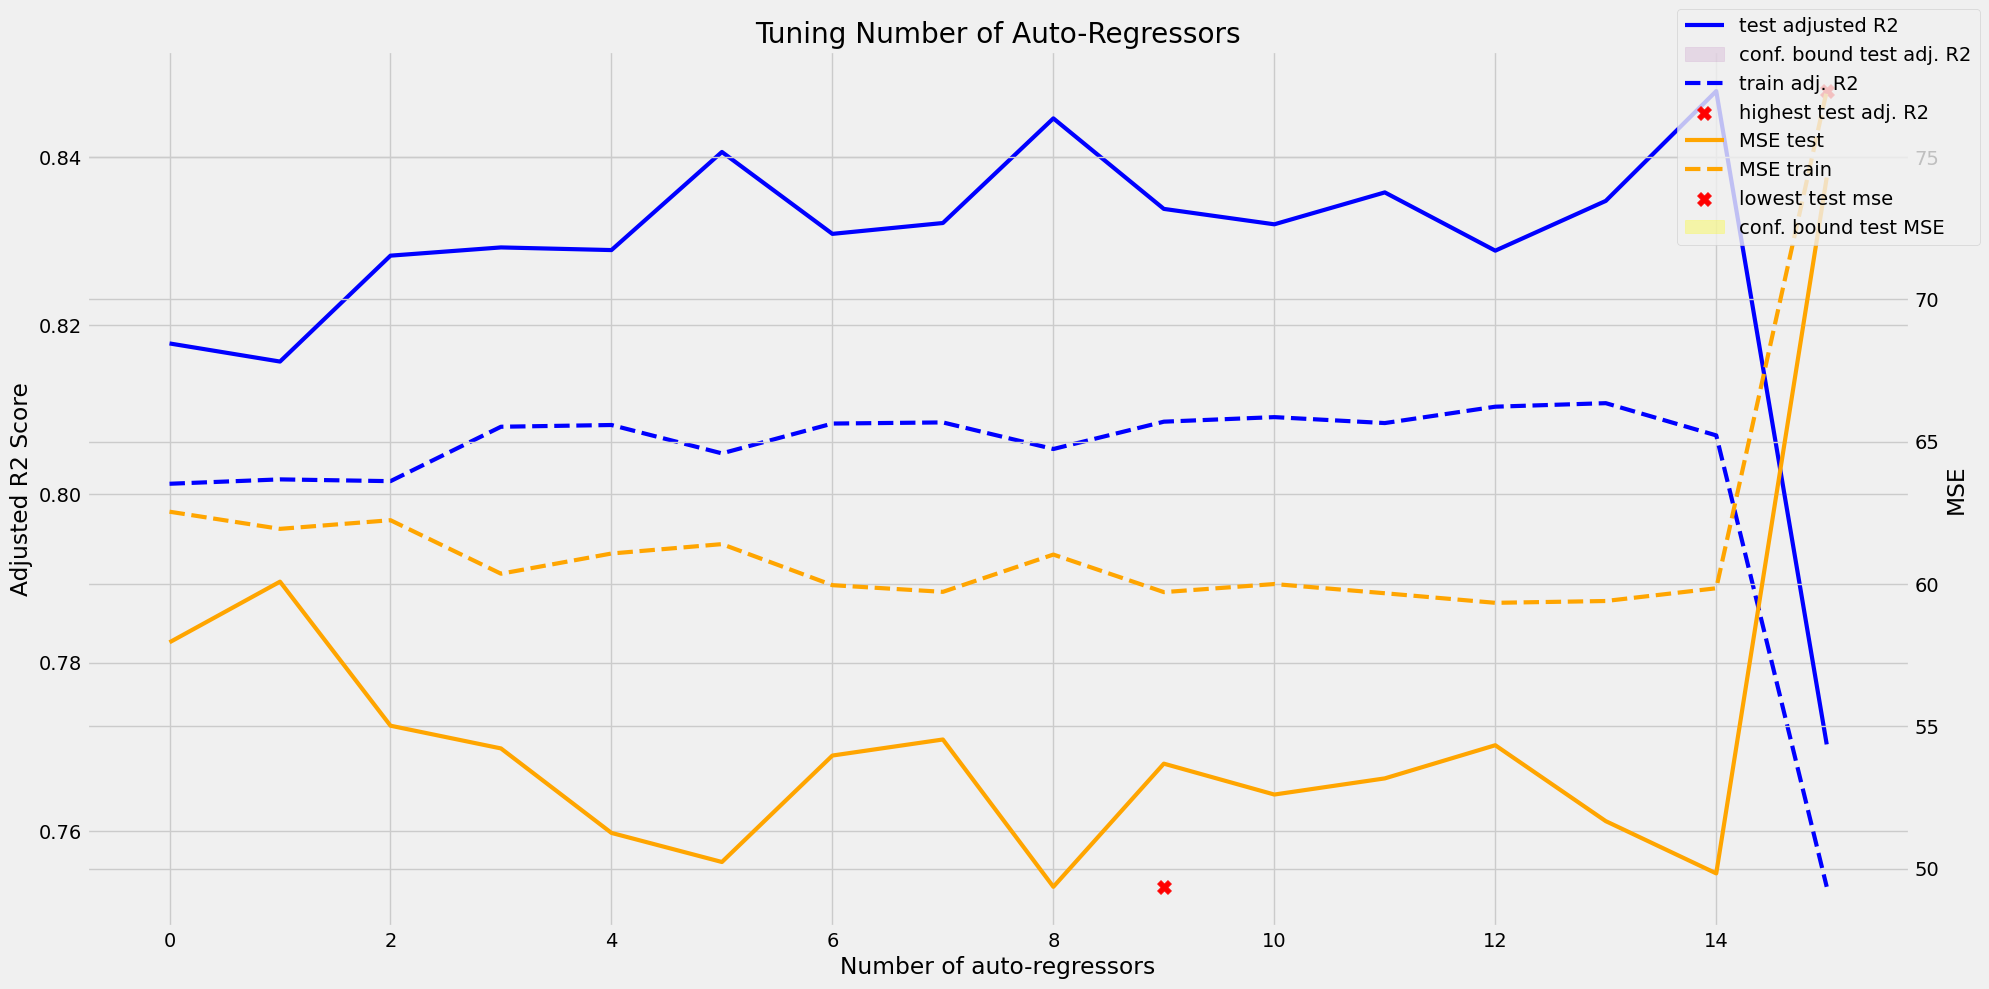

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			15				0.8478			21.3558		49.8307
min MSE:			9				0.8446			9.3748		49.3598
first in range:			4				0.8292			-0.8130		54.2200
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20
[RES] lags by lowest adj r2:  1 2 3 20 21 19 22 18 17 4 23 25 45 11 46
(140015, 256)
(3050, 6)
Train R2 scores:  0.785160348881796 0.7799157980844333 0.7851288429056271 0.7818017298138558 0.7841691351888953
Test  R2 scores:  0.7745511760411359 0.7955154033217684 0.774888741457711 0.7866103161723474 0.7786751296606528
Mean absolute error: train 9.8136, test 9.5827
Mean squared error:  train 185.2177, test 168.1772
Explained Variance Score (best=1): train 0.7799, test 0.7957
Coefficient of determination (R2): train 0.7799, te

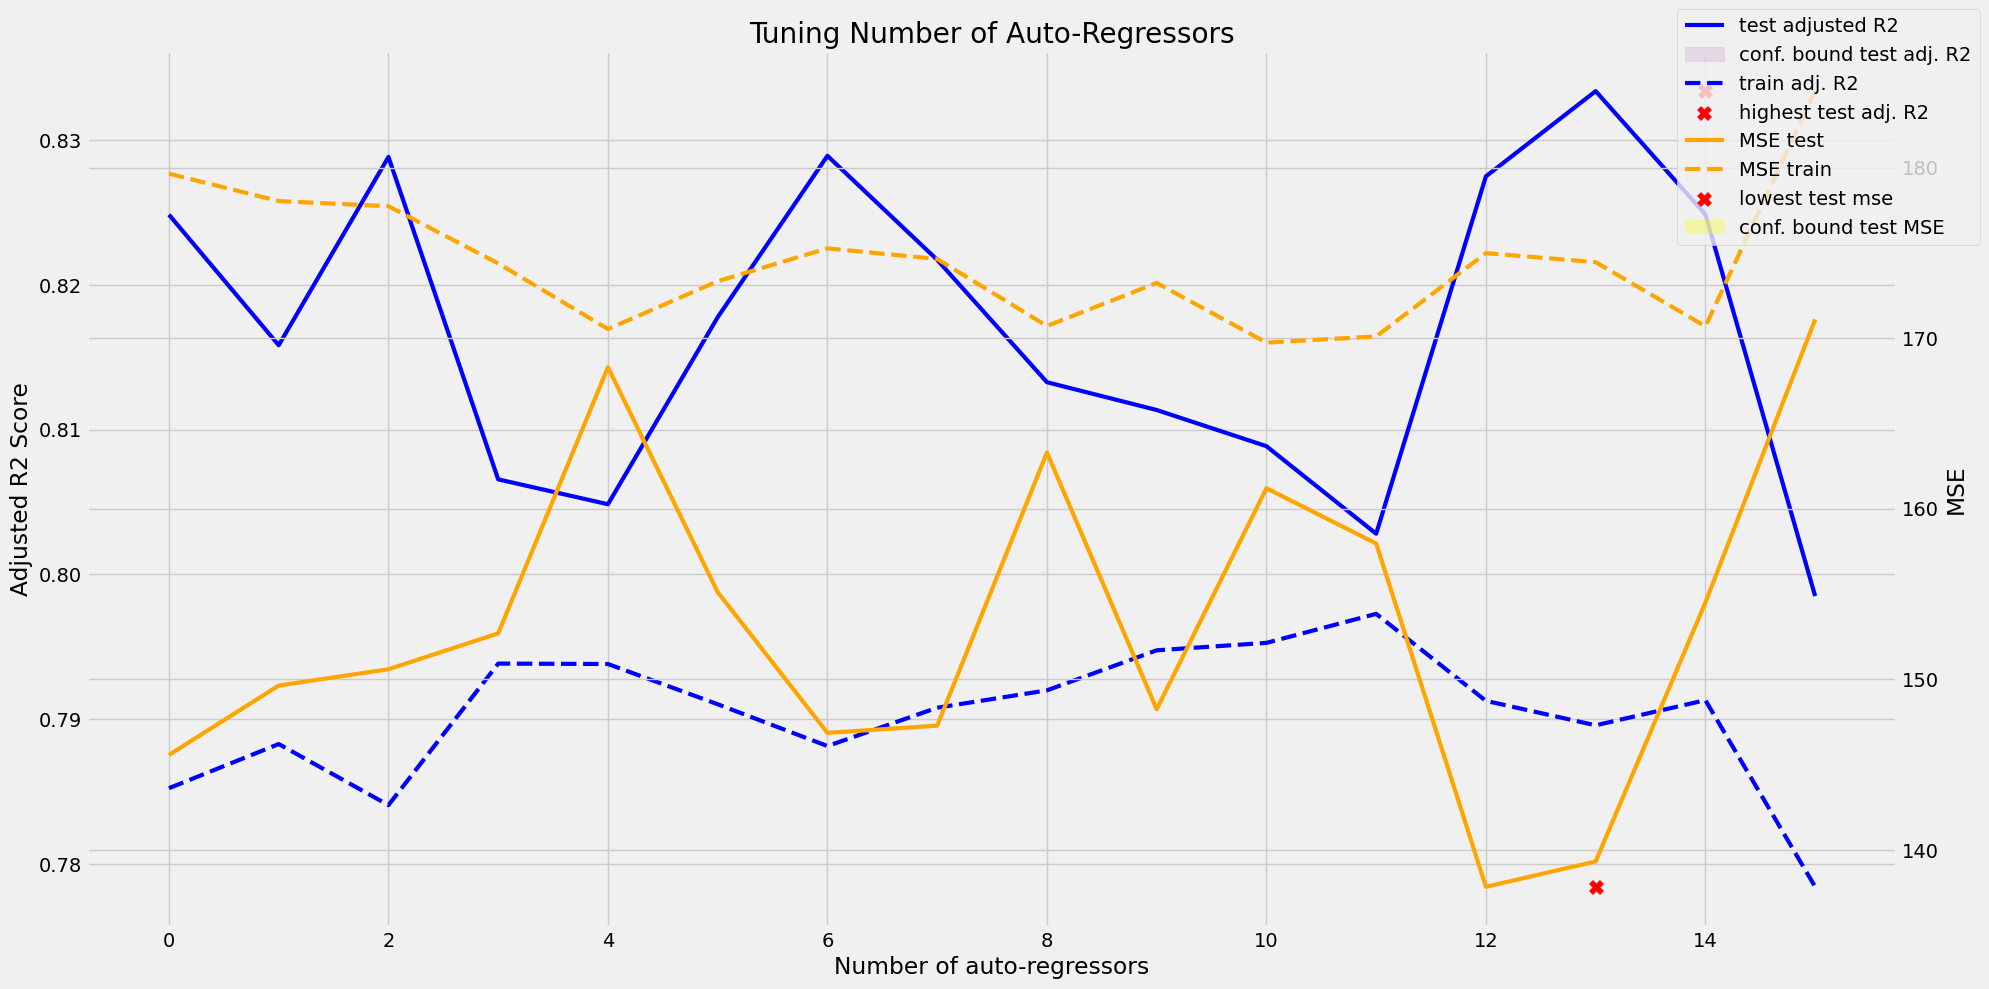

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			14				0.8334			17.2996		139.3155
min MSE:			13				0.8275			15.3210		137.8311
first in range:			1				0.8248			-8.7881		145.5640
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 21 19 22 23 18 25 4 17 49 47
(140015, 256)
(3050, 6)
Train R2 scores:  0.7454858449068635 0.7573042176839389 0.7577731767363238 0.7651641573074253 0.7653928219862223
Test  R2 scores:  0.8073698385272587 0.7609028187537753 0.7582904479450064 0.7290592650199689 0.7282501961611725
Mean absolute error: train 6.5482, test 5.8525
Mean squared error:  train 85.0572, test 65.2831
Explained Variance Score (best=1): train 0.7455, test 0.8076
Coefficient of determination (R2): train 0.7455, test 0.

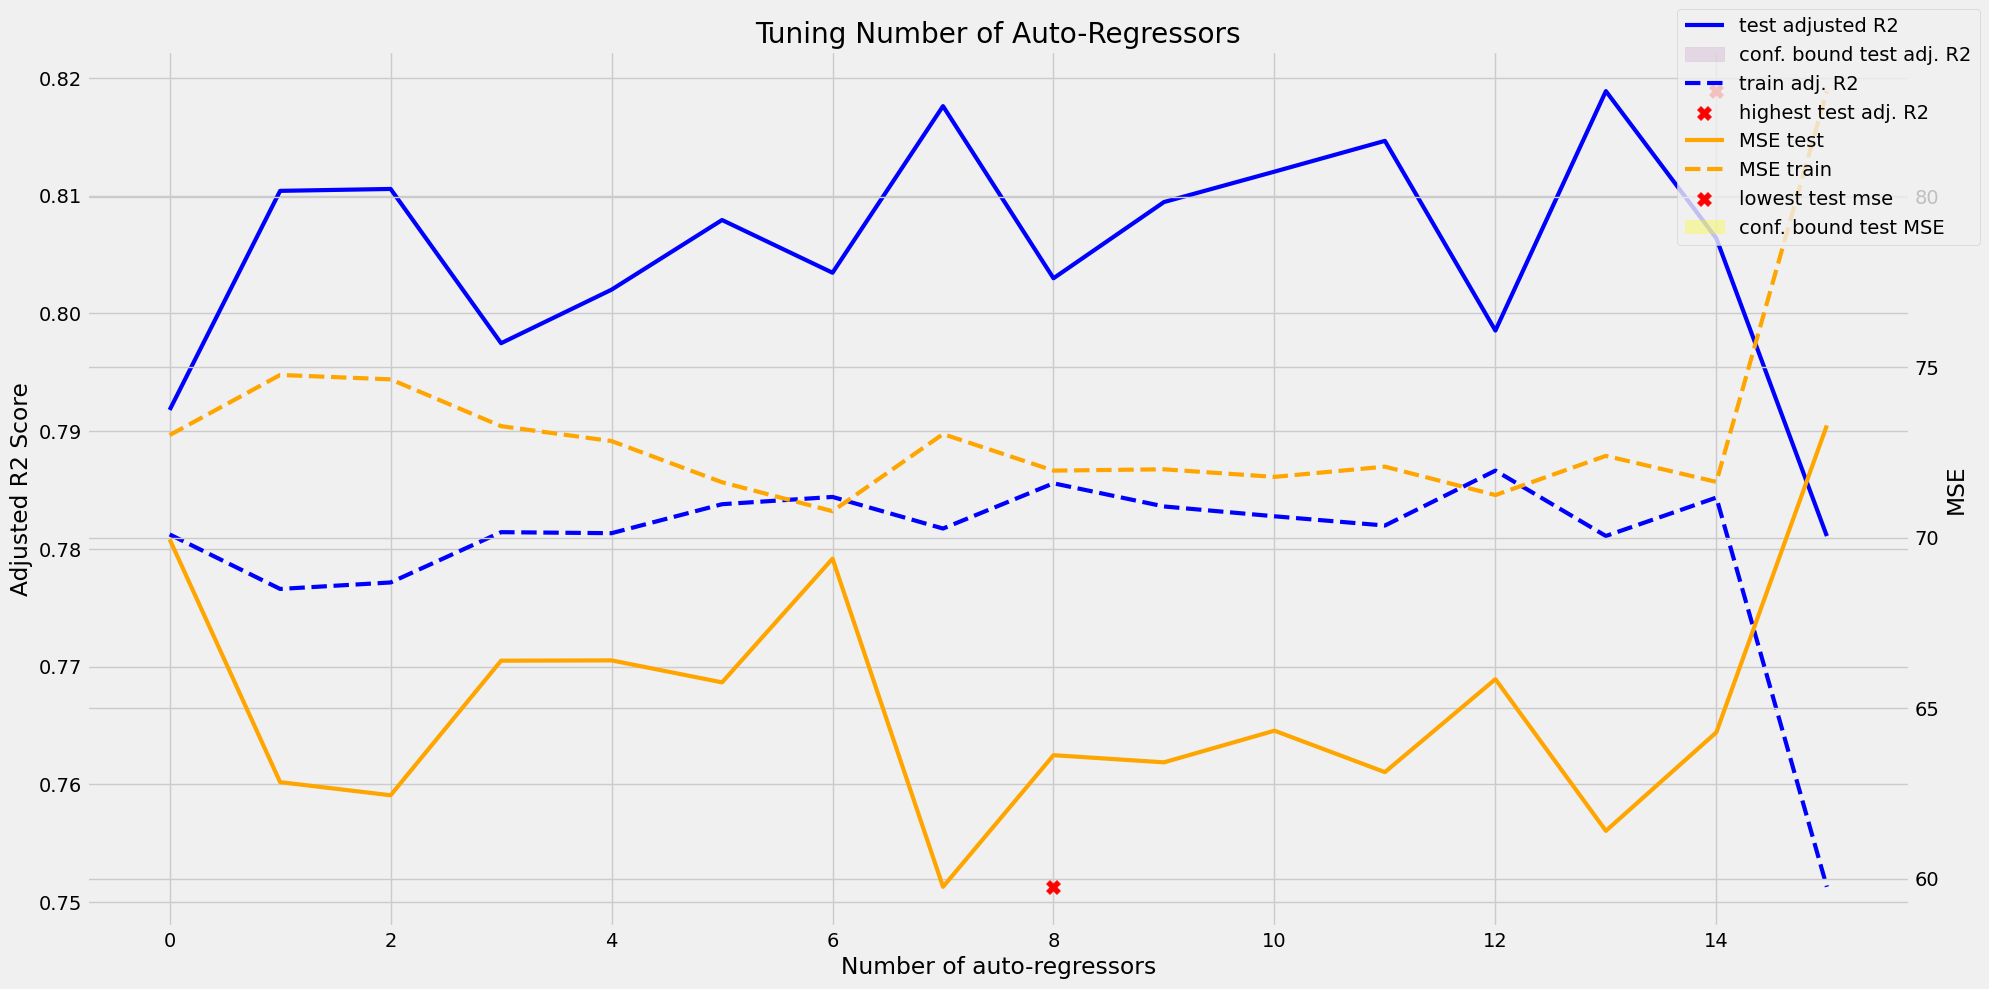

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			14				0.8189			18.9383		61.3994
min MSE:			8				0.8176			6.9924		59.7588
first in range:			2				0.8104			-5.1077		62.8277
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2
[RES] lags by lowest adj r2:  1 2 3 21 22 18 19 20 17 23 4 25 16 11
(140015, 256)
(3050, 6)
Train R2 scores:  0.7867850565703963 0.7829234441405182 0.7836409476659348 0.7756943373171231 0.7831188059148497
Test  R2 scores:  0.7646634346975909 0.778605013676209 0.7759579337175883 0.8079128110112027 0.7773859676729723
Mean absolute error: train 4.5162, test 4.2062
Mean squared error:  train 37.7820, test 32.6952
Explained Variance Score (best=1): train 0.7757, test 0.8079
Coefficient of determination (R2): train 0.7757, test 0.8079

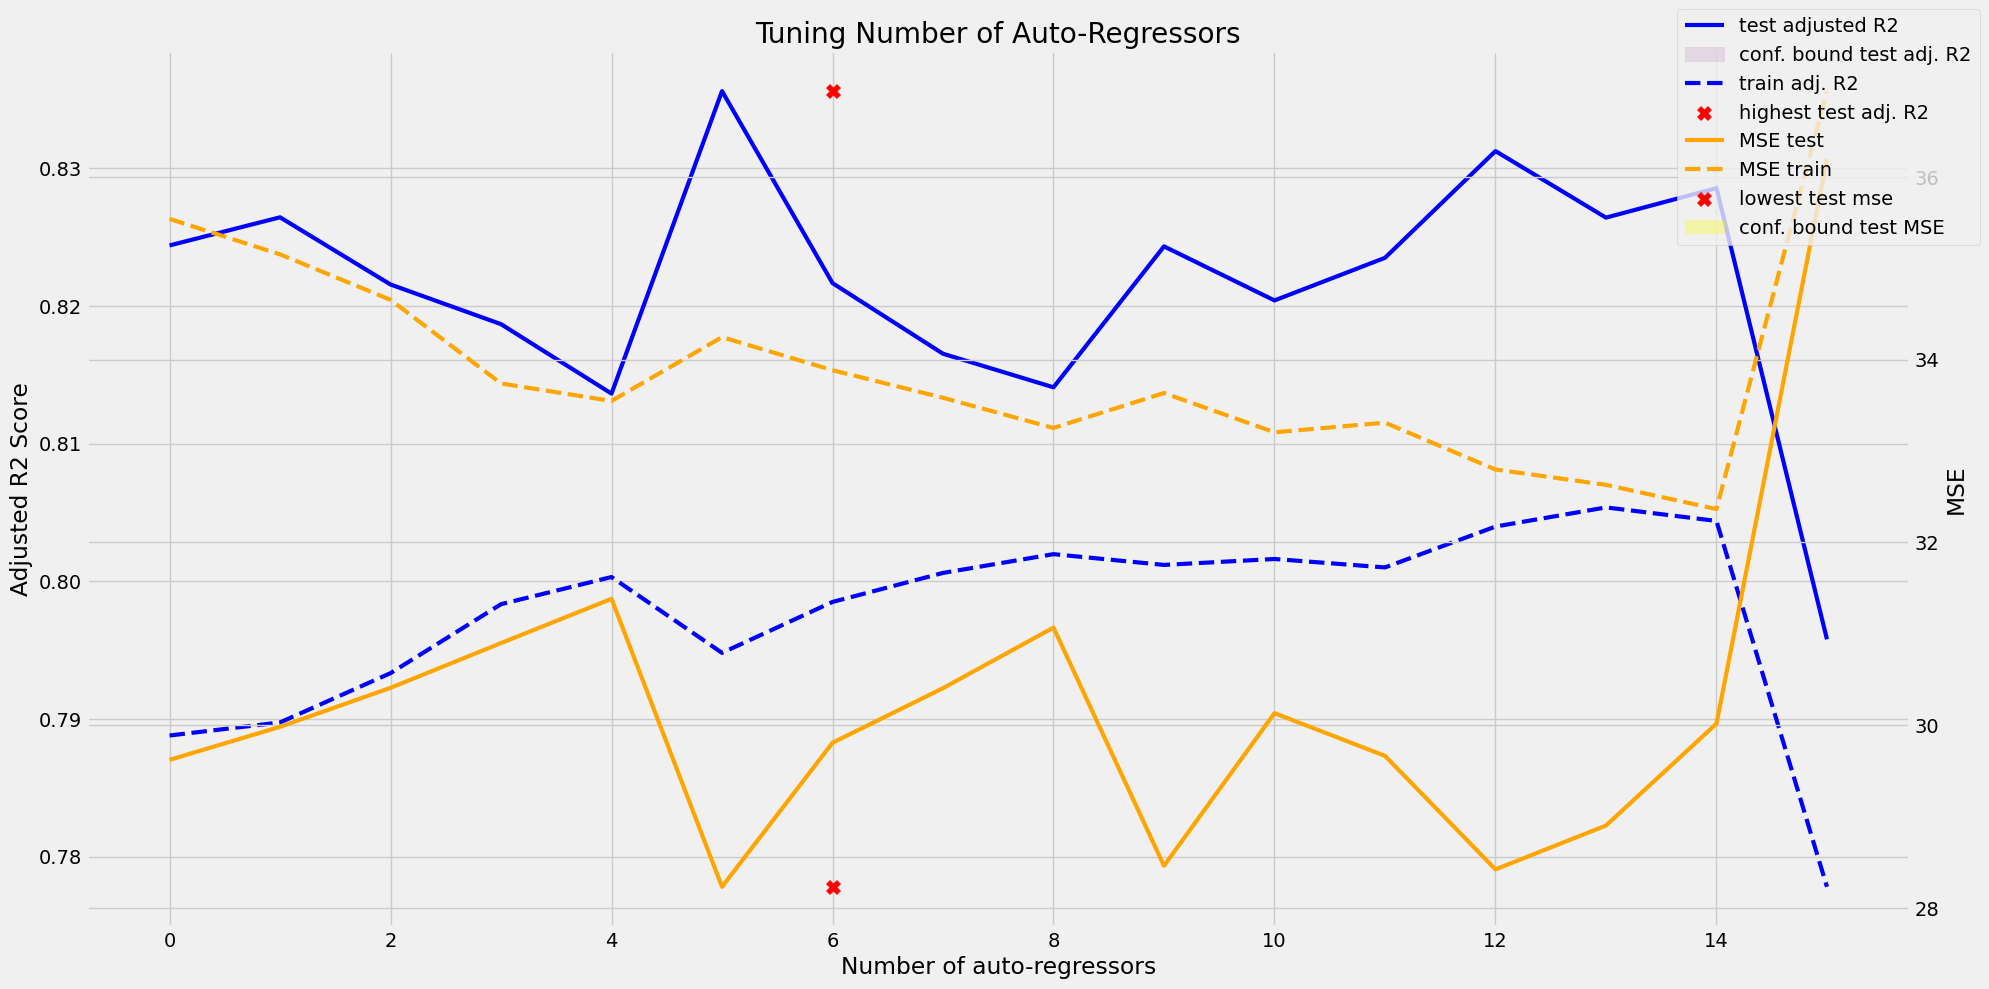

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			6				0.8356			4.4920		28.2337
min MSE:			6				0.8356			4.4920		28.2337
first in range:			1				0.8244			-5.6040		29.6222
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 19 21
(140015, 256)
(3050, 6)
Train R2 scores:  0.7777274623227917 0.77451150468009 0.7755855085886671 0.7761057299210172 0.772184963021572
Test  R2 scores:  0.7637682650026292 0.7767005739341408 0.7725342190079715 0.7703950162817567 0.7858915077368259
Mean absolute error: train 4.0381, test 3.9993
Mean squared error:  train 31.2252, test 29.3722
Explained Variance Score (best=1): train 0.7722, test 0.7863
Coefficient of determination (R2): train 0.7722, test 0.7859
Adjusted coeff. of determina

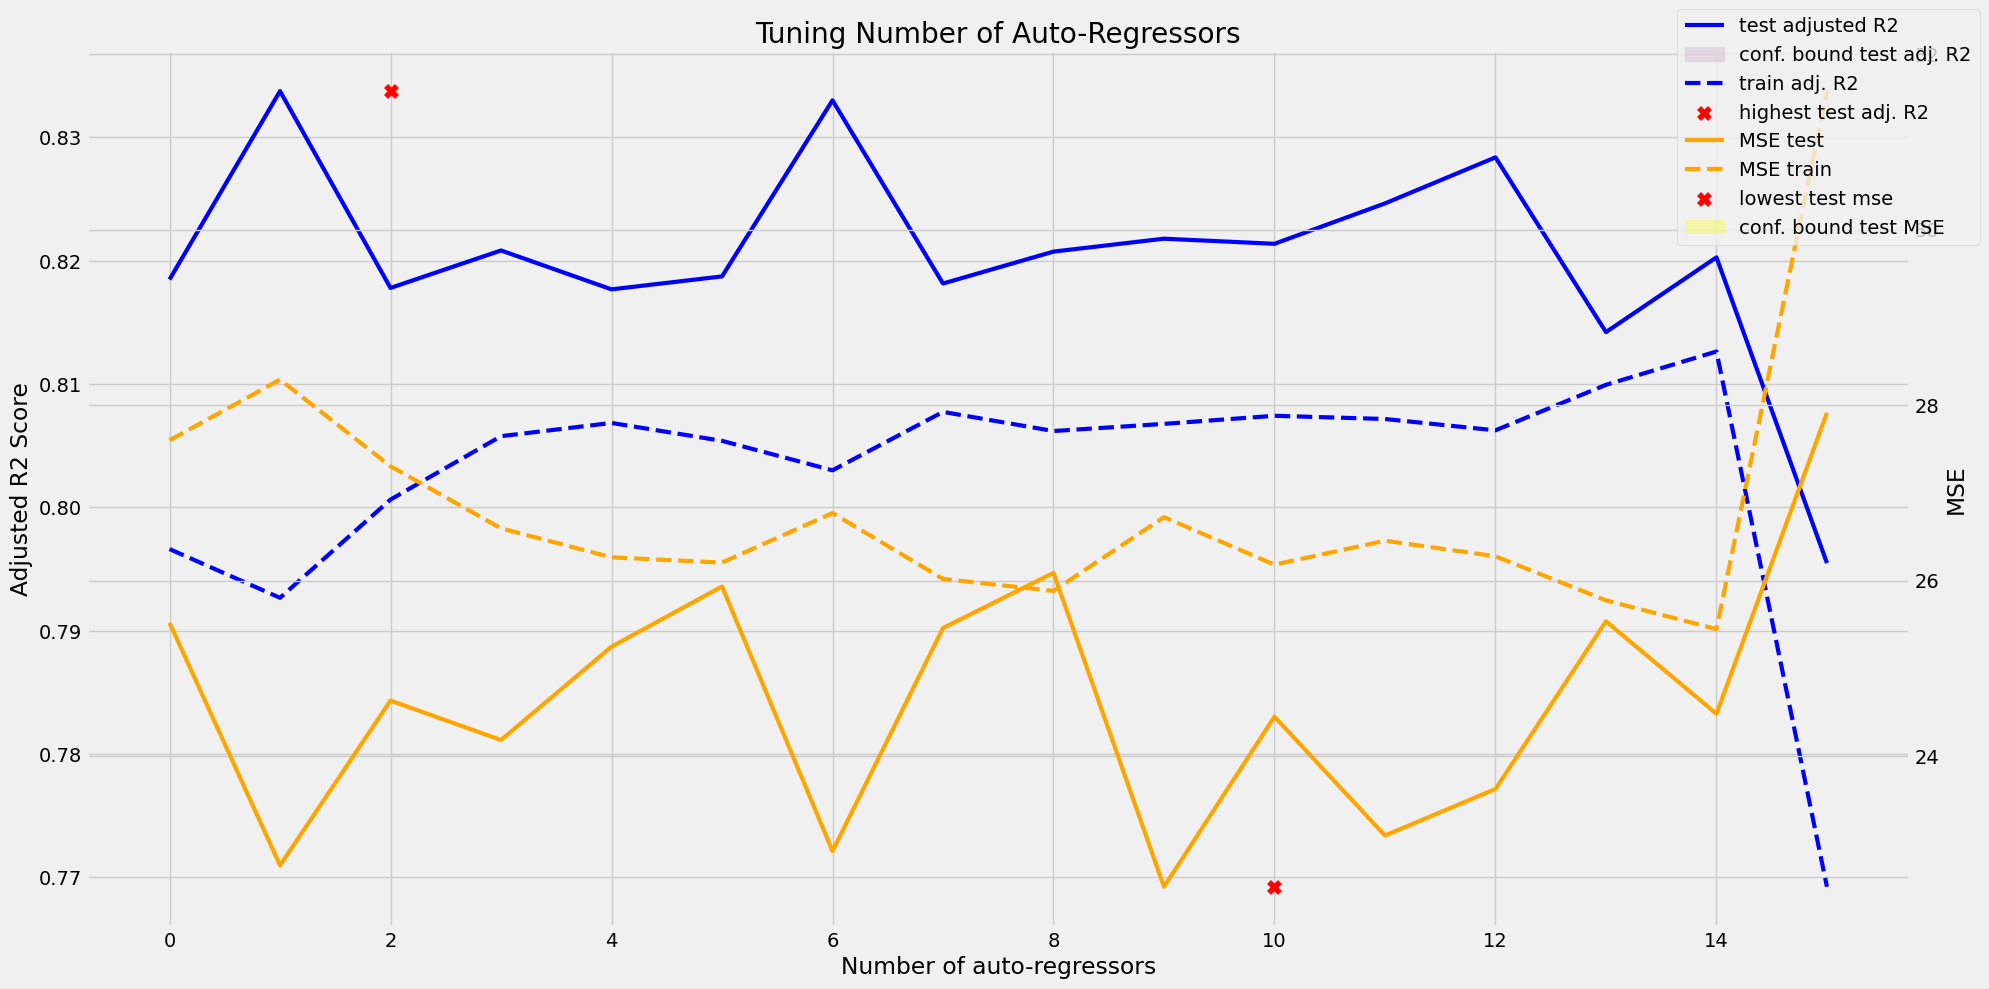

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			2				0.8338			-3.0766		22.7561
min MSE:			10				0.8218			12.9450		22.5116
first in range:			2				0.8338			-3.0766		22.7561
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2
[RES] lags by lowest adj r2:  1 2
(140015, 256)
(3050, 6)
Train R2 scores:  0.7876034874596918 0.7847359826736149 0.7914427615725188 0.7847585729892947 0.7847598441269025
Test  R2 scores:  0.779823562621544 0.7936457774559351 0.766731312062876 0.7916109172752268 0.7931678452813735
Mean absolute error: train 3.5898, test 3.5837
Mean squared error:  train 24.2228, test 22.9212
Explained Variance Score (best=1): train 0.7847, test 0.7939
Coefficient of determination (R2): train 0.7847, test 0.7936
Adjusted coeff. of determination:

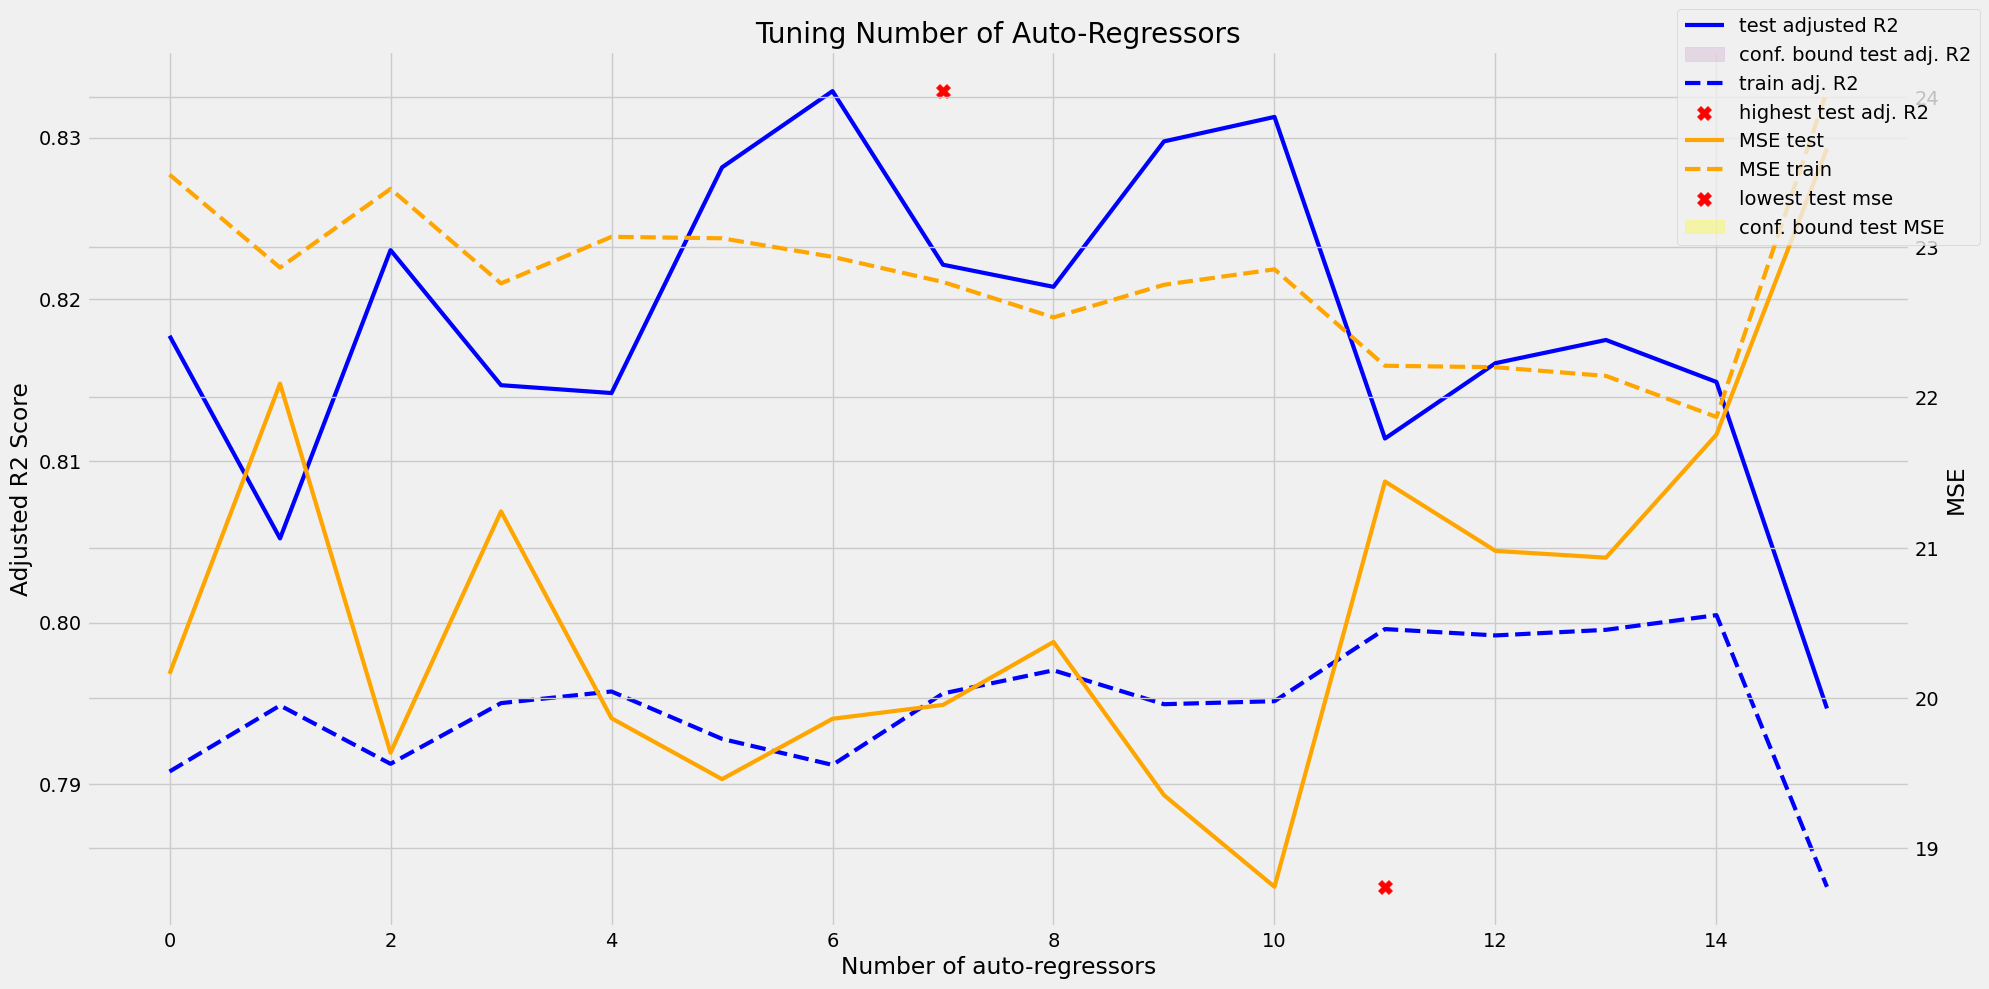

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			7				0.8329			7.1954		19.8622
min MSE:			11				0.8313			15.3113		18.7445
first in range:			1				0.8177			-4.8344		20.1612
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 21 19 22
(140015, 256)
(3050, 6)
Train R2 scores:  0.7607656535643414 0.7617697074680243 0.7614871282390342 0.763378244738437 0.7662353799198565
Test  R2 scores:  0.7682159083484448 0.7627605944252243 0.7652085944968533 0.7586037216199527 0.7477268546826875
Mean absolute error: train 6.6637, test 6.5711
Mean squared error:  train 84.5528, test 83.0875
Explained Variance Score (best=1): train 0.7608, test 0.7694
Coefficient of determination (R2): train 0.7608, test 0.7682
Adjusted coeff. of de

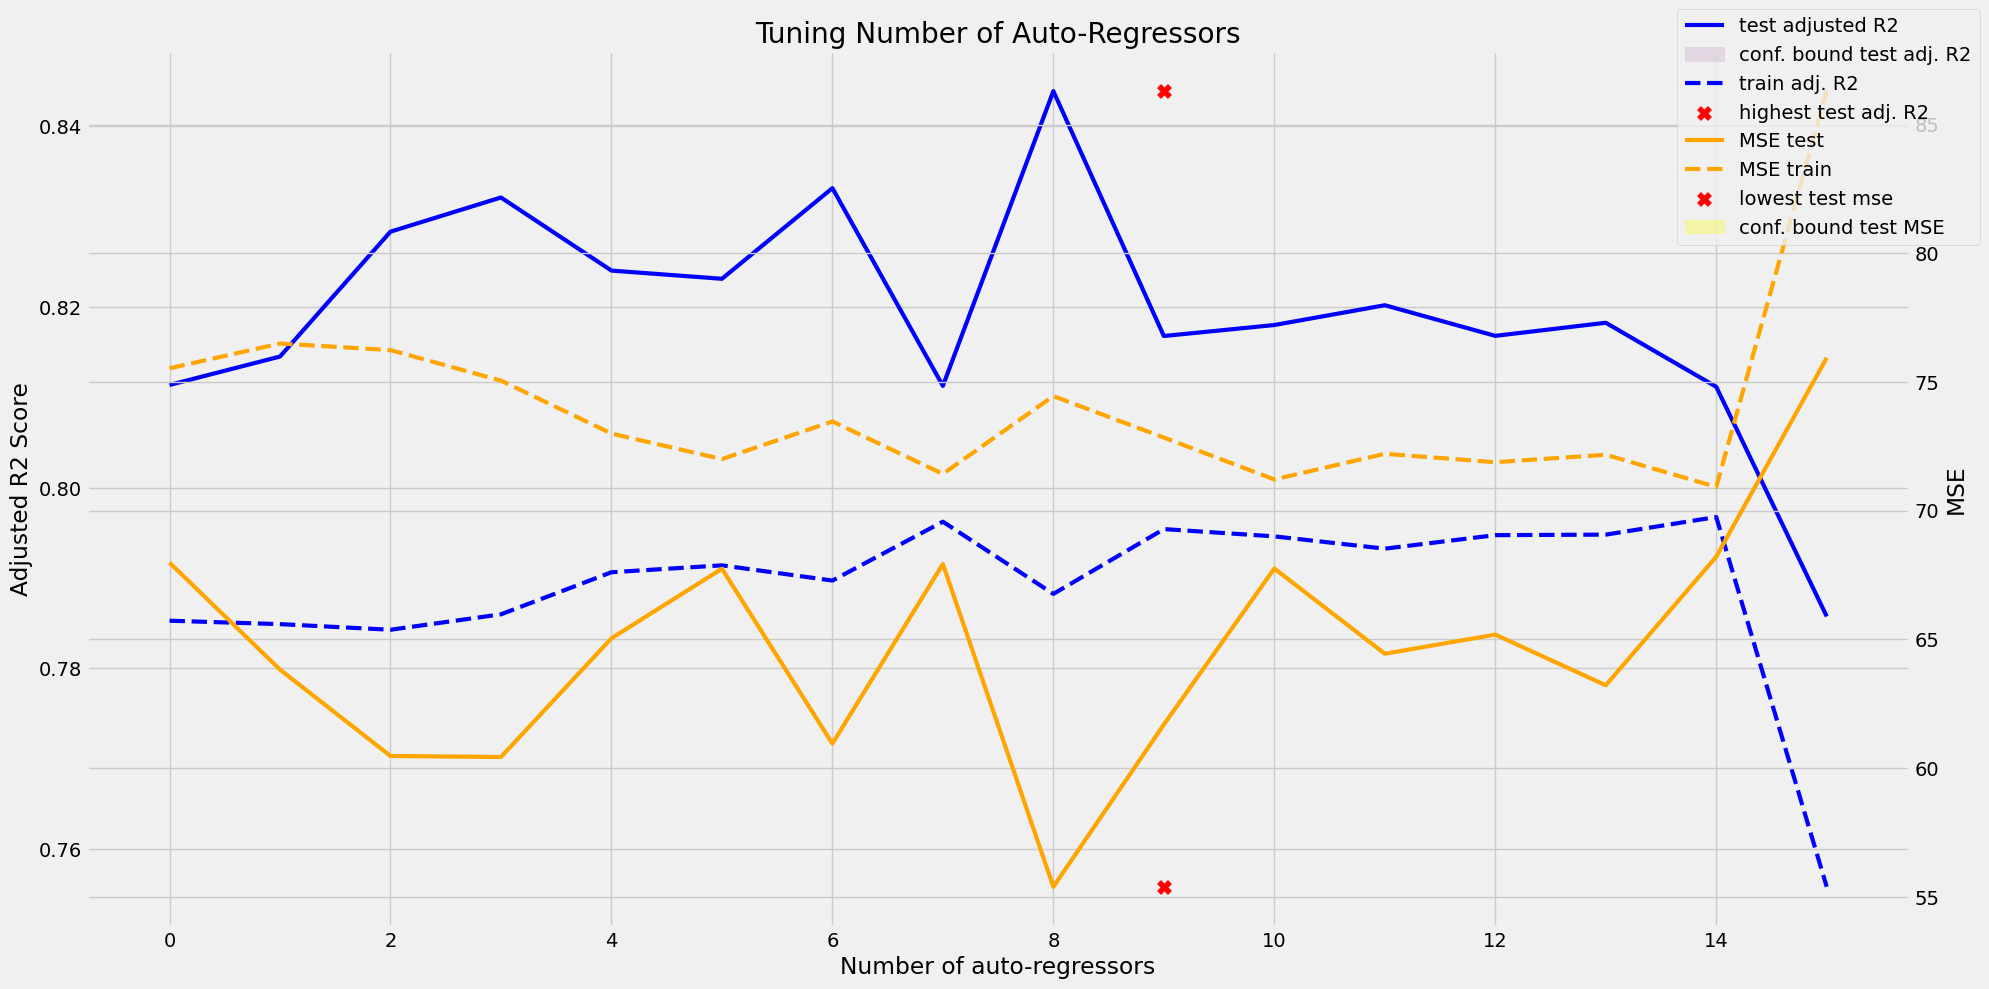

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			9				0.8439			9.1443		55.3887
min MSE:			9				0.8439			9.1443		55.3887
first in range:			3				0.8283			-3.0312		60.4697
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3
[RES] lags by lowest adj r2:  1 2 3 21 20 22 19 18 17
(140015, 256)
[INFO] the following constnat features were removed:  lag 13 lag 61 lag 85 lag 109 lag 133 lag 157 lag 181 lag 205 lag 37 lag 229 lag 325 lag 373 lag 301 lag 253 lag 277 lag 349 lag 565 lag 661 lag 397 lag 421 lag 589 lag 493 lag 685 lag 445 lag 517 lag 541 lag 469 lag 613 lag 709 lag 637
(3050, 6)
Train R2 scores:  0.7724077411150184 0.7744125789563056 0.7741896994099028 0.7709516201951722 0.7746473336148754
Test  R2 scores:  0.7757784261360167 0.76801917849020

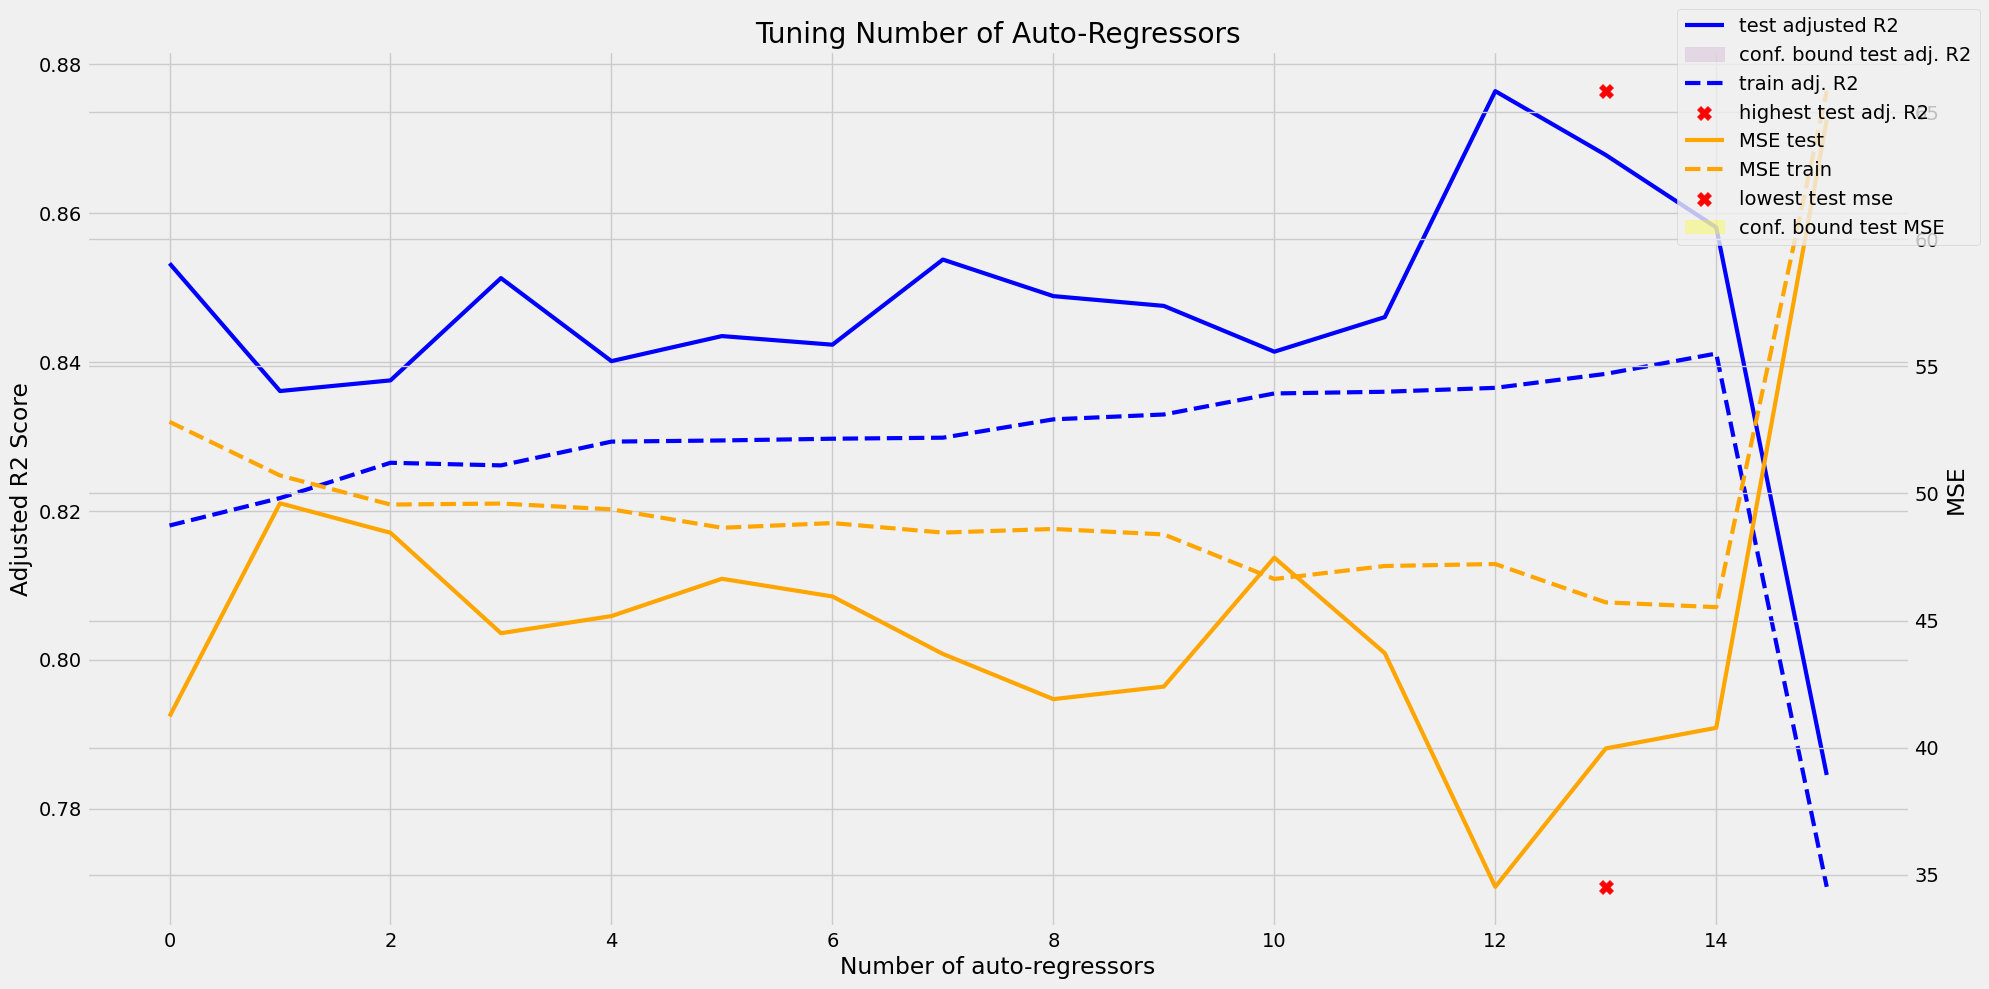

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			13				0.8764			18.0899		34.5224
min MSE:			13				0.8764			18.0899		34.5224
first in range:			13				0.8764			18.0899		34.5224
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20 19 21 18 22 17 23 25 4 10
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 23 25 4 10
(140015, 246)


In [ ]:
# selecting the lags
first_in_range, best_num_r = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
best_num_m, sorted_lags = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
for client_num in clients_subset:
    first_in_range[client_num], best_num_r[client_num], best_num_m[client_num], sorted_lags[client_num] = tune_pacf(
                    house=houses[client_num], max_num_lags=15, max_num_days=30, 
                    train_years=env_dict['train_scenarios']['5y']['train_years'],
                    valid_years=env_dict['train_scenarios']['5y']['valid_years'],
                    step_ahead=1, repeats=5, verbose=True)
    print('[RES] lags by first in range: ', *sorted_lags[client_num][:first_in_range[client_num]])
    print('[RES] lags by lowest adj r2: ', *sorted_lags[client_num][:best_num_r[client_num]])
    print(houses[client_num].data_power.shape)


# Feature Selection Based on Several Houses

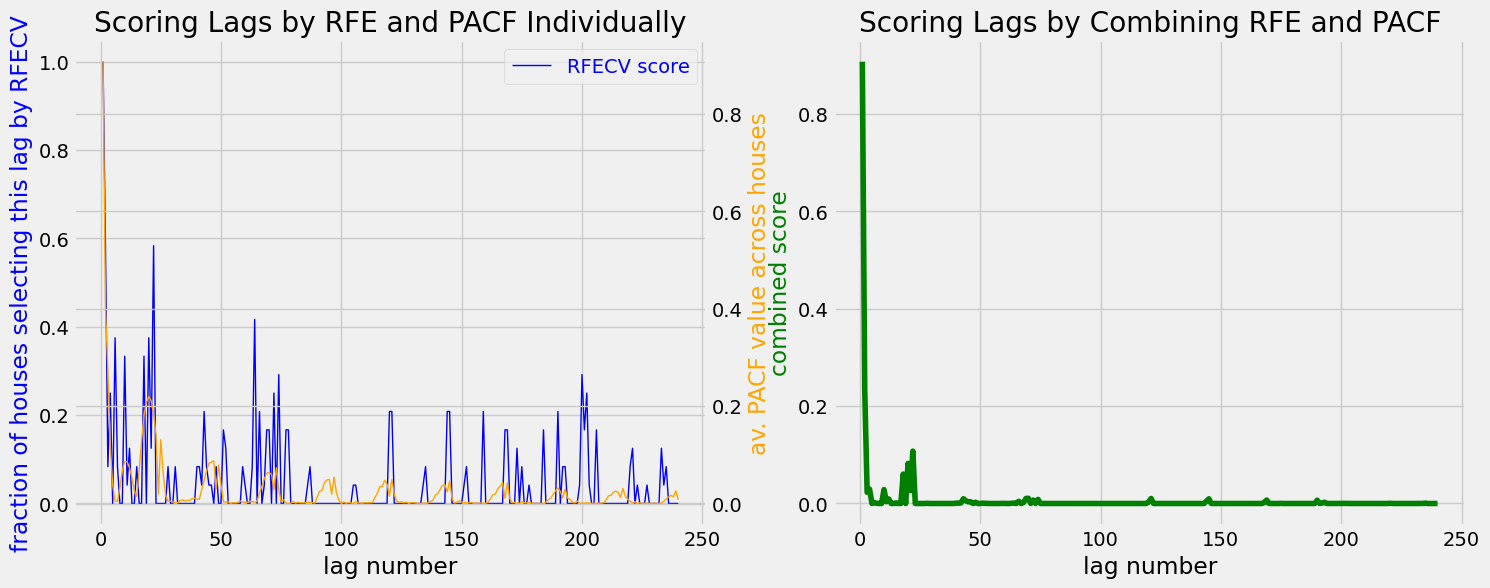

[INFO] sorted lags:  lag 1 lag 2 lag 22 lag 20 lag 18 lag 4 lag 10 lag 21 lag 3 lag 70 lag 69 lag 121 lag 43 lag 145 lag 12 lag 74 lag 72 lag 169 lag 190 lag 44 lag 144 lag 66 lag 11 lag 46 lag 45 lag 120 lag 48 lag 193 lag 68 lag 6 lag 168 lag 15 lag 42 lag 192 lag 64 lag 235 lag 40 lag 41 lag 51 lag 220 lag 7 lag 28 lag 52 lag 63 lag 175 lag 59 lag 202 lag 31 lag 234 lag 87 lag 206 lag 201 lag 159 lag 233 lag 152 lag 106 lag 221 lag 77 lag 60 lag 151 lag 86 lag 178 lag 78 lag 200 lag 135 lag 134 lag 203 lag 173 lag 227 lag 199 lag 223 lag 105 lag 184
[INFO] sorted lags by RFE:  lag 1 lag 22 lag 2 lag 64 lag 20 lag 6 lag 18 lag 10 lag 200 lag 74 lag 202 lag 72 lag 4 lag 190 lag 159 lag 145 lag 144 lag 121 lag 120 lag 66 lag 43 lag 206 lag 201 lag 184 lag 169 lag 168 lag 78 lag 77 lag 70 lag 69 lag 51 lag 233 lag 221 lag 173 lag 52 lag 21 lag 12 lag 235 lag 220 lag 193 lag 192 lag 175 lag 152 lag 135 lag 87 lag 63 lag 59 lag 48 lag 44 lag 41 lag 40 lag 31 lag 28 lag 15 lag 7 lag 3 lag 

In [ ]:
import statsmodels.tsa.stattools as sttools
alpha = 1 # NOTE: weights the two xcoring methods. if bet 0~1, more weight on RFECV. the smaller, the more important RFECV. if >1, the larger the less important RFECV 
# analyze auto-regressors
# --- COMPUTE AV PACF SCORES ---
pacf_val = np.zeros(full_lags[-1]+1)
for client_num in clients_subset:
    powers = houses[client_num].data_power.loc[:, 'target'].values
    pacf_val += sttools.pacf(powers, nlags=full_lags[-1])
pacf_score = [x/len(clients_subset) for x in pacf_val]


# --- COMPUTE AV RFECV SCORES ---
all_lag_nums = [] # convert all lags to int and put in a list
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        all_lag_nums.extend([int(x.split()[-1]) for x in selected_features[client_num] if x.startswith('lag')])
counts = [all_lag_nums.count(x) for x in np.arange(full_lags[-1]+1)] # count how many times each lag appears
rfe_score = [x/len(clients_subset) for x in counts]


# --- PLOT ---
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax_rfe = axs[0]
ax_pacf = ax_rfe.twinx()
ax_rfe.set_title('Scoring Lags by RFE and PACF Individually')
ax_rfe.set_xlabel("lag number")
ax_rfe.set_ylabel("fraction of houses selecting this lag by RFECV")
ax_pacf.set_ylabel("av. PACF value across houses")
p1, = ax_rfe.plot(np.arange(1, full_lags[-1]+1), 
            rfe_score[1:], 
            label="RFECV score", c='b', lw=1)
p2, = ax_pacf.plot(np.arange(1, full_lags[-1]+1), 
            np.abs(np.array(pacf_score[1:])), 
            label="PACF score", c='orange', lw=1)
ax_rfe.legend(labelcolor="linecolor")
ax_rfe.yaxis.get_label().set_color(p1.get_color())
ax_pacf.yaxis.get_label().set_color(p2.get_color())

# final selection method
score = np.array([(x**alpha)*abs(y) for x,y in zip(rfe_score, pacf_score)])
p3, = axs[1].plot(np.arange(1, full_lags[-1]+1), 
            score[1:], 
            label="combined score", c='g')
axs[1].set_title('Scoring Lags by Combining RFE and PACF')
axs[1].set_xlabel("lag number")
axs[1].set_ylabel("combined score")
axs[1].yaxis.get_label().set_color(p3.get_color())
axs[1].yaxis.get_label().set_color(p3.get_color())
plt.show()

# --- SORT LAGS --- 
# sort lags with a positive score
N = len([x for x in score if x>0])
sorted_lag_nums = np.flip(
                        sorted(
                            range(len(score)), 
                            key = lambda sub: score[sub]
                            )[-N:]
                        )
sorted_lags = ['lag ' + str(x) for x in sorted_lag_nums]
print('[INFO] sorted lags: ', *sorted_lags)


N = len([x for x in rfe_score if x>0])
sorted_lag_nums = np.flip(
                        sorted(
                            range(len(rfe_score)), 
                            key = lambda sub: rfe_score[sub]
                            )[-N:]
                        )
sorted_lags_rfe = ['lag ' + str(x) for x in sorted_lag_nums]
print('[INFO] sorted lags by RFE: ', *sorted_lags_rfe)


## Tuning the Number of Features

In [ ]:
selected_non_ar = []
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        selected_non_ar.extend([x for x in selected_features[client_num] if not x.startswith('lag')])
selected_non_ar = list(set(selected_non_ar))
env_dict['feature_names'] = selected_non_ar

del houses
# reconstruct houses
houses = [None] * env_dict['num_clients']
for client_num in np.arange(env_dict['num_clients']):
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


[INFO] reconstructed the 5y scenario.


In [ ]:
# fit model with the selected features for each house
selected_feat = selected_non_ar + sorted_lags

all_rmses = np.zeros((len(houses), len(sorted_lags)+1))
all_adjr2s = np.zeros((len(houses), len(sorted_lags)+1))

# effect of num of features on performance for each house
for client_num, house in enumerate(houses):
    house = houses[client_num]

    # augment lags
    house.data_power = _augment_lags(
                            house.data_power, 
                            lags=sorted_lag_nums, 
                            step_ahead=1)
    house.feature_names = selected_feat
    
    # construct regression matrices
    data_tuple = house.construct_regression_matrices(
        m_train=env_dict['train_scenarios'][scenario_name_recons]['m_train'],
        train_years=env_dict['train_scenarios'][scenario_name_recons]['train_years'],
        valid_years=env_dict['train_scenarios'][scenario_name_recons]['valid_years'])

    X_train, y_train, X_valid, y_valid = data_tuple
    assert X_train.shape[1] == len(selected_feat)
    
    # drop features one by one
    for num_lags in np.arange(len(sorted_lags)+1):
        cols_red = np.arange(len(selected_non_ar)+num_lags) 
        X_train_red = X_train[:, cols_red]
        X_valid_red = X_valid[:, cols_red]

        # fit Ridge regression with Grid search over penalty
        ridge_wrapper = RidgeWrapper(
                                alphas=np.logspace(-6,2,20), 
                                flatten_y = True, 
                                normalize_data=True) 
        ridge_wrapper.fit(X_train_red, y_train)

        # evaluate on validation data
        y_valid_pred = ridge_wrapper.predict(X_valid_red)
        y_valid_pred = y_valid_pred.reshape(y_valid.shape)
        all_rmses[client_num, num_lags] = np.mean((y_valid_pred-y_valid)**2)**0.5
        all_adjr2s[client_num, num_lags] = adj_r2_scorer(ridge_wrapper, X_valid_red, y_valid)


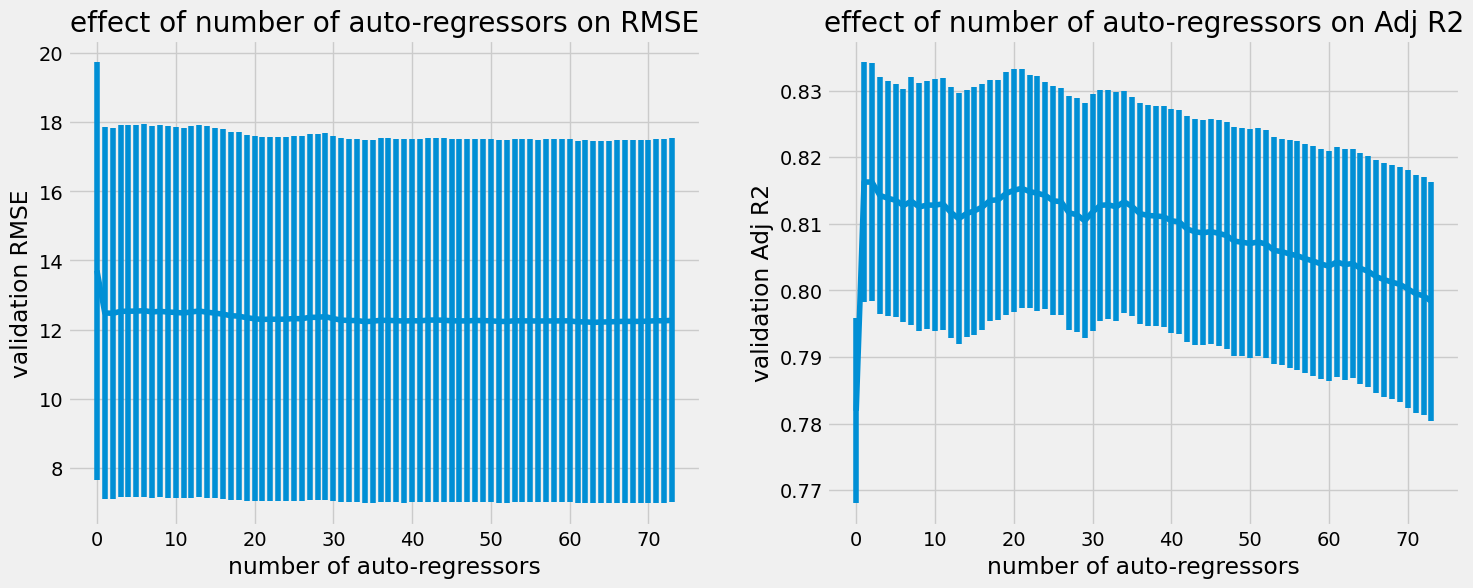

In [ ]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(16,6))
for ax, meas_name in zip(axs, ['RMSE', 'Adj R2']):
    ax.set_title('effect of number of auto-regressors on ' + meas_name)
    ax.set_xlabel('number of auto-regressors')
    ax.set_ylabel('validation ' + meas_name)

p1 = axs[0].errorbar(
            np.arange(len(sorted_lags)+1), 
            np.mean(all_rmses[clients_subset, :], axis=0), 
            np.std(all_rmses[clients_subset, :], axis=0))#label="RFECV score", c='b')
p2 = axs[1].errorbar(np.arange(len(sorted_lags)+1), 
            np.mean(all_adjr2s[clients_subset, :], axis=0), 
            np.std(all_adjr2s[clients_subset, :], axis=0))
#ax_rmse.legend(labelcolor="linecolor")
#ax_rmse.yaxis.get_label().set_color(p1.get_color())
#ax_r2.yaxis.get_label().set_color(p2.get_color())

In [ ]:
num_lags_opt_r2 = np.argmax(np.mean(all_adjr2s[clients_subset, :], axis=0))
mean_rmse = np.mean(all_rmses[clients_subset, :], axis=0)
min_rmse = np.min(mean_rmse)
num_lags_opt_rmse = list(mean_rmse<min_rmse*1.01).index(True)

for num_lags_opt, met in zip([num_lags_opt_r2, num_lags_opt_rmse], ['r2', 'rmse']):
    selected_lags=sorted_lags[0:num_lags_opt]
    #selected_lag_nums = [int(x.split()[-1]) for x in selected_lags]
    #selected_lag_nums.sort()
    #print(selected_lag_nums)
    print('[INFO] the following {:2.0f} lags were selected using '.format(num_lags_opt) + met + ' criterion: ', selected_lags)

[INFO] the following  1 lags were selected using r2 criterion:  ['lag 1']
[INFO] the following 20 lags were selected using rmse criterion:  ['lag 1', 'lag 2', 'lag 22', 'lag 20', 'lag 18', 'lag 4', 'lag 10', 'lag 21', 'lag 3', 'lag 70', 'lag 69', 'lag 121', 'lag 43', 'lag 145', 'lag 12', 'lag 74', 'lag 72', 'lag 169', 'lag 190', 'lag 44']


# save env

In [ ]:
selected_lags = [
    'lag 1', 'lag 2', 'lag 3', 'lag 4',
    'lag 18', 'lag 20', 'lag 21', 'lag 22', 
    'lag 43', 'lag 44', 
    'lag 69', 'lag 70', 'lag 72', 'lag 74',
    'lag 121', 'lag 145', 'lag 169', 'lag 190']
# removed b.c. night: 'lag 12',  'lag 10'

selected_lags = [int(x.split()[-1]) for x in selected_lags] 
selected_lags.sort()
print(selected_lags)
env_dict['lags'] = selected_lags
# generate env with these lags
pvdataset = PVDataset(env_dict)
env_dict = pvdataset.generate_clients_data()
# select non-ar features
non_ar_feat_keep = ['H_sun', 'station_irrad_direct_prev', 'T2m', 'WS10m']
non_ar_feat_remove = [x for x in env_dict['feature_names'] if not ((x in non_ar_feat_keep) or x.startswith('lag'))]
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)

# print info
print('\n'+env_dict['info'])
for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('[INFO] {:2.0f} features: '.format(len(env_dict['feature_names'])), env_dict['feature_names'])

save_env = True
if save_env:
    # save env
    file = open(filename_env + '_feat_eng', 'wb')
    pickle.dump(env_dict, file)
    msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])
    print(msg)

[1, 2, 3, 4, 18, 20, 21, 22, 43, 44, 69, 70, 72, 74, 121, 145, 169, 190]
[INFO] generating data for Lausanne

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples
[INFO] 22 features:  ['H_sun', 'T2m', 'WS10m', 'station_irrad_direct_prev', 'lag 1', 'lag 2', 'lag 3', 'lag 4', 'lag 18', 'lag 20', 'lag 21', 'lag 22', 'lag 43', 'lag 44', 'lag 69', 'lag 70', 'lag 72', 'lag 74', 'lag 121', 'lag 145', 'lag 169', 'lag 190']
[INFO] saved data for 24 clients


# Notes:
To use the generated data, first load the saved env by running


file = open(filename_env, 'rb')
env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])

* To experiment with the data-rich scenario, use 
clients_data = env_dict['train_scenarios']['5y']['clients_data']
* To experiment with the data-scarce scenario, use 
clients_data = env_dict['train_scenarios']['sml']['clients_data']


In both cases, "clients_data" is a list of length "num_clients".

For a client with number "client_num", clients_data[client_num] is a tuple of length 4, where:

x_train, y_train, x_valid, y_valid = clients_data[client_num]

In [ ]:
file = open(filename_env+'_feat_eng', 'rb')
env_loaded = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_loaded['num_clients'])
print(msg)
file.close()
num_clients = env_loaded['num_clients'] 
print('\n'+env_loaded['info'])

# ----- SELECT A SUBSET OF CLIENTS -----
# clients_subset= [12, 14, 15, 17, 22]
# print('Subset of clients for demonstration: ', clients_subset)

num_features = len(env_loaded['feature_names'])
print('\n[INFO] {:2.0f} features: '.format(len(env_loaded['feature_names'])), *env_loaded['feature_names'])

[INFO] loaded data for 24 clients

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 

[INFO] 22 features:  H_sun T2m WS10m station_irrad_direct_prev lag 1 lag 2 lag 3 lag 4 lag 18 lag 20 lag 21 lag 22 lag 43 lag 44 lag 69 lag 70 lag 72 lag 74 lag 121 lag 145 lag 169 lag 190
